In [1101]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.special import inv_boxcox
from sklearn import tree

client = bigquery.Client()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Introduction
### Logistical notes
This is a third pass at this analysis. In the interest of keeping things concise and avoiding a long notebook with unnecessary code blocks, portions from the second pass are omitted. You can find the second pass in the adjacent notebook of the same title with "_2" in the name. You can find the first pass at an initial EDA here: https://console.cloud.google.com/bigquery?ws=!1m7!1m6!12m5!1m3!1sbloomerang-data!2sus-west1!3sd6c5ef73-ccc2-48d5-90f0-8b5cceb0a874!2e2. The switch from Google's cloud-based notebook to a local notebook was due to problems with their uptime.

Sections that are removed in this notebook (#3):
- Continuing the analysis around 3 different model options throughout the notebook. In this one, the choice of one model is made in the trendline section, and subsequent analysis focuses on this one model.
- Feedback notes from notebook 1 applied to notebook 2. Feedback from notebook 1 incorporated in notebook 2 can be found in notebook 2. Feedback listed here applies to notebook 2, incorporated in notebook 3. 

Feedback applied from previous iteration:
- Renaming "online" revenue to "fundraising" revenue.
- Highlighting general vs. customer orgs as "market" vs. "customer."
- Adding a definition section of terms
- Applying the term "off-platform revenue" to fundraising revenue that occurs among customers but outside out products.
- Profiling churned customers and current customers
- Add a side-by-side chart of market and customer geographic regions
- Add a side-by-side chart of above/below trendline for market outliers vs. customer outliers
- (Nice-to-have) outlier profile of transactions by revenue rather than counts
- (Nice-to-have) names of outlier customers in the 0-2 users group
- (Future) Membership revenue ratio
- (Future) check ratio and cash ratio

### Background
This analysis is looking at "outliers," where outlier is defined as an org taking in more than predicted in business opportunity revenue (donations, memberships, events, major gifts, etc.) based on CauseIQ-reported total revenue. The income we are not intersted in is that which would never pass through  online payment processors (e.g. grants, government grants, royalties, rental income, other business income).

Total revenue = business opportunity income + non-business opportunity income

i.e.: Total revenue = fundraising income + grants/rentals/royalties/other biz income

Throughout this report, we may refer to this business opportunity income as "fundraising income."

A copy of the original analysis (which predates all three notebooks thus far) which definined and identified the outliers in a different way is here: https://docs.google.com/spreadsheets/d/1t-DqEL0tYolJhkM1ihXWe4LLGkJOx5YL7QUcrgKep44/edit?gid=1211611968#gid=1211611968. This original analysis identified the trend line (predicted amount) vs. actual amount, and this establishes the target variable for our analysis. It did not include predictor variables, so part of this analysis will involve sourcing and exploring potential predictors.

The initial pass at identifying outliers in another notebook is here: https://console.cloud.google.com/bigquery?ws=!1m7!1m6!12m5!1m3!1sbloomerang-data!2sus-west1!3sd6c5ef73-ccc2-48d5-90f0-8b5cceb0a874!2e2. This initial notebook used the previous analysis (NPR, ARR) rather than starting from scratch as we're doing here.

## Work to be done
- Fit a new trend line to fundraising as a function of total income
- Establish definition of outlier or other outcome variable based upon the relationship with that trend line
- Explore predictor variables that differentiate outlier vs. not
- Build a robust prediction of outlier vs. not (e.g. a model)

# Create outcome dataset

This dataset contains total revenue, revenue from business-potential activities (donations, memberships, events, etc.), and various revenue-related columns from CauseIQ. It also contains revenue-based segments, in order to establish the business' segment.

### Revenue and business-potential revenue calculation

- Total revenue (from CauseIQ) is used to establish the segment. This is because segment has a standard calculation and this is how it's supposed to be calculated. In cases where internal revenue (Bloomerang + QGiv for KFT) for that year exceeds CauseIQ-reported revenue, we default to our internal  records of revenue for that org.
- When computing the % of income that came from business-potential streams, this gets complicated. The column used is not "total revenue" but rather the "total grants and contributions" column. This is because "total" potentially contains other sources such as bonds or royalties, and we can jump over that and go directly to the "total grants and contributions." From this column, we just subtract the "government grants" and "related organizations" columns to get at memberships, donations, events. etc. Related orgs are excluded because we assume these are coming in via bank transfer (TODO: confirm this assumption)
- In cases where fundraising revenue > total revenue (not possible), fundraising revenue is capped at total revenue (see note below about messiness in the data). In cases where internal (Bloom + QGiv + KFT) > CauseIQ-computed fundraising revenue, we use our internal records of that org's fundraising revenue.
- There is a note to add to above. Because CauseIQ data is somewhat messy, there are cases where "total grants and contributions" does not seem to add up to the sum of all relevant income sources, or where "total grants and contributions" does not sum from all income sources. We may just need to accept the messiness of the CauseIQ dataset in these cases

### Fitting of the trend line
In order to establish what is an outlier in terms of % of income that comes from business-potential avenues, we need to fit a trendline. This could potentially be:

- An overall trendline
- A separate model fit per segment

## Calculate outcome variable

### Create a SalesForce export
1. Originally, An export was created in SalesForce which filters on account created on or after July 12, 2012. No other filters were used. The columns included are listed below. It may pan out that not all of these are needed, but they were included in the initial export in case. This dataset is no longer used and instead the GBQ salesforce tables are used, but I list it here for documentation.

- Account ID
- Qgiv Customer Id
- Bloomerang Database Name
- Cause IQ: Most Recent Tax Filings
- Cause IQ: Primary NTEE
- Cause IQ: Total Revenues
- Cause IQ: # of Organizations Supported
- Cause IQ: Total grants, contributions
- Cause IQ: Government Grants
- Cause IQ: Normal Grants & Contributions
- Cause IQ: Fundraising event contribution
- Cause IQ: All member fees, dues, etc.
- Cause IQ: Membership dues
- Cause IQ: Investment income and dividend
- Cause IQ: Tax-exempt bond proceeds
- Cause IQ: Related organizations
- Cause IQ: Number of Volunteers
- Cause IQ: Unrelated business income
- Cause IQ: Royalty revenue
- Cause IQ: Net rental income
- Cause IQ: # of Group Members
- Cause IQ: Year Formed
- Cause IQ: Metro Area

2. The dataset was loaded into GCS, and then into GBQ at `bloomerang-data.product_ops.outliers_sf_export`\

3. An additional dataset of ID's was exported, containing just:

- AccountID
- Bloomerang Database Name
- QGiv Org ID
- Kindful Subdomain

4. This additional dataset of just ID's was loaded into GBQ at `bloomerang-data.product_ops.outliers_ids`

5. Internal revenue for QGiv was taken from `bloomerang-data.product_ops.metrics_revenue_qgiv`, which was created for a separate project for the metrics working group documented here: [Notion](https://www.notion.so/bloomerang/Company-Stat-Total-Funds-Raised-1eaf8da2e76f80a3a29cd1bfe5415b81?source=copy_link). The data was exported from Jeremy's QGiv dataset.

6. Internal revenue for Bloomerang was taken from `bloomerang-data.product_ops.metrics_revenue_bloomerang`, which was created for the same metrics proejct. The data was extracted from the CRM.

6. Internal revenue for KFT was taken from `bloomerang-data.product_ops.metrics_revenue_kindful` as a part of the same project. Kindful data lives in GBQ, so the code to create this table is stored in DataForm: [DataForm](https://console.cloud.google.com/bigquery/dataform/locations/us-central1/repositories/bloomerang/workspaces/product_ops/files/definitions%2Fproduct%2Fmetrics%2Fmetrics_revenue_kft.sqlx?hl=en&inv=1&invt=Ab4lvA&project=bloomerang-data)

### Join and load data
The datasets (above) that were loaded into GBQ are joined with the following queries, with some checking of data quality.

In [425]:
rewriteFlag = False

# Load data
sql = """
with  
sf as (
  select
    id as AccountId
    , cause_iq_primary_ntee_c as CauseIQPrimaryNTEE
    , cause_iq_metro_area_c as CauseIQMetroArea
    , qgiv_customer_id_c as QGivCustomerId
    , bloomerang_database_name_c as BloomerangDatabaseName
    , kindful_domain_c as KindfulSubdomain
    , cause_iq_most_recent_tax_filings_c as CauseIQMostRecentTaxFilings
    -- tax year to join to internal data
    , extract(year from cause_iq_most_recent_tax_filings_c) as TaxYear
  -- handling of messiness in causeIQ data
    , round(coalesce(cause_iq_total_revenues_c, 0), 2) as CauseIQTotalRevenue
    , case
        when cause_iq_government_grants_c < 0 then 0.0
        else round(coalesce(cause_iq_government_grants_c, 0), 2)
        end as CauseIQGovernmentGrants
    , case
        when cause_iq_related_organizations_c < 0 then 0.0
        else round(coalesce(cause_iq_related_organizations_c, 0), 2) end as CauseIQRelatedOrgsIncome
    , case when cause_iq_total_grants_contributions_c > cause_iq_total_revenues_c
      then round(coalesce(cause_iq_total_revenues_c, 0), 2)
      else round(coalesce(cause_iq_total_grants_contributions_c, 0), 2)
      end as CauseIQTotalGrantsAndContributions
    from `bloomerang-data.salesforce.account`
    where _fivetran_deleted = false
)

, calc as (
  select
  -- ids
    AccountID
    , QGivCustomerId
    , BloomerangDatabaseName
    , KindfulSubdomain
    -- causeIQ data
    , CauseIQPrimaryNTEE as NTEE
    , CauseIQMetroArea
    , sf.CauseIQMostRecentTaxFilings
    , TaxYear
    , sf.CauseIQTotalRevenue
    , cast(sf.CauseIQTotalGrantsAndContributions as float64) as CauseIQTotalGrantsAndContributions
    , sf.CauseIQRelatedOrgsIncome
    , sf.CauseIQGovernmentGrants
    -- calculations over causeIQ data
    , round(sf.CauseIQTotalGrantsAndContributions -
        sf.CauseIQGovernmentGrants -
        sf.CauseIQRelatedOrgsIncome, 2) as FundraisingRevenue
    , round((sf.CauseIQTotalGrantsAndContributions -
        sf.CauseIQGovernmentGrants -
        sf.CauseIQRelatedOrgsIncome) /
        sf.CauseIQTotalRevenue, 6) as PropFundraisingRevenue
  from  sf
  where
    -- removal of cases missing crucial data or with impossible years
    sf.CauseIQTotalRevenue > 0
    and TaxYear is not null
    and TaxYear <= 2024)

-- transaction start/stop ranges per product to calculate active/churn status
, bloomRange as (
  select DatabaseName, min(Year) as MinYear, max(Year) as MaxYear
  from `bloomerang-data.product_ops.metrics_revenue_bloomerang`
  group by DatabaseName
)

, qGivRange as (
  select orgid, min(year) as MinYear, max(year) as MaxYear
  from `bloomerang-data.product_ops.metrics_revenue_qgiv`
  group by orgid
)

, kftRange as (
  select subdomain, min(year) as MinYear, max(year) as MaxYear
  from `bloomerang-data.product_ops.metrics_revenue_kft`
  group by subdomain
)

, calcWithRev as (
  select
    -- causeIQ data and related calculations
    c.* except (CauseIQTotalRevenue, FundraisingRevenue, PropFundraisingRevenue)
    -- replacement of causeIQ total rev and/or fundraising $ if < $ fundraised on our platforms
    , case
        when CauseIQTotalRevenue < coalesce(b.Amount, 0) + coalesce(q.amount, 0) + coalesce(k.amount, 0)
          then 1 else 0
        end as TotalRevenueReplaced --flag
    , case
        when FundraisingRevenue < coalesce(b.Amount, 0) + coalesce(q.amount, 0) + coalesce(k.amount, 0)
          then 1 else 0
        end as FundraisingRevenueReplaced -- flag
    , case
        when CauseIQTotalRevenue < coalesce(b.Amount, 0) + coalesce(q.amount, 0) + coalesce(k.amount, 0)
          then round(coalesce(b.Amount, 0) + coalesce(q.amount, 0) + coalesce(k.amount, 0), 2)
        else round(CauseIQTotalRevenue, 2) end as CauseIQTotalRevenue -- replaced value
    , case
        when coalesce(b.Amount, 0) + coalesce(q.amount, 0) + coalesce(k.amount, 0) > c.FundraisingRevenue
          then round(coalesce(b.Amount, 0) + coalesce(q.amount, 0) + coalesce(k.amount, 0), 2)
        when c.FundraisingRevenue < 0 then 0
        else round(FundraisingRevenue, 2)
        end as FundraisingRevenue -- replaced value
    -- null handling
    , case when c.PropFundraisingRevenue < 0 then 0 else PropFundraisingRevenue end as PropFundraisingRevenue
    , round(coalesce(b.Amount, 0), 2) as BloomerangRevenue
    , round(coalesce(q.amount, 0), 2) as QGivRevenue
    , round(coalesce(k.amount, 0), 2) as KFTRevenue
    , round(coalesce(b.Amount, 0) + coalesce(q.amount, 0), 2) as BloomerangQGivRevenue
    , round(coalesce(b.Amount, 0) + coalesce(q.amount, 0) + coalesce(k.amount, 0), 2) as BloomerangTotalRevenue
    -- flags for customer status, where customer = active/churned/other record
    , QGivCustomerId is not null as CustomerQGiv
    , BloomerangDatabaseName != '' as CustomerBloomerang
    , KindfulSubdomain != '' as CustomerKFT
    , QgivCustomerId is not null
      and BloomerangDatabaseName != '' as CustomerBQ
    , QgivCustomerId is not null
      or BloomerangDatabaseName != ''
      or KindfulSubdomain != '' as Customer
    -- coding customer type, where customer = active/churned/other record
    , case
      when QgivCustomerId is not null and BloomerangDatabaseName = '' and KindfulSubdomain = '' then 'Q'
      when QgivCustomerId is null and BloomerangDatabaseName != '' and KindfulSubdomain = '' then 'B'
      when QgivCustomerId is null and BloomerangDatabaseName = '' and KindfulSubdomain != '' then 'K'
      when QgivCustomerId is not null and BloomerangDatabaseName != '' and KindfulSubdomain = '' then 'BQ'
      when QgivCustomerId is not null and BloomerangDatabaseName = '' and KindfulSubdomain != '' then 'QK'
      when QgivCustomerId is  null and BloomerangDatabaseName != '' and KindfulSubdomain != '' then 'BK'
      when QgivCustomerId is not null and BloomerangDatabaseName != '' and KindfulSubdomain != '' then 'BQK'
      when QgivCustomerId is  null and BloomerangDatabaseName = '' and KindfulSubdomain = '' then 'None'
      end as CustomerType
  from calc c
  left join `bloomerang-data.product_ops.metrics_revenue_bloomerang` b
  on c.BloomerangDatabaseName = b.DatabaseName and c.TaxYear = b.Year
  left join `bloomerang-data.product_ops.metrics_revenue_qgiv` q
  on c.QGivCustomerId = cast(q.orgid as string) and c.TaxYear = q.year
  left join `bloomerang-data.product_ops.metrics_revenue_kft` k
  on c.KindfulSubdomain = k.subdomain and c.TaxYear = k.year)

, calcWithSeg as (
  select
    -- all previous data + calculations
    c.*
    -- segment
    , seg.SegmentName
      , case
        when SegmentName in ('Medium', 'Small') then 'MediumSmall'
        else SegmentName
        end as SegmentName2
      , case
          when SegmentName = 'Micro' then 1
          when SegmentName = 'Small' then 2
          when SegmentName = 'Medium' then 3
          when SegmentName = 'Large' then 4
          else 0
          end as SegmentOrder
        , case
          when SegmentName = 'Micro' then 1
          when SegmentName in ('Small', 'Medium') then 2
          when SegmentName = 'Large' then 3
          else 0
          end as SegmentOrder2
        -- cutoff of of product start/stop transactions with tax year for later activity calcs
        -- remember that causeiq data is not necessarily present tax reporting year
        , case when br.MinYear > TaxYear then null else br.MinYear end as bloomStart
        , case 
            when br.MinYear > TaxYear then null
            when br.MaxYear > TaxYear then TaxYear 
            else br.MaxYear end as bloomEnd
        , case when qr.MinYear > TaxYear then null else qr.MinYear end as qGivStart
        , case 
            when qr.MinYear > TaxYear then null 
            when qr.MaxYear > TaxYear then TaxYear 
            else qr.MaxYear end as qGivEnd
        , case when kr.MinYear > TaxYear then null else kr.MinYear end as kftStart
        , case 
            when kr.MinYear > TaxYear then null
            when kr.MaxYear > TaxYear then TaxYear 
            else kr.MaxYear end as kftEnd
        -- original start/stop through present in case of calc of active/churned through *present*
        , br.MinYear as bloomStartThroughCurrent
        , br.MaxYear as bloomEndThroughCurrent
        , qr.MinYear as qGivStartThroughCurrent
        , qr.MaxYear as qGivEndThroughCurrent
        , kr.MinYear as kftStartThroughCurrent
        , kr.MaxYear as kftEndThroughCurrent
  from calcWithRev c
  left join `bloomerang_transactions.LKUP_MarketSegment` seg
  on
    round(c.CauseIQTotalRevenue, 0) >= seg.RangeStart
    and round(c.CauseIQTotalRevenue, 0) < seg.RangeEnd
    and seg.RangeType = '2025'
  left join bloomRange br on c.BloomerangDatabaseName = br.DatabaseName
  left join qGivRange qr on c.QGivCustomerID = cast(qr.orgid as string)
  left join kftRange kr on c.KindfulSubdomain = kr.subdomain)

, calcWithTenure as (
  select 
    -- all previous data + calcs
    c.*
    -- determination of whether a customer was active or not at the tax year reported in causeIQ
    -- note that we treat both churned and non-customers as false here, for convenience of later calcs
    , coalesce(TaxYear between bloomStart and bloomEnd, false) as ActiveBloom
    , coalesce(TaxYear between qGivstart and qGivEnd, false) as ActiveQGiv
    , coalesce(TaxYear between kftStart and kftEnd, false) as ActiveKFT
    -- multiple products with strict join (e.g. B AND Q)
    , coalesce(
        TaxYear between bloomStart and bloomEnd 
        and TaxYear between qGivStart and qGivEnd,
        false) as ActiveBQ
    , coalesce(
        TaxYear between bloomStart and bloomEnd 
        and TaxYear between kftStart and kftEnd,
        false) as ActiveBK
    , coalesce(
        TaxYear between qGivStart and qGivEnd 
        and TaxYear between kftStart and kftEnd,
        false) as ActiveQK
    , coalesce(
        TaxYear between bloomStart and bloomEnd
        and TaxYear between qGivStart and qGivEnd
        and TaxYear between kftStart and kftEnd,
        false) as ActiveBQK
    -- active in any product
    , coalesce(
        TaxYear between bloomStart and bloomEnd
        or TaxYear between qGivStart and qGivEnd
        or TaxYear between kftStart and kftEnd,
        false) as ActiveAnyBQK
  from calcWithSeg c)

, calcWithCurrentActive as (
  select
    -- previous data and calcs
    c.*
    -- bucketing of product tenure at the point of the causeIQ tax year
    , case
      when bloomEnd - bloomStart between 0 and 2 then '0-2 years'
      when bloomEnd - bloomStart between 3 and 5 then '3-5 years'
      when bloomEnd - bloomStart between 6 and 8 then '6-8 years'
      when bloomEnd - bloomStart between 9 and 11 then '9-11 years'
      when bloomEnd - bloomStart between 12 and 15 then '12-15 years'
      end as YearBucketBloom
    ,case
      when qGivEnd - qGivStart between 0 and 2 then '0-2 years'
      when qGivEnd - qGivStart between 3 and 5 then '3-5 years'
      when qGivEnd - qGivStart between 6 and 8 then '6-8 years'
      when qGivEnd - qGivStart between 9 and 11 then '9-11 years'
      when qGivEnd - qGivStart between 12 and 15 then '12-15 years'
      end as YearBucketQGiv
    -- coding of active customer type
    , case
      when ActiveBloom and not ActiveQGiv and not ActiveKFT then 'B'
      when not ActiveBloom and ActiveQGiv and not ActiveKFT then 'Q'
      when not ActiveBloom and not ActiveQGiv and ActiveKFT then 'K'
      when ActiveBloom and ActiveQGiv and not ActiveKFT then 'BQ'
      when ActiveBLoom and not ActiveQGiv and ActiveKFT then 'BK'
      when not ActiveBloom and ActiveQGiv and ActiveKFT then 'QK'
      when ActiveBloom and ActiveQGiv and ActiveKFT then 'BQK'
      else 'None'
      end as ActiveCustomerType
  from calcWithTenure c)

, calcWithChurn as (
  select
    -- all previous data and calcs
    c.*
    -- determination of whether a customer was churned or not at the tax year reported in causeIQ
    -- note that we treat non-customers as null, active/other as false, and churned as true for convenience of later calcs
    -- note that we treat "customers" with 0 transactions as not churned and not active
    -- churned bloom
    , case 
      when not CustomerBloomerang then null
      when CustomerBloomerang and not ActiveBloom and BloomStart is not null then true
      else false 
      end as ChurnedBloom
    -- churned qgiv
    , case 
      when not CustomerQGiv then null
      when CustomerQGiv and not ActiveQGiv and QGivStart is not null then true
      else false 
      end as ChurnedQgiv
    -- churned kft
    , case 
      when not CustomerKFT then null
      when CustomerKFT and not ActiveKFT and KFTStart is not null then true
      else false 
      end as ChurnedKFT
  from calcWithCurrentActive c
)

, calcWithMultipleChurn as (
  select
    -- previous data + calcs
    c.* 
    -- or condition multiple product churn, where f = churned, t = active, null = non-customer/other 
    , ChurnedBloom or ChurnedQgiv as ChurnedBOrQ
    , ChurnedBloom or ChurnedKFT as ChurnedBOrK
    , ChurnedQGiv or ChurnedKFT as ChurnedQOrK
    , ChurnedBloom or ChurnedQGiv or ChurnedKFT as ChurnedAny
    -- and condition multiple product churn, where f = churned, t = active, null = non-customer/other 
    , ChurnedBloom and ChurnedQgiv as ChurnedBAndQ
    , ChurnedBloom and ChurnedKFT as ChurnedBAndK
    , ChurnedQGiv and ChurnedKFT as ChurnedQAndK
    , ChurnedBloom and ChurnedQGiv and ChurnedKFT as ChurnedAll
  from calcWithChurn c
)

select 
  -- previous data + calcs
  c.*
  -- coding churned customer type
  , case 
    when ChurnedAll then 'BQK'
    when ChurnedBAndQ then 'BQ'
    when ChurnedBAndK then 'BK'
    when ChurnedQAndK then 'QK'
    when ChurnedBloom then 'B'
    when ChurnedQGiv then 'Q'
    when ChurnedKFT then 'K'
    else ''
    end as ChurnedCustomerType
from calcWithMultipleChurn c
"""
if rewriteFlag: 
  data = client.query(sql).to_dataframe()

  ## Set up GBQ info
  dataset_id = 'product_ops'
  table_id = 'outliers_outcome_dataset'
  project_id = 'bloomerang-data'
  table_ref = client.dataset(dataset_id).table(table_id)
  destination_table = f"{project_id}.{dataset_id}.{table_id}"

  ## Delete GBQ table if it exists
  client.delete_table(destination_table, not_found_ok=True)

  ## Write data back to GBQ
  job_config =\
    bigquery.LoadJobConfig(write_disposition =
                          bigquery.WriteDisposition.WRITE_EMPTY)


  job = client.load_table_from_dataframe(data,
                                        destination_table,
                                        job_config=job_config)

  job.result()

  # Write local
  data.to_csv("outcome_dataset.csv")

else:
  data = pd.read_csv("outcome_dataset.csv")

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/_pandas_helpers.py:484: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


In [426]:
data.head()

AccountID QGivCustomerId BloomerangDatabaseName KindfulSubdomain  \
0  0011R0000305jX2QAI           None                   None             None   
1  001bV000002NvZfQAK           None                   None             None   
2  001bV000002RTpJQAW           None                   None             None   
3  001bV000002S73FQAS           None                   None             None   
4  001bV000002SXF0QAO           None                   None             None   

                                                NTEE  \
0                         S41: Promotion of Business   
1  I03: Crime and Legal-Related Professional Soci...   
2                         S41: Promotion of Business   
3          M24: Fire Prevention, Protection, Control   
4  B82: Scholarships, Student Financial Aid Services   

                       CauseIQMetroArea CauseIQMostRecentTaxFilings  TaxYear  \
0                    Salt Lake City, UT                  2023-07-01     2023   
1  Riverside-San Bernardino-Ontario, CA                  2023-12-01     2023   
2                 Manchester-Nashua, NH                  2023-12-01     2023   
3                                  None                  2023-12-01     2023   
4                              Yuma, AZ                  2023-12-01     2023   

   CauseIQTotalGrantsAndContributions CauseIQRelatedOrgsIncome  ...  \
0                           1100500.0                    0E-38  ...   
1                              1100.0                    0E-38  ...   
2                             46155.0                    0E-38  ...   
3                             89633.0                    0E-38  ...   
4                             67995.0                    0E-38  ...   

  ChurnedKFT  ChurnedBOrQ  ChurnedBOrK  ChurnedQOrK  ChurnedAny ChurnedBAndQ  \
0      False         <NA>        False         <NA>        <NA>        False   
1      False         <NA>        False         <NA>        <NA>        False   
2      False         <NA>        False         <NA>        <NA>        False   
3      False         <NA>        False         <NA>        <NA>        False   
4      False         <NA>        False         <NA>        <NA>        False   

   ChurnedBAndK  ChurnedQAndK  ChurnedAll  ChurnedCustomerType  
0         False         False       False                       
1         False         False       False                       
2         False         False       False                       
3         False         False       False                       
4         False         False       False                       

[5 rows x 66 columns]

### Check data

In [427]:
# Check that there is one record per org
# Expect 0 results with more than one record per org
sql = """
select
  AccountID
  , count(*)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
group by AccountID
having count(*) > 1
"""

client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Empty DataFrame
Columns: [AccountID, f0_]
Index: []

In [428]:
# Check number of records (hope for a sizeable dataset of several thousand or more)
client.query('select count(*) from `bloomerang-data.product_ops.outliers_outcome_dataset`').to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0  653062

In [429]:
# Check number of records are Bloomerang customers (past or present)
# Expect > 14000 (rough ballpark for current count of DB's)
sql = """
select count(distinct AccountID)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
where BloomerangDatabaseName != ''
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0  14873

In [430]:
# Check number of records are Qgiv customers (past or present)
# Expect > 8000 (last month unique customers processing)
sql = """
select count(distinct AccountID)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
where QgivCustomerId is not null
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0  8439

In [431]:
# Check number of records are Kindful customers (past or present)
# No expectation here but just lookign for a ballpark number
sql = """
select count(distinct AccountID)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
where KindfulSubdomain is not null
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0  3674

In [432]:
# Check upstream number of sf records, for reference
# This is the total number of SF records including opportunities
# who have never had Bloomerang or Qgiv
sql = """
select count(distinct AccountID)
from `bloomerang-data.product_ops.outliers_sf_export`
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0  767417

In [433]:
# Check number of records with 0 total income (expect 0)
sql = """
select count(*)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
where CauseIQTotalRevenue = 0
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0    0

In [434]:
# Check number of records with 0 online income
# (no expectations, but hope for a small number relative to overall)
sql = """
select count(*)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
where FundraisingRevenue = 0
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0  160813

In [435]:
# Check number of records with online revenue > total revenue (expect 0)
sql = """
select count(*)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
where FundraisingRevenue > CauseIQTotalRevenue
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0    0

In [436]:
# Check number of records where a replacement occured in total revenue
# due to B+Q+K records showing a higher value
# Hope for a small number relative to total
sql = """
select sum(TotalRevenueReplaced)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0  1542

In [437]:
# Check number of records where a replacement occured in total revenue
# due to B+Q+K records showing a higher value
# Hope for a small number relative to total
sql = """
select SegmentName, count(*), sum(TotalRevenueReplaced)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
group by SegmentName
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


SegmentName     f0_  f1_
0      Medium   95806  489
1       Small  265093  884
2       Micro  264599  145
3       Large   27168   24
4        None     396    0

In [438]:
# Check number of records where a replacement occured in fundraising revenue
# due to B+Q+K records showing a higher value
# Hope for a small number relative to total
sql = """
select sum(FundraisingRevenueReplaced)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


f0_
0  7758

In [439]:
# Check number of records where a replacement occured in fundraising revenue
# due to B+Q+K records showing a higher value
# Hope for a small number relative to total
sql = """
select SegmentName, count(*), sum(FundraisingRevenueReplaced)
from `bloomerang-data.product_ops.outliers_outcome_dataset`
group by SegmentName
"""
client.query(sql).to_dataframe()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


SegmentName     f0_   f1_
0      Medium   95806  1866
1       Small  265093  3292
2       Micro  264599  2209
3       Large   27168   389
4        None     396     2

In [440]:
# Check distribution of tax reporting years
# This is a function of CauseIQ and not something we have control over
# but we hope for a tendency toward more recent years
sql = """
select TaxYear, count(*) as count
from `bloomerang-data.product_ops.outliers_outcome_dataset`
group by TaxYear
order by TaxYear desc
"""

yearDist = client.query(sql).to_dataframe().reset_index()
yearDist

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


index  TaxYear   count
0       0     2024   29611
1       1     2023  400412
2       2     2022  178425
3       3     2021   15442
4       4     2020   11829
5       5     2019    9444
6       6     2018    2876
7       7     2017    1674
8       8     2016     564
9       9     2015     459
10     10     2014     418
11     11     2013     474
12     12     2012     491
13     13     2011     508
14     14     2010     351
15     15     2009      81
16     16     2008       3

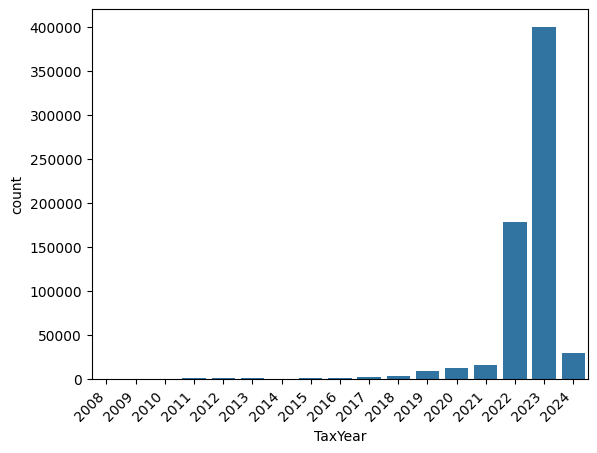

In [441]:
ax = sns.barplot(data=yearDist, x='TaxYear', y='count')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

### EDA of outcome variable
This section explores the outcome variable (fundraising revenue), the predictor variable (total revenue), and the relationship between the two. In particular, this EDA looks at ways of transforming the variables to account for skew, so that linear regression can function correctly when applied.

In [442]:
# First, remove those cases with 0 revenue because they will throw things off
# for micro
data = data[data.FundraisingRevenue > 0]
data = data[data.SegmentName != 'None']
data = data.dropna(subset=['SegmentName', 'SegmentName2'])

In [443]:
# Create simple options for normalized version of revenue
data['LogTotalRevenue'] = np.log(data.CauseIQTotalRevenue)
data['LogFundraisingRevenue'] = np.log(data.FundraisingRevenue)

# Apply Box-Cox transformation by group for one model per segment
def boxcox(data, var, lName, transName, segmentCol = 'SegmentName'):
  uniqueSegments = data[segmentCol].unique()
  uniqueSegments = [x for x in uniqueSegments if x is not None]
  segDataList = []
  for segName in uniqueSegments:
    segData = data[data[segmentCol] == segName]
    s = segData[var]
    bct = stats.boxcox(s)
    segData[lName] = bct[1]
    print(segName)
    print(bct[1])
    segData[transName] = bct[0]
    segDataList.append(segData)
  segDataConcat = pd.concat(segDataList)
  return segDataConcat

def boxcoxLambda(s) -> np.array:
    bct = stats.boxcox(s)
    return bct[1]

In [444]:
# 4-level segments
dataTransform = boxcox(data, 'CauseIQTotalRevenue', 'xLambda',
                       'BySegBoxCoxTotalRevenue')
print(data.shape) # Double check how many rows are lost due to no segment name
print(dataTransform.shape)
dataTransform = boxcox(dataTransform, 'FundraisingRevenue', 'yLambda',
                       'BySegBoxCoxFundraisingRevenue')

# # 3-level segments
dataTransform = boxcox(dataTransform, 'CauseIQTotalRevenue', 'xLambda2',
                       'BySegBoxCoxTotalRevenue2', 'SegmentName2')
dataTransform = boxcox(dataTransform, 'FundraisingRevenue', 'yLambda2',
                       'BySegBoxCoxFundraisingRevenue2', 'SegmentName2')

/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]


Medium
-0.3946906107997488


/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]


Small
-0.30254007796689353


/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Micro
0.5466757011078438
Large
-0.6200093888687054
(491978, 68)
(491978, 70)


/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]


Medium
0.2613934916446243


/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]


Small
0.31315278917183326


/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Micro
0.3194446391918816
Large
0.11145264105810909


/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]


MediumSmall
-0.3258183216150026


/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Micro
0.5466757011078438
Large
-0.6200093888687054


/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]


MediumSmall
0.12933365756858603
Micro
0.3194446391918816
Large
0.11145264105810909


/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[lName] = bct[1]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segData[transName] = bct[0]
/var/folders/3s/61ynz9t96wn0xs3dbklz1ln00000gp/T/ipykernel_1409/465432058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [445]:
# Look at the lambdas for input and output transformation
dataTransform[['xLambda', 'yLambda']]

xLambda   yLambda
0      -0.394691  0.261393
9      -0.394691  0.261393
10     -0.394691  0.261393
42     -0.394691  0.261393
43     -0.394691  0.261393
...          ...       ...
652909 -0.620009  0.111453
652918 -0.620009  0.111453
653001 -0.620009  0.111453
653035 -0.620009  0.111453
653061 -0.620009  0.111453

[491978 rows x 2 columns]

In [446]:
# Looks good (we only lost a few hundred rows to no segment)
# so let's continue using this as the dataset
data = dataTransform

### Segment counts and summary stats

In [447]:
## Counts and bar chart of segment counts
seg_counts = data.SegmentName.value_counts()
seg_counts

SegmentName
Small     205858
Micro     194325
Medium     72452
Large      19343
Name: count, dtype: int64

<Axes: xlabel='SegmentName', ylabel='count'>

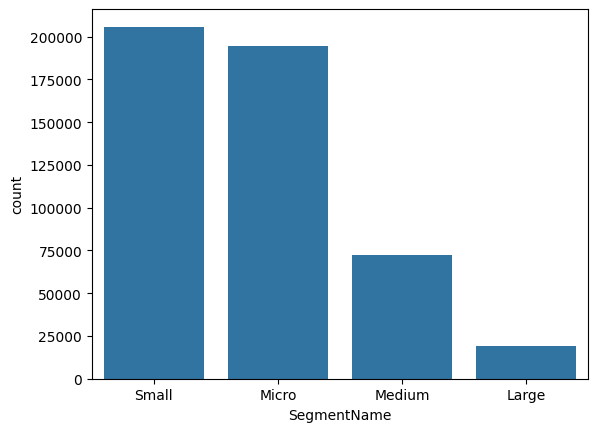

In [448]:
# What is the overall distribution of segment categories?
# Many small and micro
sns.barplot(seg_counts)

In [449]:
## Overall average, median, std of total revenue, fundraising revenue, online revenue prop
data[['CauseIQTotalRevenue', 'FundraisingRevenue']].agg(['mean', 'median', 'std'])

CauseIQTotalRevenue  FundraisingRevenue
mean           2.718303e+06        7.827881e+05
median         1.517615e+05        6.744050e+04
std            2.238959e+07        8.590815e+06

In [450]:
## Overall average, median, std of total revenue, fundraising, prop facet by segment
data.groupby('SegmentName')[['CauseIQTotalRevenue', 'FundraisingRevenue']].agg(['mean', 'median', 'std'])

CauseIQTotalRevenue                           FundraisingRevenue  \
                           mean      median           std               mean   
SegmentName                                                                    
Large              5.358181e+07  22412230.0  1.000595e+08       1.275314e+07   
Medium             3.104051e+06   2269502.0  2.181207e+06       1.312890e+06   
Micro              4.296561e+04     41686.0  2.974259e+04       2.873774e+04   
Small              3.287129e+05    244053.0  2.262396e+05       1.832555e+05   

                                      
                median           std  
SegmentName                           
Large        2445683.0  4.139520e+07  
Medium        855588.5  1.582526e+06  
Micro          20000.0  2.688343e+04  
Small         126655.0  1.862590e+05

### Total Revenue (predictor)
Both raw and transformed

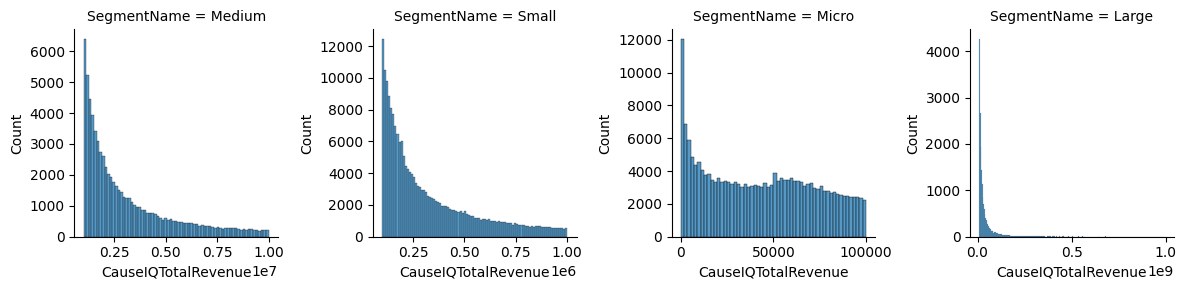

In [451]:
## Histogram of total revenue facet by segment
g = sns.FacetGrid(data,
                  col="SegmentName",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'Small', 'Medium', 'Large'])
g.map(sns.histplot, 'CauseIQTotalRevenue')

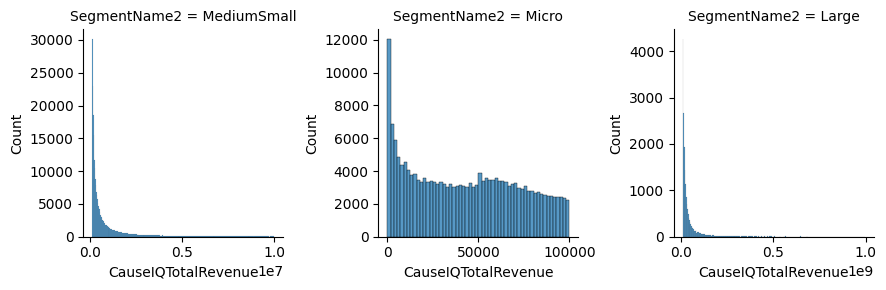

In [452]:
## Histogram of total revenue facet by segment combining medium and small
g = sns.FacetGrid(data,
                  col="SegmentName2",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'MediumSmall', 'Large'])
g.map(sns.histplot, 'CauseIQTotalRevenue')

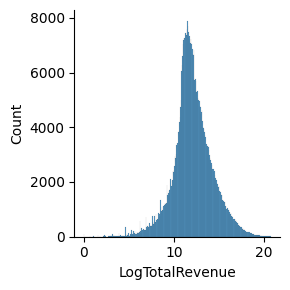

In [453]:
# Overall log -- nice!
# This indicates that a simple log transformation (no need for BoxCox)
# would likely suffice for the overall model which combines all segments into one.
# The normality here is an argument for using linear regression.
g = sns.FacetGrid(data,
                  sharex=False,
                  sharey=False)
g.map(sns.histplot, 'LogTotalRevenue')

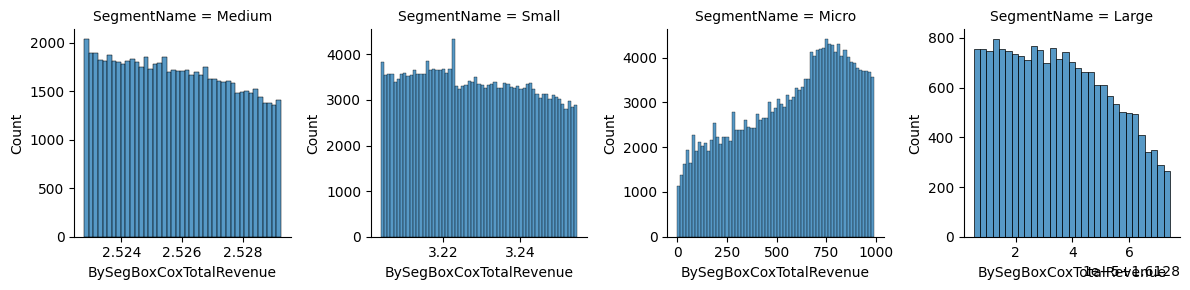

In [454]:
# Histogram of Box-Cox total revenue facet by segment
# This corrects non-normality by segment group
# A simple log transform did not work but a BoxCox does somewhat better
# The overall (all segments combined) with a log transform is still better
g = sns.FacetGrid(data,
                  col="SegmentName",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'Small', 'Medium', 'Large'])
g.map(sns.histplot, 'BySegBoxCoxTotalRevenue')

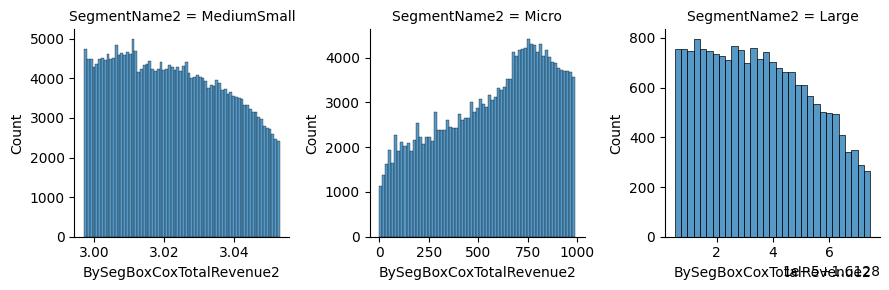

In [455]:
# Histogram of Box-Cox total revenue facet by segment2
# This corrects non-normality by segment group
# A simple log transform did not work but a BoxCox does somewhat better
# The overall (all segments combined) with a log transform is still better
g = sns.FacetGrid(data,
                  col="SegmentName2",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'MediumSmall', 'Large'])
g.map(sns.histplot, 'BySegBoxCoxTotalRevenue2')

### Fundraising Revenue (outcome)
Both raw and transformed

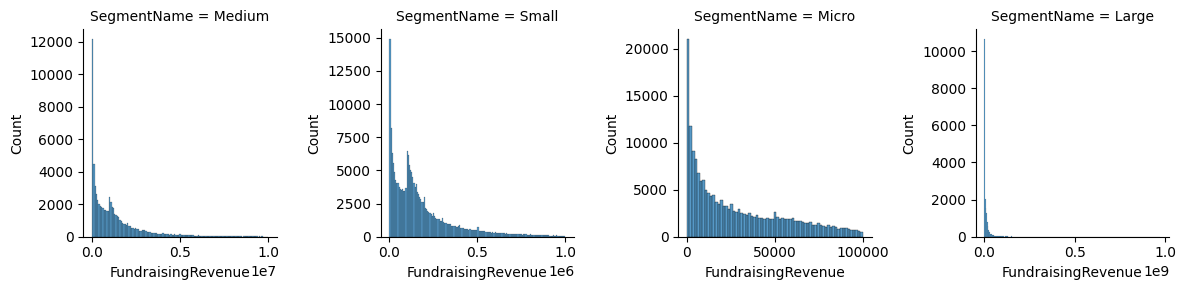

In [456]:
## Histogram of online revenue facet by segment
g = sns.FacetGrid(data,
                  col="SegmentName",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'Small', 'Medium', 'Large'])
g.map(sns.histplot, 'FundraisingRevenue')

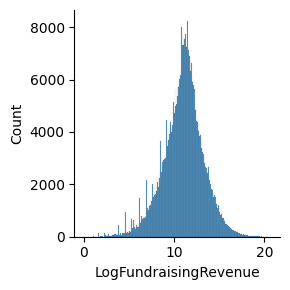

In [457]:
# Overall log -- nice -- LOG TRANSFORMED
# A basic log transform works well for all segments together
g = sns.FacetGrid(data,
                  sharex=False,
                  sharey=False)
g.map(sns.histplot, 'LogFundraisingRevenue')

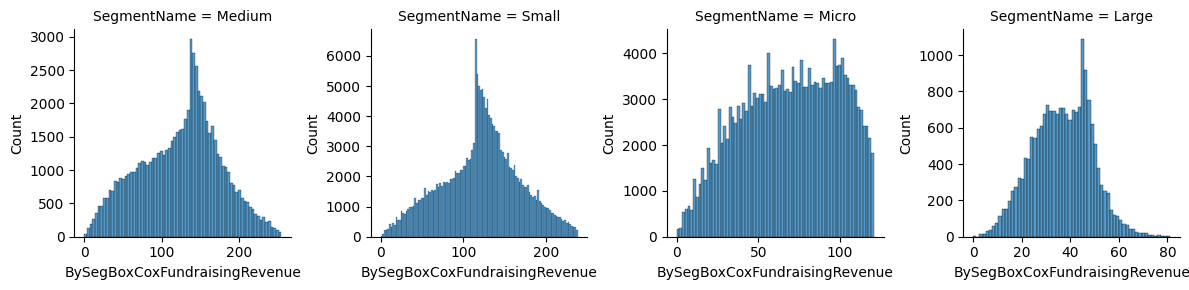

In [458]:
## Histogram of box cox online revenue facet by segment -- BOX-COX TRANSFORMED
g = sns.FacetGrid(data,
                  col="SegmentName",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'Small', 'Medium', 'Large'])
g.map(sns.histplot, 'BySegBoxCoxFundraisingRevenue')

### Total vs. fundraising revenue (predictor vs. outcome)

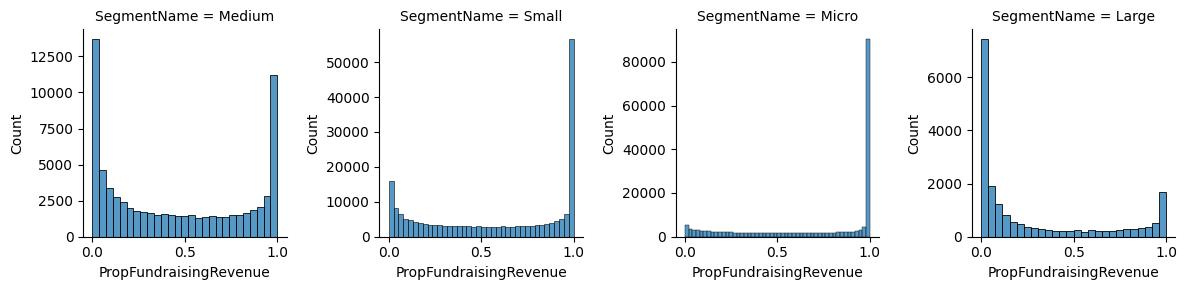

In [459]:
## Histogram of fundraising prop facet by segment
# This is interesting because there are so many that get all or none from
# fundraising
g = sns.FacetGrid(data,
                  col="SegmentName",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'Small', 'Medium', 'Large'])
g.map(sns.histplot, 'PropFundraisingRevenue')

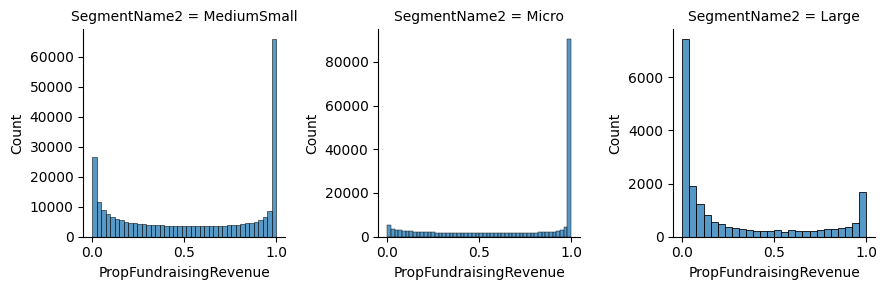

In [460]:
## Histogram of online revenue prop facet by segment2
# This is interesting because there are so many that get all or none from
# fundraising
g = sns.FacetGrid(data,
                  col="SegmentName2",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'MediumSmall', 'Large'])
g.map(sns.histplot, 'PropFundraisingRevenue')

<Axes: xlabel='CauseIQTotalRevenue', ylabel='FundraisingRevenue'>

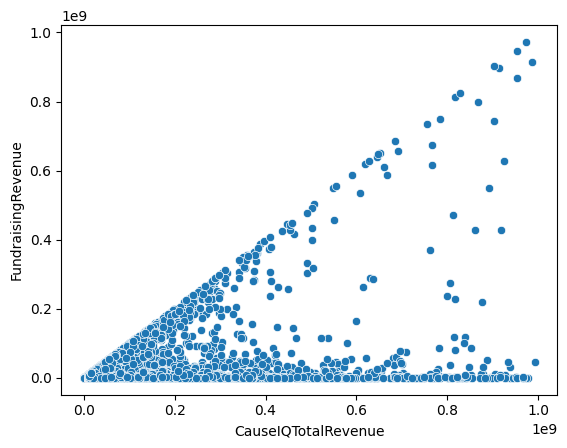

In [461]:
## Plot of FundraisingRevenue as a function of TotalRevenue overall
sns.scatterplot(data, x='CauseIQTotalRevenue', y='FundraisingRevenue')

<Axes: xlabel='LogTotalRevenue', ylabel='LogFundraisingRevenue'>

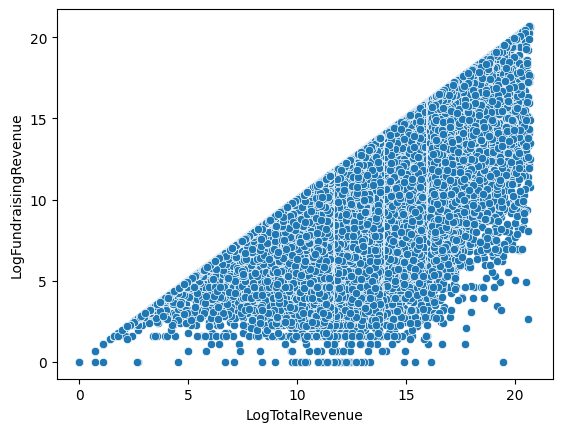

In [462]:
## Transformed via log: Plot of FundraisingRevenue as a function of
# TotalRevenue overall -- LOG TRANSFORMED
sns.scatterplot(data, x='LogTotalRevenue', y='LogFundraisingRevenue')

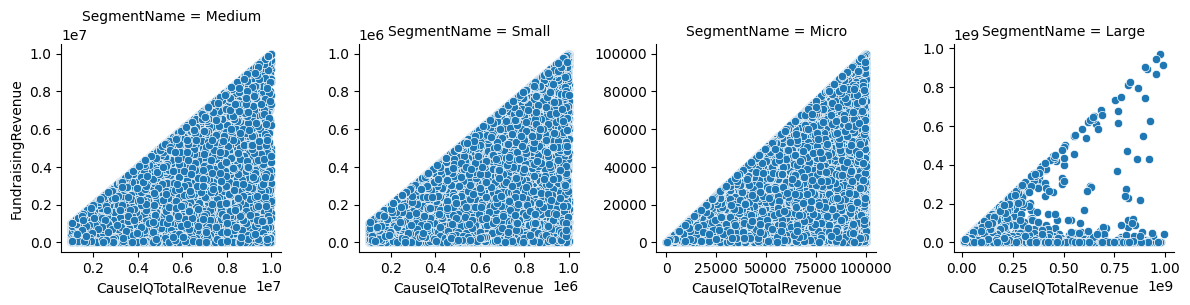

In [463]:
# Plot of OnlineRevenue as a function of TotalRevenue facet by segment
g = sns.FacetGrid(data,
                  col="SegmentName",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'Small', 'Medium', 'Large'])
g.map(sns.scatterplot, 'CauseIQTotalRevenue', 'FundraisingRevenue')

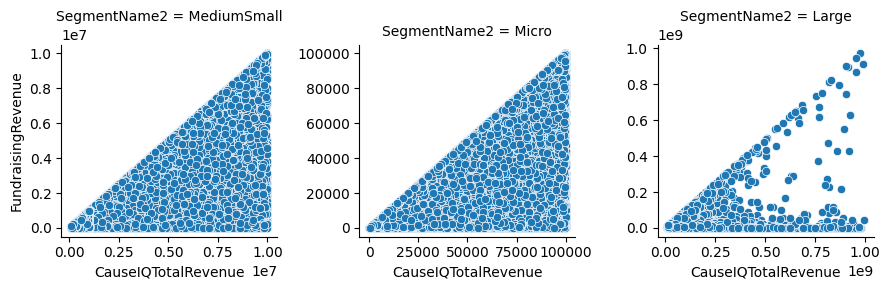

In [464]:
# Plot of OnlineRevenue as a function of TotalRevenue facet by segment2
g = sns.FacetGrid(data,
                  col="SegmentName2",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'MediumSmall', 'Large'])
g.map(sns.scatterplot, 'CauseIQTotalRevenue', 'FundraisingRevenue')

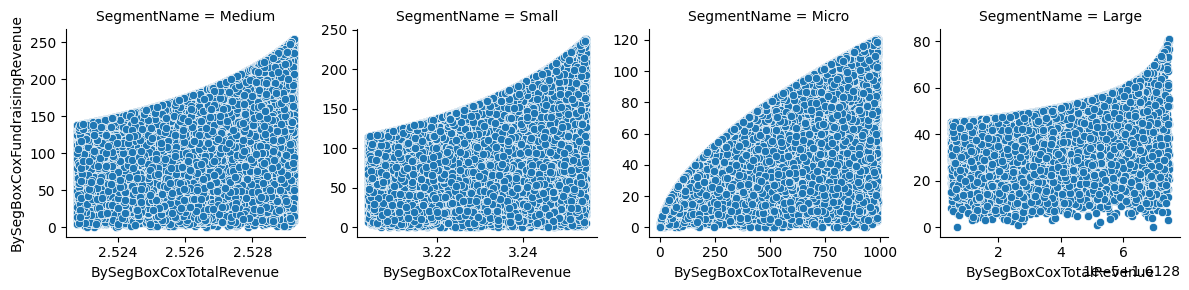

In [465]:
# Plot of boxcox FundraisingRevenue as a function of boxcox TotalRevenue facet by
# segment -- BOX-COX TRANSFORMED
g = sns.FacetGrid(data,
                  col="SegmentName",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'Small', 'Medium', 'Large'])
g.map(sns.scatterplot, 'BySegBoxCoxTotalRevenue', 'BySegBoxCoxFundraisingRevenue')

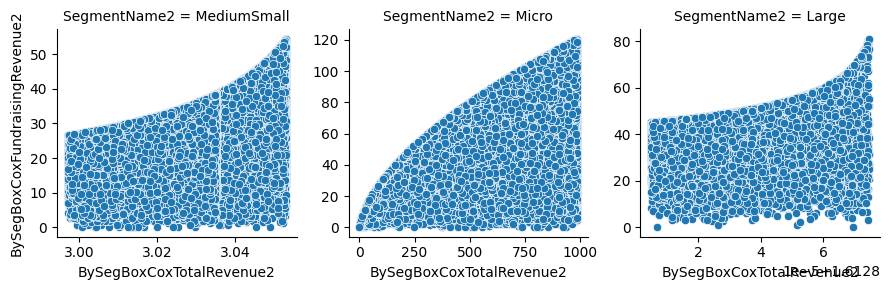

In [466]:
# Plot of boxcox FundraisingRevenue as a function of boxcox TotalRevenue facet by
# segment2 -- BOX-COX TRANSFORMED
g = sns.FacetGrid(data,
                  col="SegmentName2",
                  sharex=False,
                  sharey=False,
                  row_order=['Micro', 'MediumSmall', 'Large'])
g.map(sns.scatterplot, 'BySegBoxCoxTotalRevenue2', 'BySegBoxCoxFundraisingRevenue2')

### Fit a trend line

Some notes:
- Since we are fitting a fairly straightforward trendline with one outcome variable and one predictor variable, linear regression suggests itself as the most obvious approach
- Since the data is non-normal, transformed data is used instead. This means that outputs of the trendline should be back-transformed to get back to the original unit of measurement ($).
- Since the purpose of this exercise is to fit a trend line, and not to predict future fundraising revenue as a function of future total revenue, a test/train split is not used. This is important! In many machine learning applications, we want to predict future outcomes and so we need a test/train split in order to evaluate how well the model performs on unseen data. However, in this case, we are not trying to predict the future fundraising revenue. We are trying to understand current customers as they relate to how much they exceed the trendline. Therefore, *we want as much data as possible* in order to make the trendline as robust as possible. For that reason, the entire dataset is used and not the test set only.

Arguments in favor of a single model:
- It was straightforward to achieve normality for the total distribution using a simple log transformation. Even with a more complicated Box-Cox, though, the by-segment groups were not normal, meaning they do not satisfy the conditions of linear regression and the fit could be bad.
- The full distribution naturally progresses smoothly from one dollar amount to another. The by-segment is hard to fit because cutting by segment necessarily cuts the revenue off sharply, which is harder to work with.
- As will be shown later, using a by-segment model creates some bizarrely extreme outliers, perhaps due to poor model fit.

For all of the above reasons, it is recommended to use the one model which combines all segments.

In [467]:
def make_linear_trend(data, x, y, segment = None,
                      segmentCol = 'SegmentName', fit_intercept=True):
  # Filter to desire segment, if any
  if segment is not None:
    seg = data[data[segmentCol] == segment]
  else:
    seg = data
  # Prepare variables
  segX = seg[[x]]
  segY = seg[y]
  # Fit model
  segModel = LinearRegression(fit_intercept=fit_intercept)
  segModel.fit(segX, segY)
  # Predict back on variables to get trendline points
  segPred = segModel.predict(segX)
  # Format and rejoin predictions to filtered dataset
  segTrend = pd.DataFrame({'pred': segPred.tolist()})
  segTrend['x'] = seg[[x]].values
  segTrend['y'] = seg[y].values
  if segment is not None:
    segTrend['segment'] = segment
  else:
    segTrend['segment'] = 'all'
  segConcat = pd.concat([seg.reset_index(drop=True),
                         segTrend.reset_index(drop=True)],
                        axis=1)
  return segConcat, segModel

<Axes: xlabel='LogTotalRevenue', ylabel='LogFundraisingRevenue'>

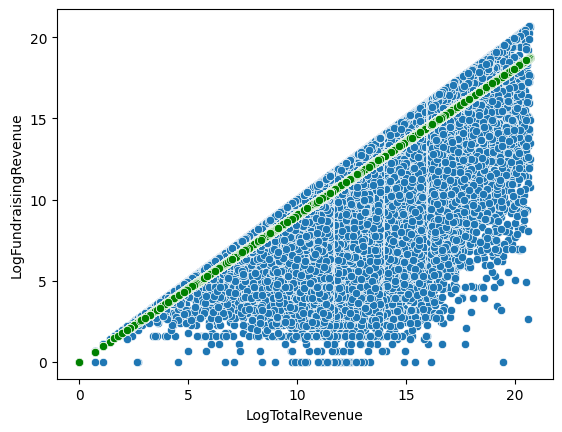

In [468]:
# One overall model -- seems good
# Note that we force the intercept through 0
allTrend, allModel =\
  make_linear_trend(data,
                    'LogTotalRevenue',
                    'LogFundraisingRevenue',
                    None,
                    fit_intercept=False)
fig, ax = plt.subplots()
sns.scatterplot(x='LogTotalRevenue', y='LogFundraisingRevenue', data=allTrend, ax=ax)
sns.scatterplot(data=allTrend, x='x', y='pred', ax=ax, color='g')

<Axes: xlabel='BySegBoxCoxTotalRevenue', ylabel='BySegBoxCoxFundraisingRevenue'>

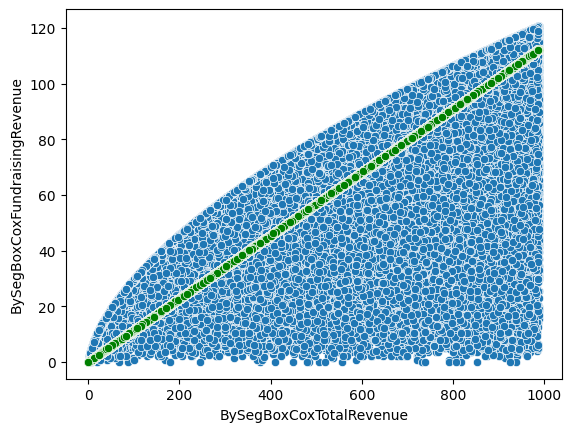

In [469]:
# Plot trend line for micro
# Note that we force the intercept through 0
microTrend, microModel =\
  make_linear_trend(data,
                    'BySegBoxCoxTotalRevenue',
                    'BySegBoxCoxFundraisingRevenue',
                    'Micro',
                    fit_intercept=False)
fig, ax = plt.subplots()
sns.scatterplot(x='BySegBoxCoxTotalRevenue', y='BySegBoxCoxFundraisingRevenue', data=microTrend, ax=ax)
sns.scatterplot(data=microTrend, x='x', y='pred', ax=ax, color='g')

<Axes: xlabel='BySegBoxCoxTotalRevenue', ylabel='BySegBoxCoxFundraisingRevenue'>

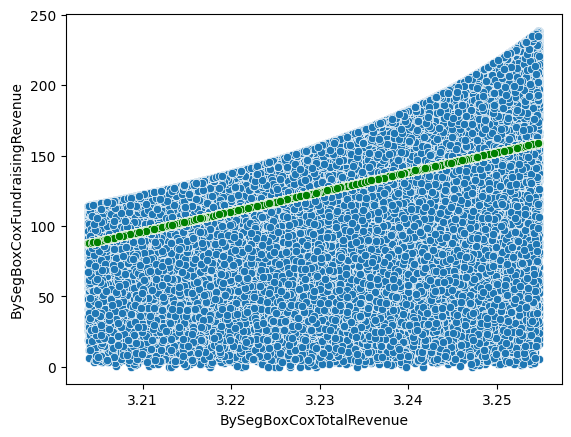

In [470]:
# Plot trend line for small
# We do not force an intercept of 0 for any other segments
smallTrend, smallModel =\
  make_linear_trend(data,
                    'BySegBoxCoxTotalRevenue',
                    'BySegBoxCoxFundraisingRevenue',
                    'Small',
                    fit_intercept=True)
fig, ax = plt.subplots()
sns.scatterplot(x='BySegBoxCoxTotalRevenue', y='BySegBoxCoxFundraisingRevenue', data=smallTrend, ax=ax)
sns.scatterplot(data=smallTrend, x='x', y='pred', ax=ax, color='g')

<Axes: xlabel='BySegBoxCoxTotalRevenue', ylabel='BySegBoxCoxFundraisingRevenue'>

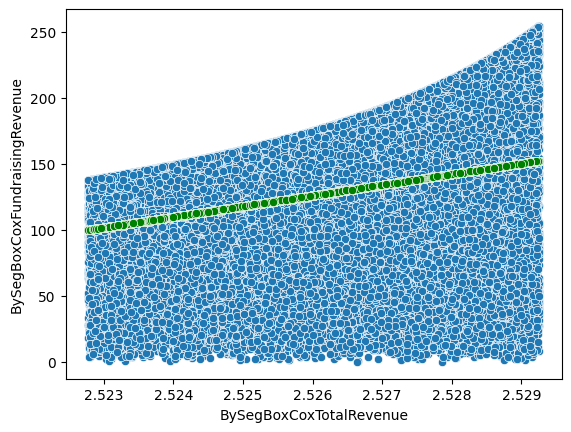

In [471]:
# Plot trend line for medium
# We do not force an intercept of 0 for any other segments
mediumTrend, mediumModel =\
  make_linear_trend(data,
                    'BySegBoxCoxTotalRevenue',
                    'BySegBoxCoxFundraisingRevenue',
                    'Medium',
                    fit_intercept=True)
fig, ax = plt.subplots()
sns.scatterplot(x='BySegBoxCoxTotalRevenue', y='BySegBoxCoxFundraisingRevenue', data=mediumTrend, ax=ax)
sns.scatterplot(data=mediumTrend, x='x', y='pred', ax=ax, color='g')

<Axes: xlabel='BySegBoxCoxTotalRevenue2', ylabel='BySegBoxCoxFundraisingRevenue2'>

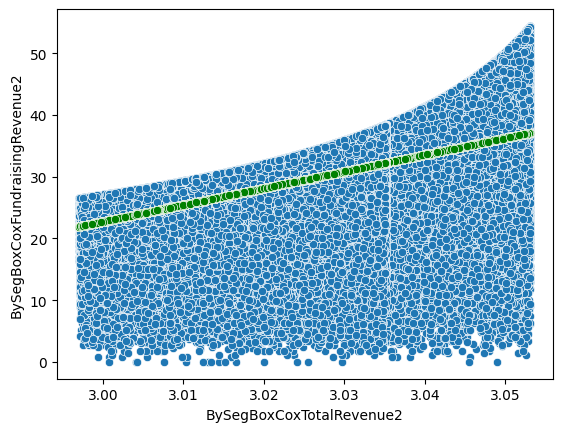

In [472]:
## Make trendline for medium
mediumSmallTrend, mediumSmallModel =\
  make_linear_trend(data,
                    'BySegBoxCoxTotalRevenue2',
                    'BySegBoxCoxFundraisingRevenue2',
                    'MediumSmall',
                    segmentCol = 'SegmentName2',
                    fit_intercept=True)
fig, ax = plt.subplots()
sns.scatterplot(x='BySegBoxCoxTotalRevenue2', y='BySegBoxCoxFundraisingRevenue2',
                data=mediumSmallTrend, ax=ax)
sns.scatterplot(data=mediumSmallTrend, x='x', y='pred', ax=ax, color='g')

<Axes: xlabel='BySegBoxCoxTotalRevenue', ylabel='BySegBoxCoxFundraisingRevenue'>

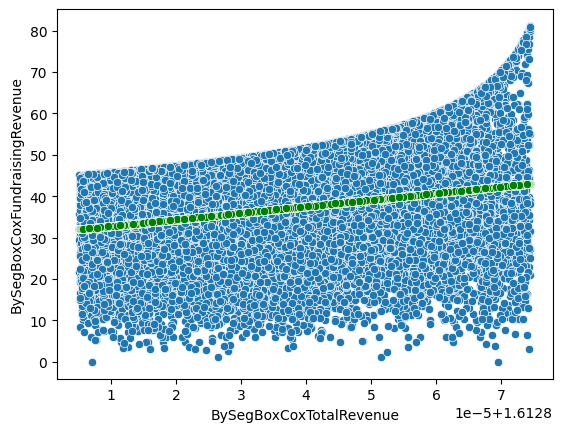

In [473]:
## Make trendline for large
largeTrend, largeModel =\
  make_linear_trend(data,
                    'BySegBoxCoxTotalRevenue',
                    'BySegBoxCoxFundraisingRevenue',
                    'Large',
                    fit_intercept=True)
fig, ax = plt.subplots()
sns.scatterplot(x='BySegBoxCoxTotalRevenue', y='BySegBoxCoxFundraisingRevenue', data=largeTrend, ax=ax)
sns.scatterplot(data=largeTrend, x='x', y='pred', ax=ax, color='g')

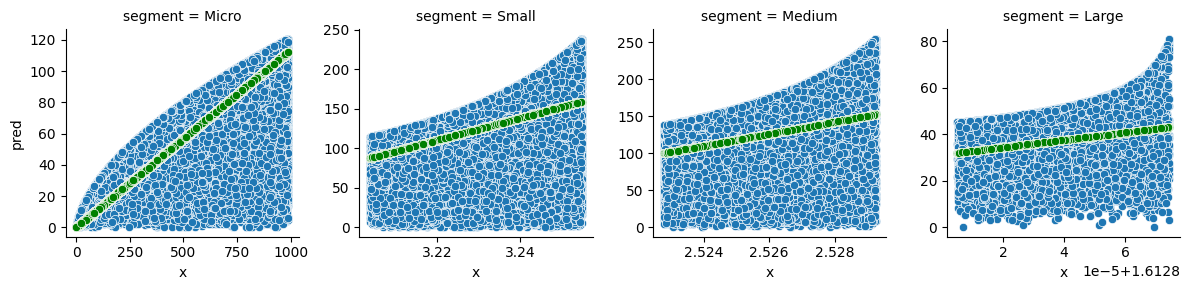

In [474]:
# Add a visualization of all segment trend lines on a single chart
bySegTrend = pd.concat([microTrend, smallTrend, mediumTrend, largeTrend], axis=0)
g = sns.FacetGrid(bySegTrend,
                  col = "segment",
                  sharex = False,
                  sharey = False,
                  row_order=['Micro', 'Small', 'Medium', 'Large'])
g.map(sns.scatterplot, 'x', 'y')
g.map(sns.scatterplot, 'x', 'pred', color='g')

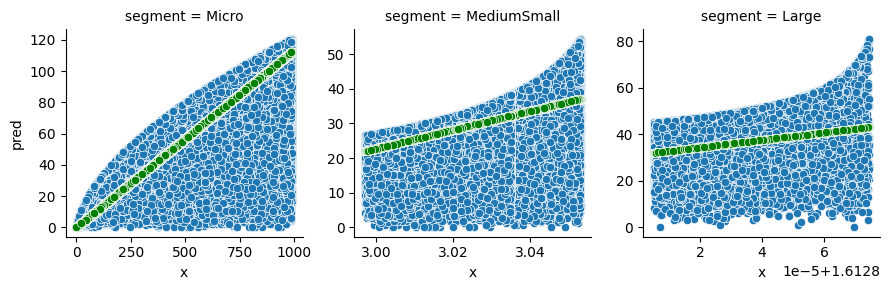

In [475]:
# Add a visualization of all segment 2 trend lines on a single chart
bySegTrend2 = pd.concat([microTrend, mediumSmallTrend, largeTrend], axis=0)
g = sns.FacetGrid(bySegTrend2,
                  col = "segment",
                  sharex = False,
                  sharey = False,
                  row_order=['Micro', 'MediumSmall', 'Large'])
g.map(sns.scatterplot, 'x', 'y')
g.map(sns.scatterplot, 'x', 'pred', color='g')

In [476]:
# Print out model coeffs to determine if small and medium can be combined
# Remember that the data is log-transformed
# TODO figure out why the intercepts are all negative
print(allModel.intercept_)
print(allModel.coef_)

print(microModel.intercept_)
print(microModel.coef_)

print(smallModel.intercept_)
print(smallModel.coef_)

print(mediumModel.intercept_)
print(mediumModel.coef_)

print(mediumSmallModel.intercept_)
print(mediumSmallModel.coef_)

print(largeModel.intercept_)
print(largeModel.coef_)

0.0
[0.90516714]
0.0
[0.11361755]
-4399.4211097778825
[1400.52597011]
-20317.927748784736
[8093.42787674]
-789.6553932214764
[270.79450981]
-255972.00262268278
[158732.13834288]


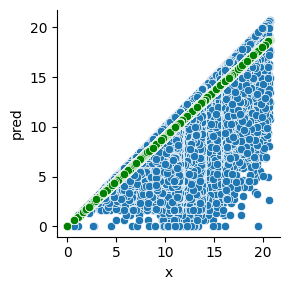

In [477]:
# Repeat overall for comparison
g = sns.FacetGrid(allTrend,
                  sharex = False,
                  sharey = False)
g.map(sns.scatterplot, 'x', 'y')
g.map(sns.scatterplot, 'x', 'pred', color='g')

In [478]:
# Undo logarithm for interpretability
def expData(data, x, y, pred):
  data['xUntrans'] = np.exp(data[x])
  data['yUntrans'] = np.exp(data[y])
  data['predUntrans'] = np.exp(data[pred])
  return data

# Undo BoxCox for by-seg models for interpretability
def reverseBoxCox(data, x, y, pred, lX, lY):
  # There are no zero cases so we can skip that box cox condition
  data['xUntrans'] = inv_boxcox(data[x], data[lX])
  data['yUntrans'] = inv_boxcox(data[y], data[lY])
  data['predUntrans'] = inv_boxcox(data[pred], data[lY])
  return data

In [479]:
# Apply exp to the one-model approach and double check values
# Expect xExp = CauseIQTotalRevenue and yExp = OnlineRevenue
allTrend = expData(allTrend, 'x', 'y', 'pred')
allTrend[['CauseIQTotalRevenue', 'xUntrans', 'FundraisingRevenue', 'yUntrans', 'predUntrans']]

CauseIQTotalRevenue    xUntrans  FundraisingRevenue    yUntrans  \
0                 1555685.0   1555685.0           1100500.0   1100500.0   
1                 8793337.0   8793337.0           1141518.0   1141518.0   
2                 8825922.0   8825922.0            874980.0    874980.0   
3                 1984488.0   1984488.0            291370.0    291370.0   
4                 7135621.0   7135621.0             97277.0     97277.0   
...                     ...         ...                 ...         ...   
491973           59294231.0  59294231.0           2879773.0   2879773.0   
491974           10635899.0  10635899.0           6486123.0   6486123.0   
491975           16032112.0  16032112.0          14859381.0  14859381.0   
491976           94355130.0  94355130.0           4046484.0   4046484.0   
491977           14905436.0  14905436.0          14905436.0  14905436.0   

         predUntrans  
0       4.024612e+05  
1       1.930278e+06  
2       1.936751e+06  
3       5.016773e+05  
4       1.597722e+06  
...              ...  
491973  1.086114e+07  
491974  2.293006e+06  
491975  3.324458e+06  
491976  1.653848e+07  
491977  3.112260e+06  

[491978 rows x 5 columns]

In [480]:
# Apply reverse box-cox to by-seg model and check values
bySegTrend =\
 reverseBoxCox(bySegTrend,
               'x',
               'y',
               'pred',
               'xLambda',
               'yLambda')
bySegTrend[['CauseIQTotalRevenue',
            'xLambda',
            'x',
            'xUntrans',
            'FundraisingRevenue',
            'yLambda',
            'y',
            'yUntrans',
            'predUntrans']]

CauseIQTotalRevenue   xLambda           x      xUntrans  \
0                  69499.0  0.546676  809.621671  6.949900e+04   
1                  89633.0  0.546676  930.703546  8.963300e+04   
2                  67995.0  0.546676  799.974302  6.799500e+04   
3                   3158.0  0.546676  147.902480  3.158000e+03   
4                  15850.0  0.546676  359.850495  1.585000e+04   
...                    ...       ...         ...           ...   
19338           59294231.0 -0.620009    1.612854  5.929423e+07   
19339           10635899.0 -0.620009    1.612808  1.063590e+07   
19340           16032112.0 -0.620009    1.612824  1.603211e+07   
19341           94355130.0 -0.620009    1.612860  9.435513e+07   
19342           14905436.0 -0.620009    1.612821  1.490544e+07   

       FundraisingRevenue   yLambda           y    yUntrans   predUntrans  
0                 46155.0  0.319445   93.600210     46155.0  4.378824e+04  
1                 89633.0  0.319445  116.445486     89633.0  6.683543e+04  
2                 67995.0  0.319445  106.344140     67995.0  4.222792e+04  
3                  3158.0  0.319445   37.934663      3158.0  3.287669e+02  
4                 15550.0  0.319445   65.202522     15550.0  3.924181e+03  
...                   ...       ...         ...         ...           ...  
19338           2879773.0  0.111453   38.106031   2879773.0  3.967419e+06  
19339           6486123.0  0.111453   42.565082   6486123.0  9.106877e+05  
19340          14859381.0  0.111453   47.553554  14859381.0  1.550382e+06  
19341           4046484.0  0.111453   39.924995   4046484.0  4.734930e+06  
19342          14905436.0  0.111453   47.573053  14905436.0  1.427204e+06  

[491978 rows x 9 columns]

In [481]:
bySegTrend2 =\
 reverseBoxCox(bySegTrend,
               'x',
               'y',
               'pred',
               'xLambda2',
               'yLambda2')
bySegTrend2[['CauseIQTotalRevenue',
            'xLambda2',
            'x',
            'xUntrans',
            'FundraisingRevenue',
            'yLambda2',
            'y',
            'yUntrans',
            'predUntrans']]

CauseIQTotalRevenue  xLambda2           x      xUntrans  \
0                  69499.0  0.546676  809.621671  6.949900e+04   
1                  89633.0  0.546676  930.703546  8.963300e+04   
2                  67995.0  0.546676  799.974302  6.799500e+04   
3                   3158.0  0.546676  147.902480  3.158000e+03   
4                  15850.0  0.546676  359.850495  1.585000e+04   
...                    ...       ...         ...           ...   
19338           59294231.0 -0.620009    1.612854  5.929423e+07   
19339           10635899.0 -0.620009    1.612808  1.063590e+07   
19340           16032112.0 -0.620009    1.612824  1.603211e+07   
19341           94355130.0 -0.620009    1.612860  9.435513e+07   
19342           14905436.0 -0.620009    1.612821  1.490544e+07   

       FundraisingRevenue  yLambda2           y    yUntrans   predUntrans  
0                 46155.0  0.319445   93.600210     46155.0  4.378824e+04  
1                 89633.0  0.319445  116.445486     89633.0  6.683543e+04  
2                 67995.0  0.319445  106.344140     67995.0  4.222792e+04  
3                  3158.0  0.319445   37.934663      3158.0  3.287669e+02  
4                 15550.0  0.319445   65.202522     15550.0  3.924181e+03  
...                   ...       ...         ...         ...           ...  
19338           2879773.0  0.111453   38.106031   2879773.0  3.967419e+06  
19339           6486123.0  0.111453   42.565082   6486123.0  9.106877e+05  
19340          14859381.0  0.111453   47.553554  14859381.0  1.550382e+06  
19341           4046484.0  0.111453   39.924995   4046484.0  4.734930e+06  
19342          14905436.0  0.111453   47.573053  14905436.0  1.427204e+06  

[491978 rows x 9 columns]

## Define Outliers
At this point, the focus is on the "one model" approach to fitting a trendline. All analysis pertaining to the by-segment models is removed from here onward. The previous notebook ("_2") contains this information for reference.


### Add outlier distance columns

In [482]:
# Add distance columns, keeping two options for models
def addDiffs(data, pred, y):
  data['Diff'] =\
    data[y] - data[pred]
  data['DiffProp'] = data.Diff / data[pred]
  return data

In [483]:
# Add diffs to untransformed y values
allTrend = addDiffs(allTrend, 'predUntrans', 'yUntrans')
bySegTrend = addDiffs(bySegTrend, 'predUntrans', 'yUntrans')

### EDA of outlier distance and categories

In [484]:
allTrend.Diff.describe()

count    4.919780e+05
mean     2.628009e+05
std      7.484614e+06
min     -1.369998e+08
25%     -8.783825e+03
50%      1.976646e+04
75%      1.014132e+05
max      8.358311e+08
Name: Diff, dtype: float64

<Axes: xlabel='Diff', ylabel='Count'>

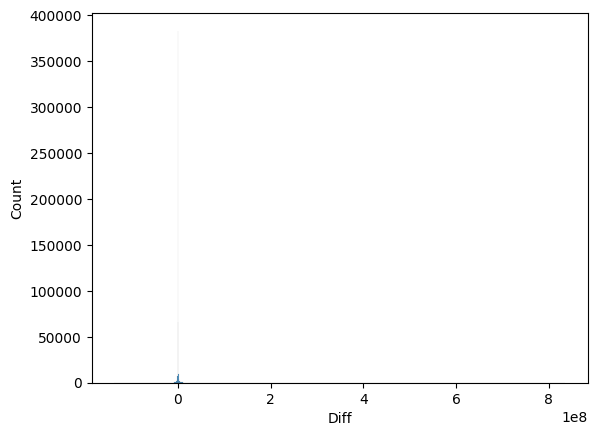

In [485]:
# Overall distribution of diff with one model
sns.histplot(data=allTrend, x='Diff', bins=1000)

<Axes: xlabel='DiffProp', ylabel='Count'>

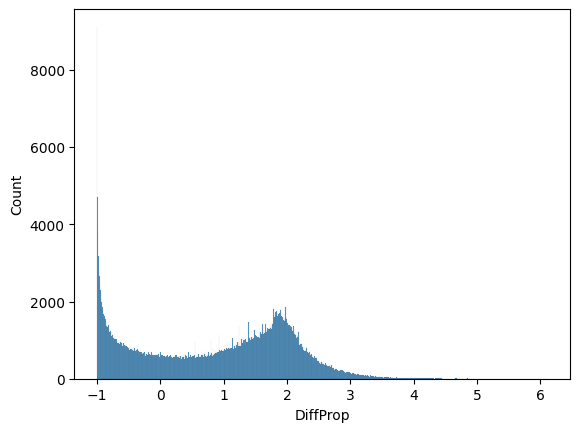

In [486]:
# Overall distribution of diff prop with one model
# This is more useful than looking at the raw amount above due to the long tail.
# Looks like the tail starts in the 3x area
sns.histplot(data=allTrend, x='DiffProp', bins=1000)

### Possible outlier cuts
This section explores possible binary cuts for what makes an extreme overachiever in terms of fundraising revenue (the outliers).

Goals:
- To have a small enough group that they're really outliers
- To have a large enough group that we can do predictive analytics with them, to robustly define who they are and how they are different from other orgs
- To have a sample that roughly mirrors the overall distribution of segments and doesn't allow one segment to dominate
- To have enough of the sample made up of real Qgiv/Bloomerang customers that we can use internal quantitative variables or new qualitative research with this group.

Notes on results:
- The overall "one model" approach seems better for reasons outlined above, and because it lacks extreme and unbelievable outliers. Therefore this section and those after focus on the single model trendline.
- An "x" is an amount above the trendline, defined as (actual - prediction) / prediction. Therefore 0x = a point at the trendline, 1x = a point above the trendline = the trendline amount (100% increase, or double the amount), 2x = a point above the trendline by 2x the trendline (200% increase, or three times the amount), and so on.
- 2x gives an 80/20 split and is good because it represents all the segments except micro and has a lot of past/present customers
- 3x is similar but shrinks that percentage to 98/2
- 4x has bad segment representation and not enough customers

In [487]:
# Add possible proportions over trendline as binary cuts
allTrend['Over2'] = allTrend.DiffProp >= 2.0
allTrend['Over2_5'] = allTrend.DiffProp >= 2.5
allTrend['Over3'] = allTrend.DiffProp >= 3.0
allTrend['Over4'] = allTrend.DiffProp >= 4.0

In [488]:
def getCountsOverX(data, column, group=None, keepOnlyTrue=False):
  if group is None:
    counts = data[column].value_counts().reset_index()
  else:
    counts = data.groupby(group)[column].value_counts().reset_index()
  if keepOnlyTrue:
    counts = counts[counts[column]]
  counts['prop'] = counts['count'] / counts['count'].sum()
  return counts

### Check percentages over/under

In [489]:
# Get value counts for 2 all trend
getCountsOverX(allTrend, 'Over2')

Over2   count      prop
0  False  401134  0.815349
1   True   90844  0.184651

In [490]:
# Get value counts for 3 all trend
getCountsOverX(allTrend, 'Over3')

Over3   count      prop
0  False  483214  0.982186
1   True    8764  0.017814

In [491]:
# Get value counts for 4 all trend
getCountsOverX(allTrend, 'Over4')

Over4   count      prop
0  False  491083  0.998181
1   True     895  0.001819

### Check against overall distribution
This should be used as a secondary decision-maker, after model fit, percentages over/under, and percentages are/aren't customers

In [492]:
# Get overall percentages of segments
# These should be compared to the outlier cuts below
# to make sure nothing is over/under-prepresenting a group
overallSegmentCounts = getCountsOverX(allTrend, 'SegmentName')
overallSegmentCounts

SegmentName   count      prop
0       Small  205858  0.418429
1       Micro  194325  0.394987
2      Medium   72452  0.147267
3       Large   19343  0.039317

In [493]:
# Get value counts for 2 all trend for checking
# Large went from 4 to 5%, medium from 40 to 25%, small from 42 to 70%,
# no micro. So small is over rep'd, medium under, relative to population.
# This does not necessarily mean the model is bad! It may be that certain
# segments actually have different behavior and tend toward outlier status
# more or less.
test2 = getCountsOverX(allTrend, 'Over2', 'SegmentName', True)
test2

SegmentName  Over2  count      prop
1       Large   True   4500  0.049535
3      Medium   True  22604  0.248822
6       Small   True  63740  0.701642

In [494]:
# Get value counts for 3 all trend for checking
# Large went from 4 to 37%, medium from 40 to 62%, no small and micro
test3 = getCountsOverX(allTrend, 'Over3', 'SegmentName', True)
test3

SegmentName  Over3  count      prop
1       Large   True   3311  0.377796
3      Medium   True   5453  0.622204

In [495]:
# Get value counts for 4 all trend for checking
# We lose micro
test4 = getCountsOverX(allTrend, 'Over4', 'SegmentName', True)
test4

SegmentName  Over4  count  prop
1       Large   True    895   1.0

### Check proportion that are/were/could be customers
There are several ways of grouping this. One is by untapped market vs. ever-customer (includes both current and churned customers). Another way is by general (market), where we can then zoom in on ever-customer or current customer vs. churned customer. Still a third way is by untouched market vs. touched (current customer, churned, and prospected with a demo).

One note about "customer" is that this can be viewed at the time of tax reporting in the CauseIQ data (which could be any year), or current customer meaning customer *today*. Most of the analysis here uses "current" at the time of tax reporting in CauseIQ because from the perspective of understanding the data, they were current customers in the point that the measurement was taken. However, from a practical persepctive, we would need to narrow to current customers today for certain use cases (e.g. asking the sales team to reach out to current customers with high off-platform revenue).


In [496]:
# Do we still have a decent number of touched rep'd in outliers?
# 7.4k includes past/present
customerTest2 = getCountsOverX(allTrend, 'Over2', 'Customer')
customerTest2

Customer  Over2  count     prop
0      True  False  13719  0.64472
1      True   True   7560  0.35528

In [497]:
# How many were any-time Bloom touch
# 5.1k
customerTest2Bloom = getCountsOverX(allTrend, 'Over2', 'CustomerBloomerang')
customerTest2Bloom

CustomerBloomerang  Over2  count      prop
0                True  False   9456  0.645108
1                True   True   5202  0.354892

In [498]:
# How many were any-time QGiv touch
# 2.9k
customerTest2Qgiv = getCountsOverX(allTrend, 'Over2', 'CustomerQGiv')
customerTest2Qgiv

CustomerQGiv  Over2   count      prop
0         False  False  395716  0.804337
1         False   True   87936  0.178740
2          True  False    5418  0.011013
3          True   True    2908  0.005911

In [499]:
# How many of those are active at time of tax reporting?
# 5.5k outliers
customerTest2Active = getCountsOverX(allTrend, 'Over2', 'ActiveAnyBQK')
customerTest2Active

ActiveAnyBQK  Over2   count      prop
0         False  False  392513  0.797826
1         False   True   85373  0.173530
2          True  False    8621  0.017523
3          True   True    5471  0.011120

In [500]:
# How many of those are active Bloom at time of tax reporting?
# 3.7k outliers
customerTest2ActiveBloom = getCountsOverX(allTrend, 'Over2', 'ActiveBloom')
customerTest2ActiveBloom

ActiveBloom  Over2   count      prop
0        False  False  395153  0.803192
1        False   True   87163  0.177168
2         True  False    5981  0.012157
3         True   True    3681  0.007482

In [501]:
# How many of those are active QGiv at time of tax reporting?
# 1k
customerTest2ActiveQGiv = getCountsOverX(allTrend, 'Over2', 'ActiveQGiv')
customerTest2ActiveQGiv

ActiveQGiv  Over2   count      prop
0       False  False  398966  0.810943
1       False   True   89711  0.182348
2        True  False    2168  0.004407
3        True   True    1133  0.002303

In [502]:
# Do we still have a decent number of touched rep'd in outliers? 
# 950 any-time touched
customerTest3 = getCountsOverX(allTrend, 'Over3', 'Customer')
customerTest3

Customer  Over3  count      prop
0      True  False  20319  0.954885
1      True   True    960  0.045115

In [503]:
# How many any time Bloom touch?
# 600
customerTest3Bloom = getCountsOverX(allTrend, 'Over3', 'CustomerBloomerang')
customerTest3Bloom

CustomerBloomerang  Over3  count      prop
0                True  False  14047  0.958316
1                True   True    611  0.041684

In [504]:
# How many any time Qgiv touch
# 400
customerTest3Qgiv = getCountsOverX(allTrend, 'Over3', 'CustomerQGiv')
customerTest3Qgiv

CustomerQGiv  Over3   count      prop
0         False  False  475333  0.966167
1         False   True    8319  0.016909
2          True  False    7881  0.016019
3          True   True     445  0.000905

In [505]:
# How many active customers any product at the tax year?
# 700
customerTest3Active = getCountsOverX(allTrend, 'Over3', 'ActiveAnyBQK')
customerTest3Active

ActiveAnyBQK  Over3   count      prop
0         False  False  469825  0.954972
1         False   True    8061  0.016385
2          True  False   13389  0.027215
3          True   True     703  0.001429

In [506]:
# How many active customers at the tax year for Bloom?
# 400
customerTest3ActiveBloom = getCountsOverX(allTrend, 'Over3', 'ActiveBloom')
customerTest3ActiveBloom

ActiveBloom  Over3   count      prop
0        False  False  474003  0.963464
1        False   True    8313  0.016897
2         True  False    9211  0.018722
3         True   True     451  0.000917

In [507]:
# How many active customers at the tax year for Qgiv?
# 200
customerTest3ActiveQGiv = getCountsOverX(allTrend, 'Over3', 'ActiveQGiv')
customerTest3ActiveQGiv

ActiveQGiv  Over3   count      prop
0       False  False  480112  0.975881
1       False   True    8565  0.017409
2        True  False    3102  0.006305
3        True   True     199  0.000404

### Check Bloomerang revenue vs. total fundraising revenue

Bloomerang revenue includes Bloomerang CRM, QGiv, and KFT.

One model:

- The 3.0 cut better differentiates high/low Bloom revenue in line with high/low fundraising market revenue. However, this is not necessarily a point in favor. The fact that orgs tend to be in the outliers at a higher rate if they use our products (as is the case with 2.0) indicates that the products work, which makes sense.

In [508]:
allTrendActiveCustomer =\
 allTrend[(allTrend.BloomerangTotalRevenue > 0) & (allTrend.ActiveAnyBQK)]

<Axes: xlabel='CauseIQTotalRevenue', ylabel='BloomerangTotalRevenue'>

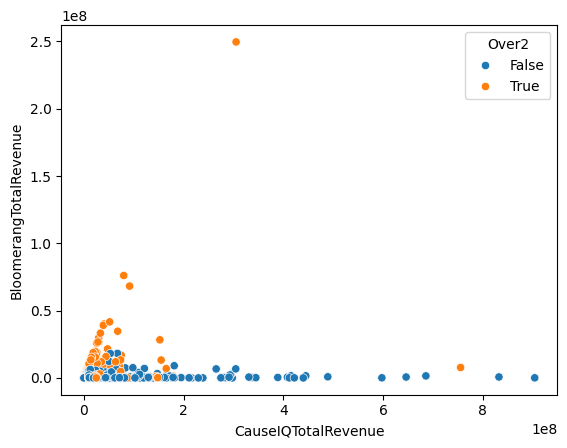

In [509]:
# One model graph of Bloomerang any product revenue vs. total revenue at 2.0 cut,
# color-coding by outlier status
# This shows that most of the outliers in terms of fundraising rev
# are also high on the Bloom rev, although tere are some that
# are not. These represent an opportunity space of high-fundraising
# but low Bloomerang users, i.e. heavy off-platform fundraisers.
# Orange are outliers. Blue are not.
fig, ax = plt.subplots()
sns.scatterplot(data=allTrendActiveCustomer,
                x='CauseIQTotalRevenue',
                y='BloomerangTotalRevenue',
                hue='Over2')

In [510]:
# One model 2
# Outlier vs. not summary stats of Bloomerang revenue vs. all online
# Order of magnitude
sumStats = {'mean', 'median', 'max'}
allTrendActiveCustomer.groupby('Over2').BloomerangTotalRevenue.agg(sumStats)

mean          max     median
Over2                                      
False  3.374827e+05   18211400.1   80212.00
True   1.049625e+06  249573212.8  363860.92

In [511]:
# One model 3 -- stronger differentiation
# Outlier vs. not summary stats of Bloomerang revenue vs. all online
# One power of ten * 3 larger
allTrendActiveCustomer.groupby('Over3').BloomerangTotalRevenue.agg(sumStats)

mean           max      median
Over3                                        
False  4.311494e+05  3.469940e+07   146304.92
True   4.115090e+06  2.495732e+08  2529486.45

In [512]:
# Repeat counts over/under outlier cutoff
# Roughly 1/3 are below trend, 2/3 are above
# Meaning 2/3 of Bloom customers are outliers, 1/3 are not
# This is a weaker differentiation than the overall 80/20 outlier
# split we see in orgs across all CauseIQ.
customerTest2[customerTest2.Customer]

Customer  Over2  count     prop
0      True  False  13719  0.64472
1      True   True   7560  0.35528

In [513]:
# Repeat counts over/under outlier cutoff at 3
# At this point, the cutoff between Bloom rev and not
# is much clearer, with about about 20 times the amount in
# outliers vs. not. Remember, though, that the 3.0 cut also
# results in overrep of large. 2.0 is an overrep of small.
# So, there is an additional difference there.
customerTest3[customerTest3.Customer]

Customer  Over3  count      prop
0      True  False  20319  0.954885
1      True   True    960  0.045115

In [514]:
# Again but only 0's
cols = ['BloomerangDatabaseName', 'TaxYear', 'CauseIQTotalRevenue',
        'FundraisingRevenue', 'BloomerangTotalRevenue', 'Over2']
noBloomOutliers =\
  allTrend[(allTrend.BloomerangDatabaseName != '') &
          (allTrend.BloomerangTotalRevenue == 0)]
noBloomOutliers[cols]

BloomerangDatabaseName  TaxYear  CauseIQTotalRevenue  \
0                        None     2023            1555685.0   
2                        None     2023            8825922.0   
3                        None     2023            1984488.0   
4                        None     2023            7135621.0   
5                        None     2022            1191979.0   
...                       ...      ...                  ...   
491973                   None     2022           59294231.0   
491974                   None     2023           10635899.0   
491975                   None     2022           16032112.0   
491976                   None     2023           94355130.0   
491977                   None     2022           14905436.0   

        FundraisingRevenue  BloomerangTotalRevenue  Over2  
0                1100500.0                     0.0  False  
2                 874980.0                     0.0  False  
3                 291370.0                     0.0  False  
4                  97277.0                     0.0  False  
5                 529707.0                     0.0  False  
...                    ...                     ...    ...  
491973           2879773.0                     0.0  False  
491974           6486123.0                     0.0  False  
491975          14859381.0                     0.0   True  
491976           4046484.0                     0.0  False  
491977          14905436.0                     0.0   True  

[478101 rows x 6 columns]

In [515]:
aggStats = {'min', 'max', 'median', 'mean', 'std'}
noBloomOutliers[['TaxYear',
                  'CauseIQTotalRevenue',
                  'FundraisingRevenue',
                  'BloomerangTotalRevenue']].agg(aggStats)

TaxYear  CauseIQTotalRevenue  FundraisingRevenue  \
max     2024.000000         9.927384e+08        9.724541e+08   
mean    2022.507435         2.650254e+06        7.613624e+05   
min     2008.000000         1.000000e+00        1.000000e+00   
median  2023.000000         1.455050e+05        6.421500e+04   
std        1.169115         2.233075e+07        8.594594e+06   

        BloomerangTotalRevenue  
max                        0.0  
mean                       0.0  
min                        0.0  
median                     0.0  
std                        0.0

### Conclusions

- Based on overall model fit, normality, etc. from previous sections, the one-model approach is better than a by-segment model
- If we focus on the one-model approach, then choosing an outlier threshold of 2.0 or 3.0 seems best. 4.0 cuts out too many possible segments. 2.0 give an 80/20 split and 3.0 gives a 98/2 split.
- Both options do not match population segments exactly, which is perhaps expected depending on the relationship between segment and outlier status. 2.0 over rep's small, and 3.0 over rep's large. Micro is perhaps not a useful segment for outlier status.
- 3.0 gives a strong differentiation than 2.0 between Bloom rev (as opposed to all fundraising market rev). However, it could be that product effectiveness is what makes orgs with Bloom tend more highly to be above the line. Therefore, this is not necessarily a point in favor of 3.0, and 2.0 is recommended overall.


### Write Outliers to Database

In [516]:
colsToRemove = ['xLambda', 'BySegBoxCoxTotalRevenue', 'xLambda', 'BySegBoxCoxFundraisingRevenue', 'xLambda2', 
                'BySegBoxCoxTotalRevenue2', 'yLambda2', 'BySegBoxCoxFundraisingRevenue2', 'pred', 'x', 'y', 'segment',
                'xUntrans', 'yUntrans', 'predUntrans', 'Over2_5', 'Over3', 'Over4']
[c for c in colsToRemove if c not in allTrend.columns] # Double check

[]

In [517]:
# Write outliers to GBQ for future use
outliersToWrite = allTrend.drop(colsToRemove, axis=1)
outliersToWrite = outliersToWrite[outliersToWrite.Over2]

## Set up GBQ info
dataset_id = 'product_ops'
table_id = 'outliers_orgs_above_trendline_2'
project_id = 'bloomerang-data'
table_ref = client.dataset(dataset_id).table(table_id)
destination_table = f"{project_id}.{dataset_id}.{table_id}"

## Delete GBQ table if it exists
client.delete_table(destination_table, not_found_ok=True)

## Write data back to GBQ
job_config =\
  bigquery.LoadJobConfig(write_disposition =
                         bigquery.WriteDisposition.WRITE_EMPTY)


job = client.load_table_from_dataframe(outliersToWrite,
                                       destination_table,
                                       job_config=job_config)

job.result()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/_pandas_helpers.py:484: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


LoadJob<project=bloomerang-data, location=US, id=95e31722-4979-44ad-b33b-fff868a4eace>

In [518]:
# Write all datapoints to GBQ
allTrendToWrite =\
  allTrend.drop(colsToRemove, axis=1)

## Set up GBQ info
dataset_id = 'product_ops'
table_id = 'outliers_orgs_all_trendline_2'
project_id = 'bloomerang-data'
table_ref = client.dataset(dataset_id).table(table_id)
destination_table = f"{project_id}.{dataset_id}.{table_id}"

## Delete GBQ table if it exists
client.delete_table(destination_table, not_found_ok=True)

## Write data back to GBQ
job_config =\
  bigquery.LoadJobConfig(write_disposition =
                         bigquery.WriteDisposition.WRITE_EMPTY)


job = client.load_table_from_dataframe(allTrendToWrite,
                                       destination_table,
                                       job_config=job_config)

job.result()

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/_pandas_helpers.py:484: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


LoadJob<project=bloomerang-data, location=US, id=4092803d-80b0-42ae-abba-fb0a03390b0b>

# Describe outliers
This section is a high-level summary of the profile of outliers. This is not meant to be an analysis of correlation of variables and outlier status, nor a predictive model of outliers status. That will come in a future section. This section is just to give background information on these outliers and who they tend to be.

Given that there are multiple arguments in favor of using the one model approach and a cutoff somewhere around 2.0, we will proceed with just that.

An important note is that our outliers include non-customers, churned customers, and current customers. This means that for some outliers we have certain types of data available. For example, we have NTEE for everyone, but we only have transaction data for past and current customers.

Another important note is that the way in which "customer" is defined is currently quick and sloppy. It uses our current customer pool, rather than those active at the time of tax reporting in the CauseIQ data. This could be refined in a future iteration of this project.

## Setup

### Bloom org-level variables
This was extracted from the CRM and uploaded into GCS and then GBQ at `product_ops.outliers_features_bloom_static`

In [519]:
# Bloom CRM export to get current org-level variables
# Some tables in the CRM are current-state only and so we get the current snapshot of each org

# Note that this query is run against the CRM and is only listed here in string for for documentation purposes.

bloomStaticExportQuery = """
with LicenseInfo as (
	select
		sum(case when Type = 'Base' and EndDate > current_date() then 1 else 0 end) as hasBaseLicense
        , sum(case when Type = 'Email' and EndDate > current_date() then 1 else 0 end) as hasEmailLicense
        , sum(case when Type = 'File' and EndDate > current_date() then 1 else 0 end) as hasFileLicense
        , sum(case when Type = 'DonorSearch' and EndDate > current_date() then 1 else 0 end) as hasDonorSearchLicense
        , sum(case when Type = 'PhoneSupport' and EndDate > current_date() then 1 else 0 end) as hasPhoneSupportLicense
        , sum(case when Type = 'GoogleSheetsBatchEntry' and EndDate > current_date() then 1 else 0 end) as hasGSBatchEntryLicnse
        , sum(case when Type = 'Kindful' and EndDate > current_date() then 1 else 0 end) as hasKindfulLicense
        , sum(case when Type = 'Membership' and EndDate > current_date() then 1 else 0 end) as hasMembershipLicense
        , sum(case when Type = 'JourneyAutomation' and EndDate > current_date() then 1 else 0 end) as hasJALicnse
	from License
)

, DBInfo as (
	select
		DatabaseName
        , LicenseLevel
        , City
        , State
        , CountryCode
        , AccountingIntegration
        , HasCustomRetention
        , HasActivatedTrueGivers
        , case when FundlyApiKey is not null then true else false end as HasFundly
        , case when AbilaOrgKey is not null or AbilaUserKey is not null then true else false end as HasAbila
        , case when AplosAccountId is not null then true else false end as HasAplos
        , case when ZendeskOrganizationId is not null then true else false end as HasZenDesk
        , NteeCode as NTEELong
        , substring(NteeCode, 1, 1) as NTEE
        , case when MailChimpAccessToken is not null then true else false end as HasMailChimp
        , EmailIntegration
        , GivingLevelMidThreshold
        , GivingLevelMajorThreshold
	from DatabaseInformation)
    
, UserInfo as (
	select count(distinct Id) as NumUsers from UserAccount where IsActive = 1)

select *
from DBInfo
join LicenseInfo
on 1 = 1
join UserInfo
on 1 = 1"""

### Bloom Transaction/Designation Variables
These were extracted from the CRM and uploaded at `product_ops.outliers_features_bloom_annual`

In [520]:
# CRM export to get Bloom designations per org by year, type, method, and if they were rev or not

bloomDesignationExportQuery = """
SELECT
  di.DatabaseName,
  d.Type,
  coalesce(th.MethodType, 'None') as MethodType,
  d.Type in ('Donation', 'RecurringDonationPayment', 'PledgePayment', 'MembershipPayment') as Revenue,
  SUM(d.Amount) AS Amount,
  YEAR(th.Date) as Year 
FROM Designation d
LEFT JOIN TransactionHeader th ON th.Id = d.TransactionId
LEFT JOIN Refund r ON r.TransactionId = th.Id
CROSS JOIN DatabaseInformation di
WHERE
  di.DatabaseName NOT LIKE '%test' AND di.DatabaseName NOT LIKE 'test%' AND di.DatabaseName NOT LIKE '%demodb' AND di.DatabaseName NOT LIKE '%testdb'
  AND th.Date BETWEEN '2012-01-01' AND current_date()
  AND r.Id IS NULL
  AND d.amount > 0
  AND lower(th.CreatedName) NOT LIKE '%conversion%'
GROUP BY Year, Type, Revenue, MethodType
ORDER BY Year, Revenue, Type, MethodType ASC
"""

## NTEE
### Market NTEE

In [521]:
# Most common NTEE is private foundations, then Christian
# then...
nteeCounts = getCountsOverX(allTrend, 'Over2', 'NTEE')
nteeCountsSorted = \
  nteeCounts[nteeCounts.Over2].sort_values('count', ascending=False).reset_index()
nteeCountsSorted

index                                               NTEE  Over2  count  \
0      674                           T20: Private Foundations   True   8448   
1      755                                     X20: Christian   True   7240   
2      589                          Q33: International Relief   True   2673   
3      373                   J40: Labor unions, organizations   True   2509   
4      537                   P20: Human Service Organizations   True   2236   
..     ...                                                ...    ...    ...   
390    773  Y02: Mutual and Membership Benefit Management ...   True      1   
391     70                     Adult, Child Matching Programs   True      1   
392    249  F02: Mental Health and Crisis Intervention Man...   True      1   
393    704  V02: Social Science Management and Technical A...   True      1   
394    399  L02: Housing and Shelter Management and Techni...   True      1   

         prop  
0    0.017172  
1    0.014716  
2    0.005433  
3    0.005100  
4    0.004545  
..        ...  
390  0.000002  
391  0.000002  
392  0.000002  
393  0.000002  
394  0.000002  

[395 rows x 5 columns]

Text(0.5, 1.0, 'Market Outlier Top 10 NTEE')

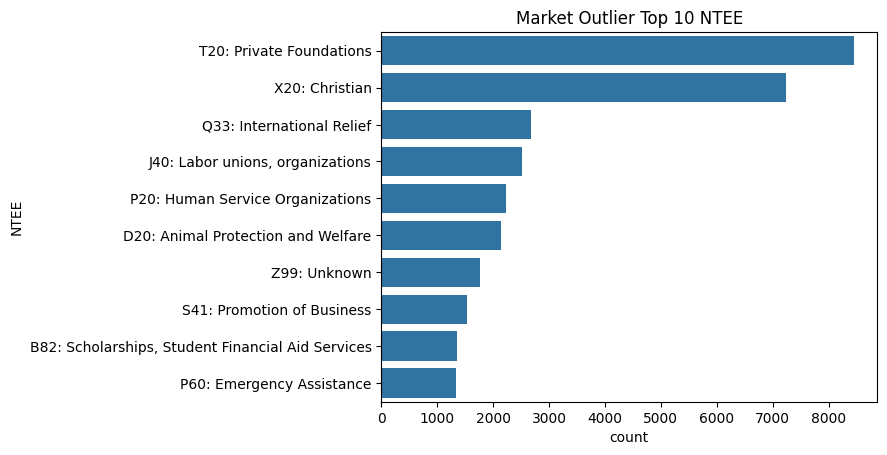

In [522]:
# Most common NTEE's in outliers
ax = sns.barplot(data=nteeCountsSorted.iloc[0:10], y='NTEE', x='count',
                orient='h')
ax.set_title('Market Outlier Top 10 NTEE')

### Customer (BQK) NTEE

In [523]:
# Most common NTEE is private foundations, then Christian
# then...
nteeCountsCustomer = getCountsOverX(allTrend[allTrend.ActiveAnyBQK], 'Over2', 'NTEE')
nteeCountsCustomerSorted = \
  nteeCountsCustomer[nteeCountsCustomer.Over2].sort_values('count', ascending=False).reset_index()
nteeCountsCustomerSorted

index                                               NTEE  Over2  count  \
0      631                                     X20: Christian   True    339   
1      502                          Q33: International Relief   True    243   
2      455                   P20: Human Service Organizations   True    168   
3      435             O50: Youth Development Programs, Other   True    143   
4      158                 D20: Animal Protection and Welfare   True    138   
..     ...                                                ...    ...    ...   
313     12  A12: Arts, Culture and Humanities Fund Raising...   True      1   
314    570  T03: Philanthropy, Voluntarism and Grantmaking...   True      1   
315    275       H01: Medical Research Alliances and Advocacy   True      1   
316      8  A05: Arts, Culture and Humanities Research Ins...   True      1   
317    381  N03: Recreation and Sports Professional Societ...   True      1   

         prop  
0    0.024065  
1    0.017250  
2    0.011926  
3    0.010151  
4    0.009796  
..        ...  
313  0.000071  
314  0.000071  
315  0.000071  
316  0.000071  
317  0.000071  

[318 rows x 5 columns]

Text(0.5, 1.0, 'Active Customer Outlier Top 10 NTEE')

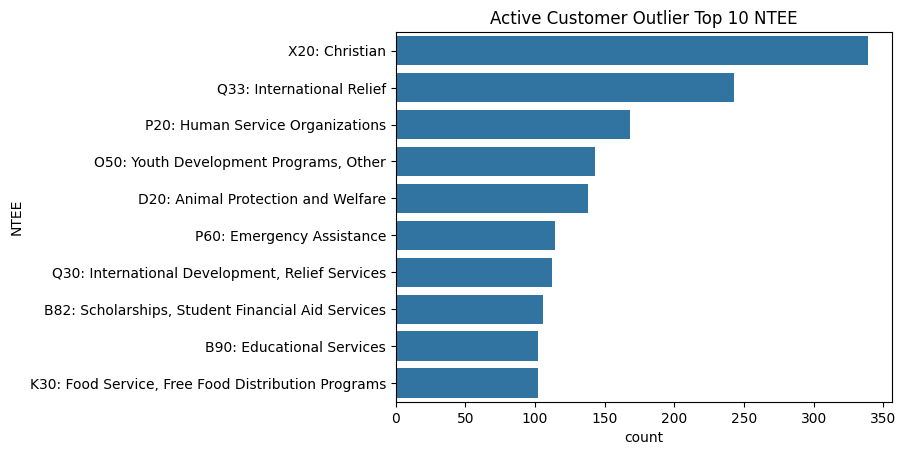

In [524]:
# Most common NTEE's in outliers
ax = sns.barplot(data=nteeCountsCustomerSorted.iloc[0:10], y='NTEE', x='count',
                orient='h')
ax.set_title('Active Customer Outlier Top 10 NTEE')

In [525]:
# side by side
nteeCountsCustomerSorted['Type'] = 'Active Customer'
nteeCountsSorted['Type'] = 'Market'
combinedNTEE = pd.concat([nteeCountsSorted.iloc[0:10], nteeCountsCustomerSorted.iloc[0:10]])
combinedNTEE

index                                               NTEE  Over2  count  \
0    674                           T20: Private Foundations   True   8448   
1    755                                     X20: Christian   True   7240   
2    589                          Q33: International Relief   True   2673   
3    373                   J40: Labor unions, organizations   True   2509   
4    537                   P20: Human Service Organizations   True   2236   
5    177                 D20: Animal Protection and Welfare   True   2135   
6    789                                       Z99: Unknown   True   1772   
7    649                         S41: Promotion of Business   True   1529   
8    116  B82: Scholarships, Student Financial Aid Services   True   1355   
9    553                          P60: Emergency Assistance   True   1338   
0    631                                     X20: Christian   True    339   
1    502                          Q33: International Relief   True    243   
2    455                   P20: Human Service Organizations   True    168   
3    435             O50: Youth Development Programs, Other   True    143   
4    158                 D20: Animal Protection and Welfare   True    138   
5    470                          P60: Emergency Assistance   True    114   
6    500    Q30: International Development, Relief Services   True    112   
7    110  B82: Scholarships, Student Financial Aid Services   True    106   
8    117                          B90: Educational Services   True    102   
9    331  K30: Food Service, Free Food Distribution Prog...   True    102   

       prop             Type  
0  0.017172           Market  
1  0.014716           Market  
2  0.005433           Market  
3  0.005100           Market  
4  0.004545           Market  
5  0.004340           Market  
6  0.003602           Market  
7  0.003108           Market  
8  0.002754           Market  
9  0.002720           Market  
0  0.024065  Active Customer  
1  0.017250  Active Customer  
2  0.011926  Active Customer  
3  0.010151  Active Customer  
4  0.009796  Active Customer  
5  0.008093  Active Customer  
6  0.007951  Active Customer  
7  0.007525  Active Customer  
8  0.007241  Active Customer  
9  0.007241  Active Customer

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Outlier Top 10 NTEE')

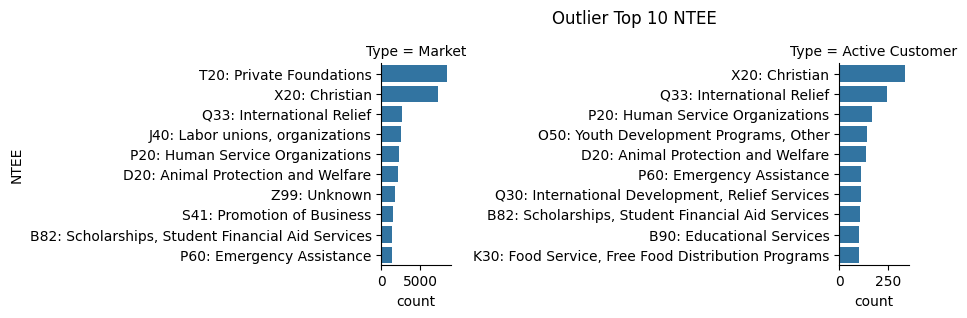

In [526]:
g = sns.FacetGrid(combinedNTEE,
                  col="Type",
                  sharex=False,
                  sharey=False)
g.map(sns.barplot, 'count', 'NTEE',
                orient='h')
g.figure.subplots_adjust(wspace=5.6, hspace=0.9, top=0.8)
g.figure.suptitle('Outlier Top 10 NTEE')

## Market vs. Customer (BQK) Outlier Mix


### Untapped Market vs. Active (BQK) Customer
Excludes customers churned from both Bloom and QGiv but includes chose who churned from KFT, and those who churned from either Q or B but not the other.

Includes in "untapped market" orgs who were prospected and received a demo database but did not convert to customer.

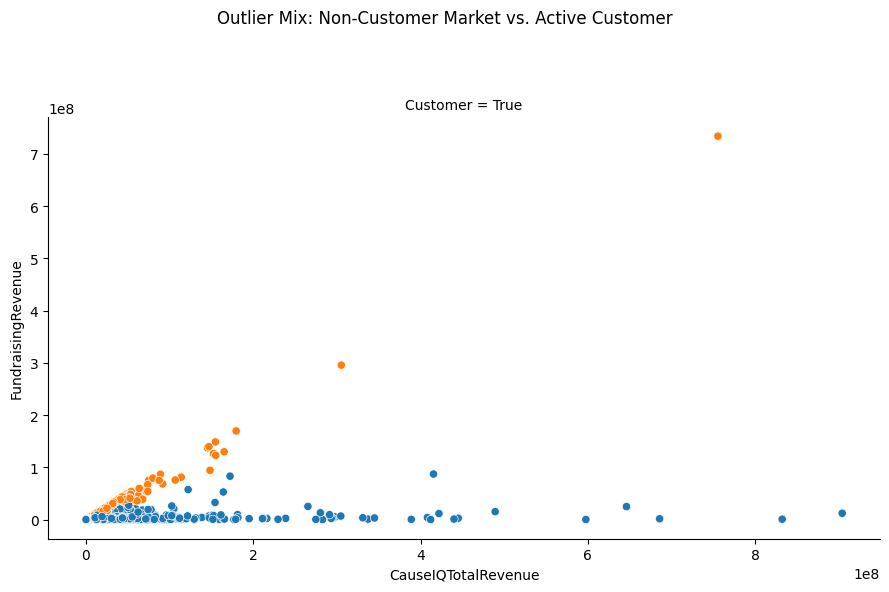

In [527]:
# Filter out churned
nonChurned = allTrend[(allTrend.Customer == False) | (allTrend.ActiveAnyBQK)]

g = sns.FacetGrid(nonChurned,
                  col="Customer",
                  sharex=True,
                  sharey=True,
                  height=6,
                  aspect=1.5)
g.map(sns.scatterplot, 'CauseIQTotalRevenue', 'FundraisingRevenue', 'Over2')
g.figure.suptitle('Outlier Mix: Non-Customer Market vs. Active Customer')
g.figure.subplots_adjust(top=0.8)

## Customer Active vs. Churned
### Overall Counts

In [528]:
# How many outliers overall vs. not?
outlierCounts = allTrend.Over2.value_counts()
outlierCounts

Over2
False    401134
True      90844
Name: count, dtype: int64

In [529]:
# How many were active in any product at the time of tax reporting?
activeCustomerOutlierCounts = allTrend.groupby('ActiveAnyBQK').Over2.value_counts()
activeCustomerOutlierCounts

ActiveAnyBQK  Over2
False         False    392513
              True      85373
True          False      8621
              True       5471
Name: count, dtype: int64

In [530]:
# How many were churned Bloomerang at the time of tax reporting?
churnedBloomOutlierCounts = allTrend.groupby('ChurnedBloom').Over2.value_counts().reset_index()
churnedBloomOutlierCounts

ChurnedBloom  Over2   count
0         False  False  400364
1         False   True   90609
2          True  False     770
3          True   True     235

In [531]:
# How many were churned QGiv at the time of tax reporting?
churnedQGivOutlierCounts = allTrend.groupby('ChurnedBloom').Over2.value_counts().reset_index()
churnedQGivOutlierCounts

ChurnedBloom  Over2   count
0         False  False  400364
1         False   True   90609
2          True  False     770
3          True   True     235

In [532]:
# How many were churned (B and Q both) at the time of tax reporting?
churnBoth = allTrend.groupby('ChurnedBAndQ').Over2.value_counts()
churnBoth

ChurnedBAndQ  Over2
False         False    400394
              True      90616
True          False        14
              True         13
Name: count, dtype: int64

In [533]:
# What is the makeup of outliers vs. not in terms of active or churned Bloom customers?
activeBloomCounts = allTrend[allTrend.ActiveBloom].Over2.value_counts().reset_index()
churnedBloomCounts = allTrend[allTrend.ChurnedBloom].Over2.value_counts().reset_index()
activeBloomCounts['CustomerType'] = 'Active'
churnedBloomCounts['CustomerType'] = 'Churned'
activeChurnedBloomCounts = pd.concat([activeBloomCounts, churnedBloomCounts])
activeChurnedBloomCounts.columns = ['Outlier', 'count', 'BloomCustomerType']
activeChurnedBloomCounts

Outlier  count BloomCustomerType
0    False   5981            Active
1     True   3681            Active
0    False    770           Churned
1     True    235           Churned

Text(0.5, 1.0, 'Outlier Count: Active vs. Churned Bloomerang Customers')

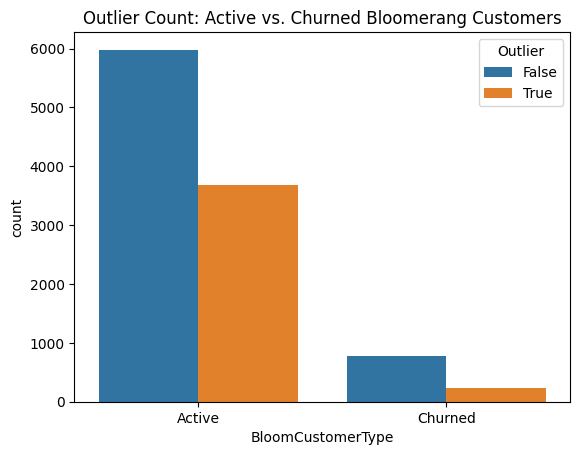

In [534]:
ax = sns.barplot(activeChurnedBloomCounts, x='BloomCustomerType', y='count', hue='Outlier')
ax.set_title("Outlier Count: Active vs. Churned Bloomerang Customers")

In [535]:
# What is the makeup of outliers vs. not in terms of active or churned Qgiv customers?
activeQGivCounts = allTrend[allTrend.ActiveQGiv].Over2.value_counts().reset_index()
allTrendNoQGivNA = allTrend.dropna(subset = 'ChurnedQgiv')
churnedQGivCounts = allTrendNoQGivNA[allTrendNoQGivNA.ChurnedQgiv].Over2.value_counts().reset_index()
activeQGivCounts['CustomerType'] = 'Active'
churnedQGivCounts['CustomerType'] = 'Churned'
activeChurnedQGivCounts = pd.concat([activeQGivCounts, churnedQGivCounts])
activeChurnedQGivCounts.columns = ['Outlier', 'count', 'QGivCustomerType']
activeChurnedQGivCounts

Outlier  count QGivCustomerType
0    False   2168           Active
1     True   1133           Active
0    False    710          Churned
1     True    310          Churned

Text(0.5, 1.0, 'Outlier Count: Active vs. Churned QGiv Customers')

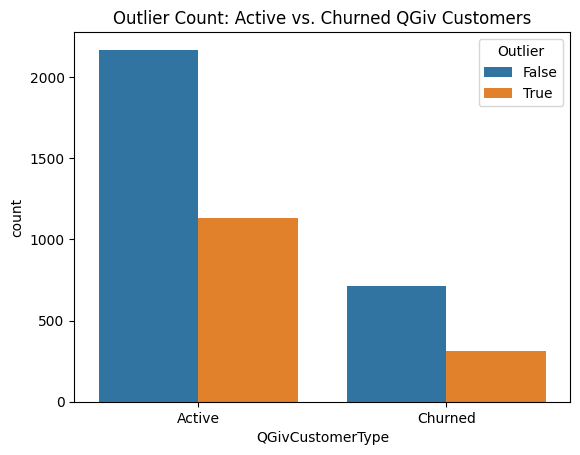

In [536]:
# Graph of active vs. churned QGiv customers
ax = sns.barplot(activeChurnedQGivCounts, x='QGivCustomerType', y='count', hue='Outlier')
ax.set_title("Outlier Count: Active vs. Churned QGiv Customers")

In [537]:
# What, in outliers, is the makeup of non-customer vs. churned customer vs. active customer for Bloom?
outlierActiveBloomCounts = allTrend[allTrend.Over2].ActiveBloom.value_counts().reset_index()
outlierChurnedBloomCounts = allTrend[allTrend.Over2].ChurnedBloom.value_counts().reset_index()
outlierActiveBloomCounts['CustomerType'] = ['NonCustomer', 'Active']
outlierChurnedBloomCounts['CustomerType'] = ['Drop', 'Churned']
outlierActiveChurnedBloomCounts = pd.concat([outlierActiveBloomCounts, outlierChurnedBloomCounts])
outlierActiveChurnedBloomCounts = outlierActiveChurnedBloomCounts[outlierActiveChurnedBloomCounts.CustomerType != 'Drop']
outlierActiveChurnedBloomCounts

ActiveBloom  count CustomerType  ChurnedBloom
0        False  87163  NonCustomer          <NA>
1         True   3681       Active          <NA>
1         <NA>    235      Churned          True

Text(0.5, 1.0, 'Outlier Makeup: Non-Customer, Active, and Churned (Bloomerang)')

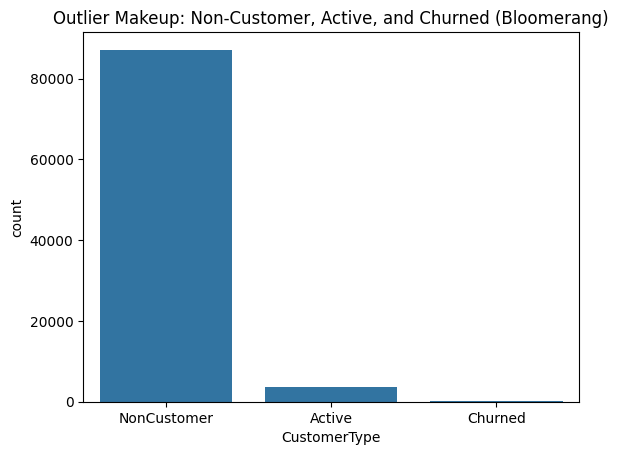

In [538]:
# Chart of count of makeup of outliers in terms of Bloom non-customer, active customer, churned
ax = sns.barplot(outlierActiveChurnedBloomCounts, x='CustomerType', y='count')
ax.set_title('Outlier Makeup: Non-Customer, Active, and Churned (Bloomerang)')

In [539]:
# What, in outliers, is the makeup of non-customer vs. churned customer vs. active customer for QGiv?
outlierActiveQGivCounts = allTrend[allTrend.Over2].ActiveQGiv.value_counts().reset_index()
outlierChurnedQgivCounts = allTrend[allTrend.Over2].ChurnedQgiv.value_counts().reset_index()
outlierActiveQGivCounts['CustomerType'] = ['NonCustomer', 'Active']
outlierChurnedQgivCounts['CustomerType'] = ['Drop', 'Churned']
outlierActiveChurnedQGivCounts = pd.concat([outlierActiveQGivCounts, outlierChurnedQgivCounts])
outlierActiveChurnedQGivCounts = outlierActiveChurnedQGivCounts[outlierActiveChurnedQGivCounts.CustomerType != 'Drop']
outlierActiveChurnedQGivCounts

ActiveQGiv  count CustomerType  ChurnedQgiv
0       False  89711  NonCustomer         <NA>
1        True   1133       Active         <NA>
1        <NA>    310      Churned         True

Text(0.5, 1.0, 'Outlier Makeup: Non-Customer, Active, and Churned (QGiv)')

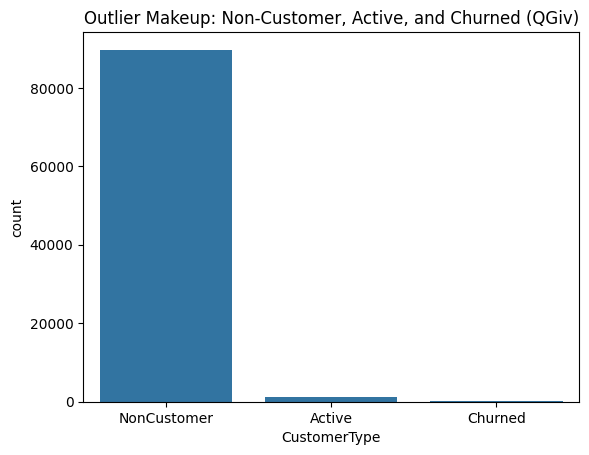

In [540]:
# Chart of count of makeup of outliers in terms of QGiv non-customer, active customer, churned
ax = sns.barplot(outlierActiveChurnedQGivCounts, x='CustomerType', y='count')
ax.set_title('Outlier Makeup: Non-Customer, Active, and Churned (QGiv)')

### Zooming in on active customers
This looks at active customers at the time of tax reporting, which is not necessarily equivalent to active customers *today*. However, since the CauseIQ data is snapshotted by tax reporting, this is the correct way to look at "active customer" from an analytical persepctive. For practical cases (such as sales reaching out to customers with high off-platform revenue), we will need to further filter the list to those customers who also have an active license today.

In [541]:
# The customer type at the time of CauseIQ reporting
activeCustomerTypeCounts = getCountsOverX(allTrend, 'Over2', 'ActiveCustomerType')
activeCustomerTypeCountsSorted = \
  activeCustomerTypeCounts[activeCustomerTypeCounts.Over2].sort_values('count', ascending=False).reset_index()
activeCustomerTypeCountsSorted

index ActiveCustomerType  Over2  count      prop
0     11               None   True  85373  0.173530
1      1                  B   True   3276  0.006659
2      8                  K   True    973  0.001978
3     13                  Q   True    799  0.001624
4      5                 BQ   True    313  0.000636
5      2                 BK   True     89  0.000181
6     14                 QK   True     18  0.000037
7      6                BQK   True      3  0.000006

Text(0.5, 1.0, 'Outliers: Customer Mix')

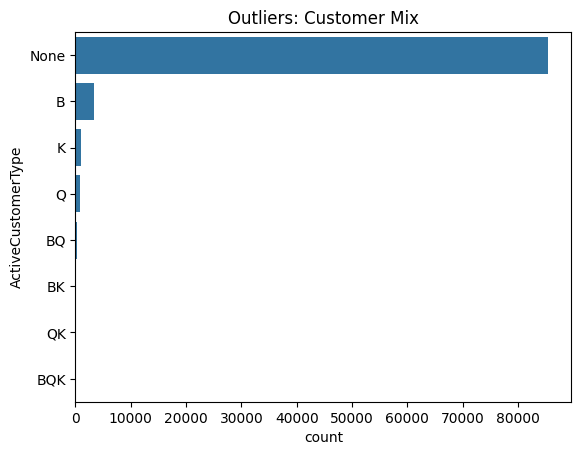

In [542]:
# Active customer type, where active is at the time of tax reporting
ax = sns.barplot(data=activeCustomerTypeCountsSorted,
                y='ActiveCustomerType', x='count',
                orient='h')
ax.set_title('Outliers: Customer Mix')

Text(0.5, 1.0, 'Outliers: Active Customer Mix')

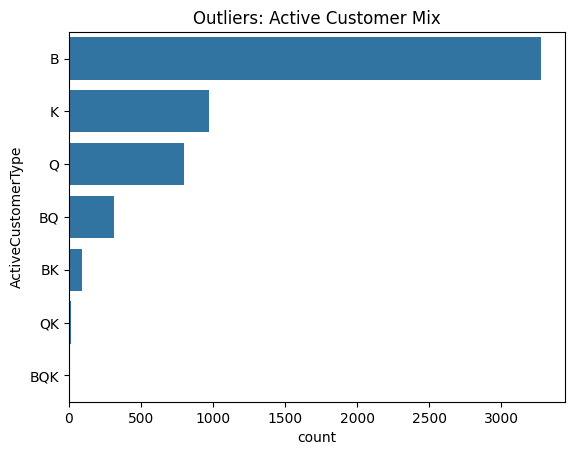

In [543]:
# The same but zooming in on just active customers at the time of tax reporting
ax = sns.barplot(data=activeCustomerTypeCountsSorted[activeCustomerTypeCountsSorted.ActiveCustomerType != 'None'],
                y='ActiveCustomerType', x='count',
                orient='h')
ax.set_title("Outliers: Active Customer Mix")

### Zooming in on churned customers
This looks at churned customers at the time of tax reporting, which is not necessarily equivalent to active customers *today*. For example, a customer might have returned to Bloomerang after the tax window, meaning that they were churned at the time of tax reporting but are not churned now. Since the CauseIQ data is snapshotted by tax reporting, this is the correct way to look at "churned customer" from an analytical persepctive which will allow us to understand what makes outliers diferent from mnon-outliers.

In [544]:
## The customer type at the time of CauseIQ reporting
churnedCustomerTypeCounts = getCountsOverX(allTrend, 'Over2', 'ChurnedCustomerType')
churnedCustomerTypeCountsSorted = \
  churnedCustomerTypeCounts[churnedCustomerTypeCounts.Over2].sort_values('count', ascending=False).reset_index()
churnedCustomerTypeCountsSorted

index ChurnedCustomerType  Over2  count      prop
0      1                       True  90282  0.183508
1     10                   Q   True    296  0.000602
2      3                   B   True    222  0.000451
3      8                   K   True     30  0.000061
4      6                  BQ   True     13  0.000026
5     11                  QK   True      1  0.000002

Text(0.5, 1.0, 'Outliers: Churned Customer Mix')

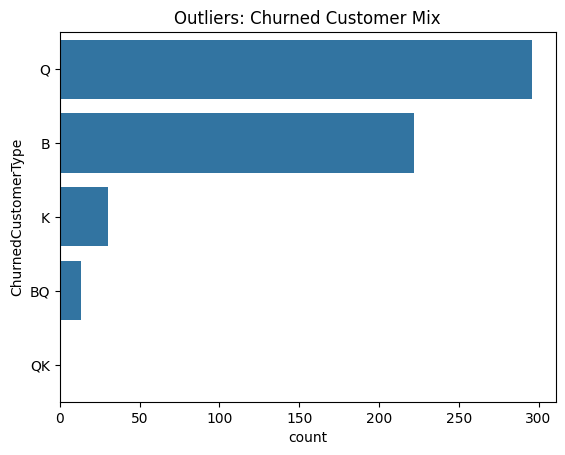

In [545]:
# Churned customer type, where churned is at the time of tax reporting
# Skipping the overall view because nonchurned dominates
# and zooming in on just active customers at the time of tax reporting
# This is a strict view of multiple churned with AND (e.g. bq = had both b and q and churned from both)
ax = sns.barplot(data=churnedCustomerTypeCountsSorted[churnedCustomerTypeCountsSorted.ChurnedCustomerType != ''],
                    y='ChurnedCustomerType', x='count',
                    orient='h')
ax.set_title("Outliers: Churned Customer Mix")

## Tenure with products
This section looks at how long these customers have had the products. For churned customers, it is their tenure before churning, and for active customers (at time of tax reporting) it is their tenure up to the point of tax reporting.

In [546]:
# Length with bloom
bloomTenureCounts = getCountsOverX(allTrend, 'Over2', 'YearBucketBloom')
bloomTenureCountsSorted = \
  bloomTenureCounts[bloomTenureCounts.Over2].sort_values('count', ascending=False).reset_index()
bloomTenureCountsSorted

index YearBucketBloom  Over2  count      prop
0      1       0-2 years   True   1199  0.112403
1      5       3-5 years   True   1020  0.095622
2      9      9-11 years   True    895  0.083904
3      7       6-8 years   True    791  0.074154
4      3     12-15 years   True     11  0.001031

Text(0.5, 1.0, 'Outliers: Active Customer Tenure (Bloomerang)')

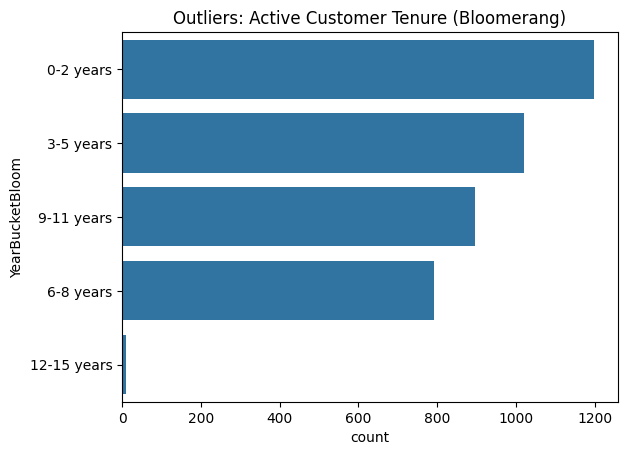

In [547]:
ax = sns.barplot(data=bloomTenureCountsSorted,
                y='YearBucketBloom', x='count',
                orient='h')
ax.set_title('Outliers: Active Customer Tenure (Bloomerang)')

In [548]:
# Length with qgiv
qGivTenureCounts = getCountsOverX(allTrend, 'Over2', 'YearBucketQGiv')
qGivTenureCountsSorted = \
  qGivTenureCounts[qGivTenureCounts.Over2].sort_values('count', ascending=False).reset_index()
qGivTenureCountsSorted

index YearBucketQGiv  Over2  count      prop
0      1      0-2 years   True    744  0.172662
1      5      3-5 years   True    364  0.084474
2      7      6-8 years   True    184  0.042701
3      9     9-11 years   True    100  0.023207
4      3    12-15 years   True     47  0.010907

Text(0.5, 1.0, 'Outliers: Active Customer Tenure (QGiv)')

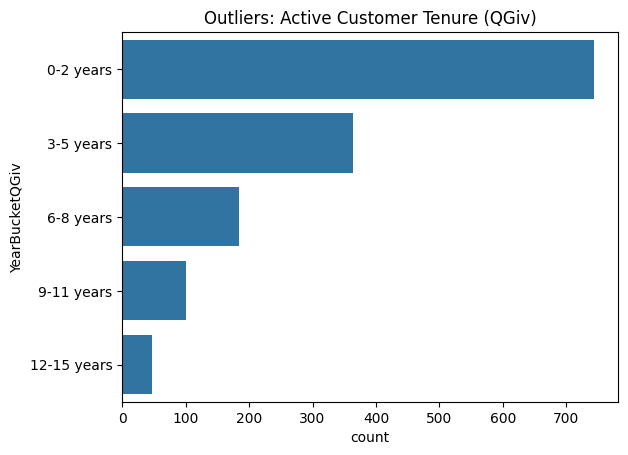

In [549]:
ax = sns.barplot(data=qGivTenureCountsSorted,
                y='YearBucketQGiv', x='count',
                orient='h')
ax.set_title('Outliers: Active Customer Tenure (QGiv)')

## Geographic region
Note that this uses currently active (in 2025) customers, for the east of access to data, rather than active at the time of the outlier identfication.

Note that CauseIQ uses metro area which sometimes combines states. For example, NY/NJ/PA are combined for the New York Metro Area.

### Metro Area (Total Market)

In [550]:
areaCounts = getCountsOverX(allTrend, 'Over2', 'CauseIQMetroArea')
areaCountsSorted = \
  areaCounts[areaCounts.Over2].sort_values('count', ascending=False).reset_index()
areaCountsSorted = areaCountsSorted[areaCountsSorted.CauseIQMetroArea != '']
areaCountsSorted

index                              CauseIQMetroArea  Over2  count  \
0      506         New York-Newark-Jersey City, NY-NJ-PA   True   8404   
1      426            Los Angeles-Long Beach-Anaheim, CA   True   4460   
2      744  Washington-Arlington-Alexandria, DC-VA-MD-WV   True   4265   
3      141            Chicago-Naperville-Elgin, IL-IN-WI   True   2731   
4      624            San Francisco-Oakland-Berkeley, CA   True   2386   
..     ...                                           ...    ...    ...   
385     33                                   Arecibo, PR   True      6   
386      3                         Aguadilla-Isabela, PR   True      4   
387    558                                     Ponce, PR   True      3   
388    626                                San German, PR   True      3   
389    448                                  Mayaguez, PR   True      2   

         prop  
0    0.019535  
1    0.010367  
2    0.009914  
3    0.006348  
4    0.005546  
..        ...  
385  0.000014  
386  0.000009  
387  0.000007  
388  0.000007  
389  0.000005  

[390 rows x 5 columns]

Text(0.5, 1.0, 'Outliers: Market Metro Area')

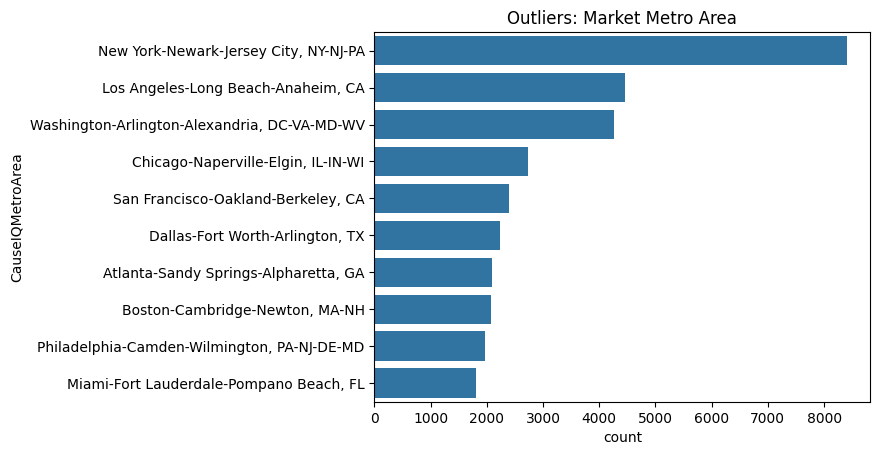

In [551]:
ax = sns.barplot(data=areaCountsSorted.iloc[0:10],
                y='CauseIQMetroArea', x='count',
                orient='h')
ax.set_title("Outliers: Market Metro Area")

### Bloom customers

In [552]:
sql = """
SELECT
  c.State
  , count(*) as count
FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
join `product_ops.outliers_features_static_bloom` c
on c.DatabaseName = o.BloomerangDatabaseName
where
  ifnull(BloomerangDatabaseName, '') <> ''
  and c.State != 'None'
group by 1
order by count(*) desc
limit 10
"""

stateCount = client.query(sql).to_dataframe()
stateCount

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


State  count
0    CA    402
1    TX    396
2    NY    253
3    FL    234
4    IN    207
5    MA    169
6    VA    169
7    NC    164
8    IL    155
9    CO    149

Text(0.5, 1.0, 'Outliers: Bloom Customer State')

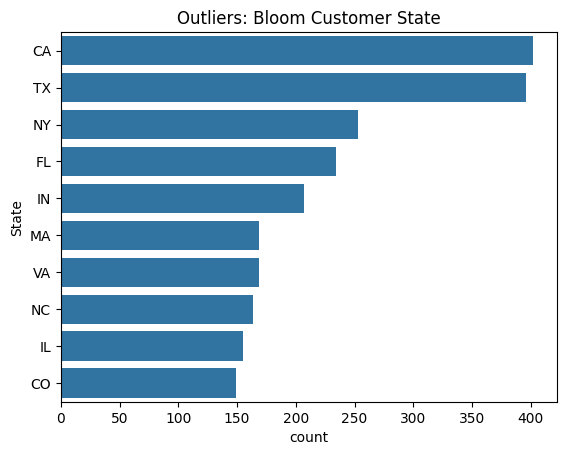

In [553]:
ax = sns.barplot(data=stateCount,
                y='State', x='count',
                orient='h')
ax.set_title('Outliers: Bloom Customer State')

### QGiv Customers

In [555]:
sql = """ 
select 
  case
    when s.BusinessState = 'District of Columbia' then s.BusinessState
    when n.StateAbbreviation is not null then n.StateAbbreviation
    else s.BusinessState
    end as State
  , count(*) as count
from `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` t
join `bloomerang-data.sphere.org_data` s
on t.QGivCustomerId = cast(s.CustomerID as string)
left join `bloomerang-data.product_ops.outliers_state_names` n
on s.BusinessState = n.StateName
group by 1
order by count(*) desc
limit 10
"""
stateCountQGiv = client.query(sql).to_dataframe()
stateCountQGiv

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


State  count
0    CA    259
1    TX    236
2    FL    229
3    NY    195
4    NC    100
5    CO     98
6    IL     97
7    IN     96
8    VA     94
9    MA     92

Text(0.5, 1.0, 'Outliers: QGiv Customer State')

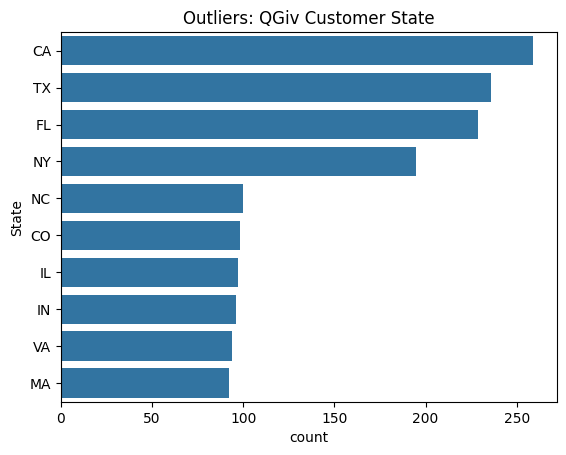

In [556]:
ax = sns.barplot(data=stateCountQGiv,
                y='State', x='count',
                orient='h')
ax.set_title('Outliers: QGiv Customer State')

### Market vs. BQ Customer Comparison


In [557]:
sql = """ 
with base as (
  SELECT
    c.State as BloomState
    , case
        when s.BusinessState = 'District of Columbia' then 'DC'
        when n.StateAbbreviation is not null then n.StateAbbreviation
        else s.BusinessState
        end as QgivState
  FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
  left join `product_ops.outliers_features_static_bloom` c
  on c.DatabaseName = o.BloomerangDatabaseName
  left join `bloomerang-data.sphere.org_data` s
  on o.QGivCustomerId = cast(s.CustomerID as string)
  left join `bloomerang-data.product_ops.outliers_state_names` n
  on s.BusinessState = n.StateName)

select 
  coalesce(BloomState, QGivState) as State
  , count(*) as count
from base 
where not (QgivState is null and BloomState is null)
group by 1
order by count(*) desc
limit 10
"""

customerStateCountAll = client.query(sql).to_dataframe()
customerStateCountAll

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


State  count
0    CA    527
1    TX    484
2    NY    368
3    FL    367
4    IN    235
5    VA    209
6    NC    206
7    MA    201
8    IL    194
9    PA    194

In [558]:
areaCountsSorted['Partial'] = areaCountsSorted['CauseIQMetroArea'].str.extract(r'(?=,)(.*)')
areaCountsSorted['State'] = areaCountsSorted.Partial.str[2:4]

marketStateCounts = areaCountsSorted
marketStateCounts['Type'] = 'Market'
marketStateCounts = marketStateCounts.groupby(['State', 'Type']).sum()
marketStateCounts = marketStateCounts.sort_values('count', ascending=False).reset_index()
marketStateCounts = marketStateCounts[['State', 'Type', 'count']].iloc[0:10]

customerStateCount = customerStateCountAll
customerStateCount['Type'] = 'Customer'
customerStateCount = customerStateCount[['State', 'Type', 'count']].iloc[0:10]

compStateCount = pd.concat([marketStateCounts, customerStateCount])
compStateCount = compStateCount.sort_values('count', ascending=False)
compStateCount

State      Type  count
0    CA    Market  11848
1    NY    Market   9619
2    TX    Market   6523
3    FL    Market   5134
4    DC    Market   4265
5    PA    Market   3473
6    IL    Market   3080
7    GA    Market   2683
8    MA    Market   2563
9    OH    Market   2364
0    CA  Customer    527
1    TX  Customer    484
2    NY  Customer    368
3    FL  Customer    367
4    IN  Customer    235
5    VA  Customer    209
6    NC  Customer    206
7    MA  Customer    201
8    IL  Customer    194
9    PA  Customer    194

Text(0.5, 1.0, 'Outliers: Market vs. Bloom Customer State')

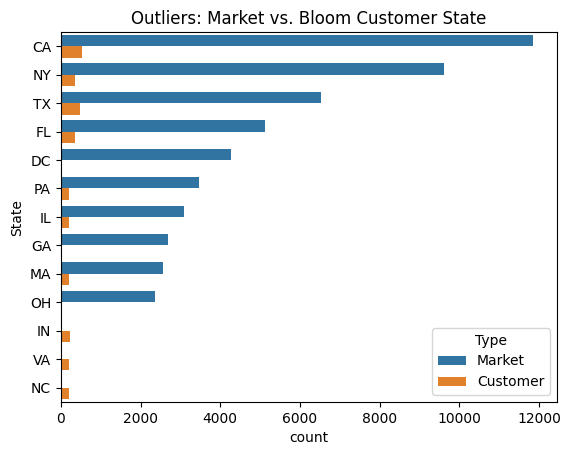

In [559]:
ax = sns.barplot(data=compStateCount,
                y='State', x='count', hue='Type',
                orient='h', errorbar=None)
ax.set_title('Outliers: Market vs. Bloom Customer State')

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


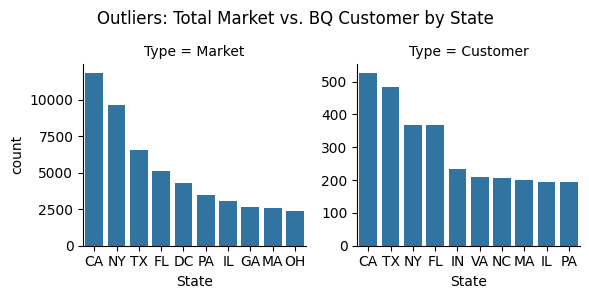

In [560]:
# Same by side by side
g = sns.FacetGrid(compStateCount,
                  col="Type",
                  sharex=False,
                  sharey=False)
g.map(sns.barplot, 'State', 'count', errorbar=None)
g.figure.suptitle('Outliers: Total Market vs. BQ Customer by State')
g.figure.subplots_adjust(top=0.8)

## Transaction Mix (Bloom Customers)


In [583]:
sql = """
SELECT
  t.Type as DesignationType
  , sum(t.count) as count
FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
join `product_ops.outliers_features_annual_transactions_bloom` t 
on 
  t.DatabaseName = o.BloomerangDatabaseName
  and t.Year = o.TaxYear
where t.Type in ('Donation','RecurringDonationPayment','PledgePayment','MembershipPayment')
group by 1
order by count(*) desc
"""

revCount = client.query(sql).to_dataframe()
revCount

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


DesignationType    count
0                  Donation  3878431
1  RecurringDonationPayment   934740
2             PledgePayment    85910
3         MembershipPayment      143

Text(0.5, 1.0, 'Outliers: Bloom Customer Transaction Mix (Count)')

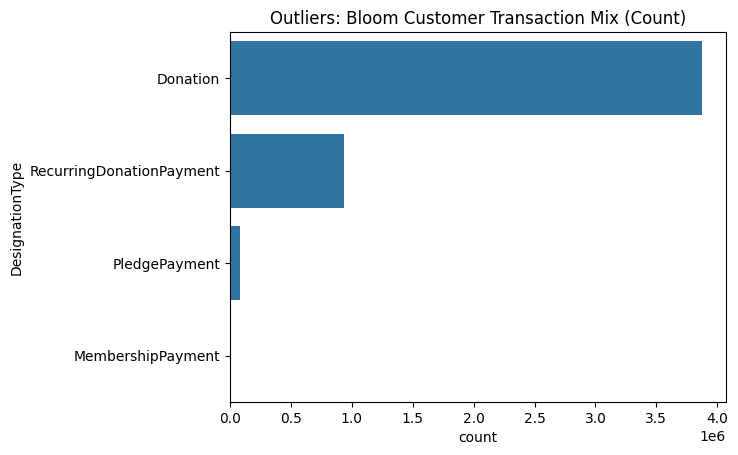

In [584]:
ax = sns.barplot(data=revCount,
                y='DesignationType', x='count',
                orient='h')
ax.set_title("Outliers: Bloom Customer Transaction Mix (Count)")

In [585]:
# Transaction mix in terms of revenue
sql = """
SELECT
  t.Type as DesignationType
  , sum(t.amount) as Amount
FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
join `product_ops.outliers_features_annual_transactions_bloom` t 
on 
  t.DatabaseName = o.BloomerangDatabaseName
  and t.Year = o.TaxYear
where t.Type in ('Donation','RecurringDonationPayment','PledgePayment','MembershipPayment')
group by 1
order by count(*) desc
"""

revSum = client.query(sql).to_dataframe()
revSum

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


DesignationType        Amount
0                  Donation  3.366616e+09
1  RecurringDonationPayment  5.622932e+07
2             PledgePayment  7.070210e+08
3         MembershipPayment  1.192284e+04

Text(0.5, 1.0, 'Outliers: Bloom Customer Transaction Mix ($ Amount)')

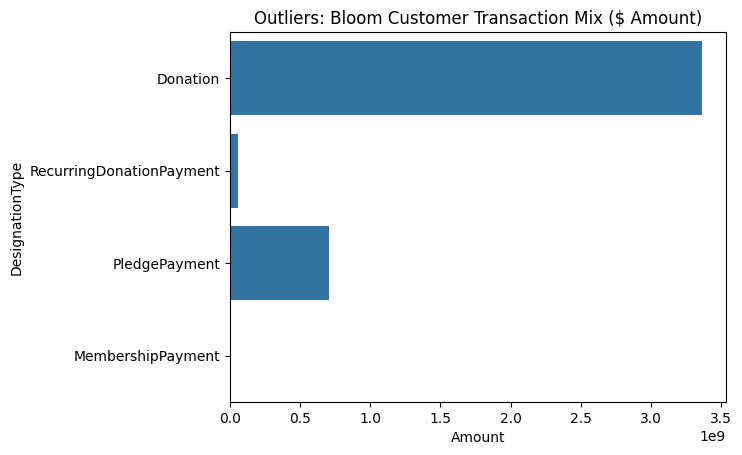

In [586]:
ax = sns.barplot(data=revSum,
                y='DesignationType', x='Amount',
                orient='h')
ax.set_title("Outliers: Bloom Customer Transaction Mix ($ Amount)")

## Non-Revenue Mix (Bloom Customers)
Note that this uses currently active (in 2025) customers, for the east of access to data, rather than active at the time of the outlier identfication.


In [587]:
sql = """
 SELECT
  t.Type as DesignationType
  , sum(t.count) as count
FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
join `product_ops.outliers_features_annual_transactions_bloom` t 
on 
  t.DatabaseName = o.BloomerangDatabaseName
  and t.Year = o.TaxYear
where t.Type not in ('Donation','RecurringDonationPayment','PledgePayment','MembershipPayment')
group by 1
order by count(*) desc
"""
nonRevCount = client.query(sql).to_dataframe()
nonRevCount

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


DesignationType  count
0  RecurringDonation  64807
1             Pledge  40693
2         Membership     48

Text(0.5, 1.0, 'Outliers: Bloom Customer Non-Revenue Mix (Count)')

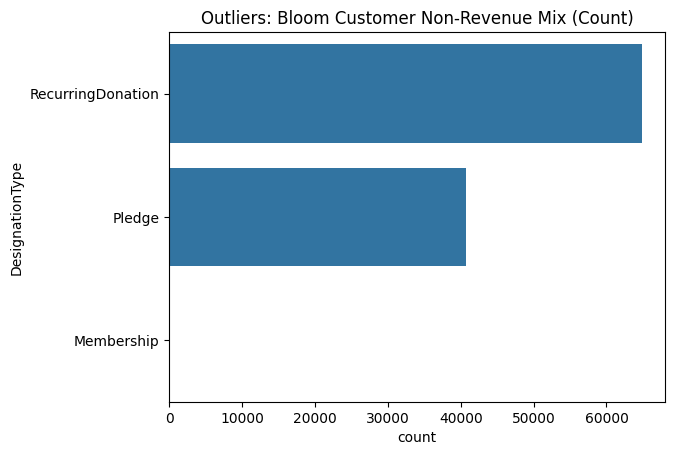

In [588]:
ax = sns.barplot(data=nonRevCount,
                    y ='DesignationType', x='count',
                    orient='h')
ax.set_title("Outliers: Bloom Customer Non-Revenue Mix (Count)")

## Payment Type

 ### Payment Type (Bloom Customers)

In [589]:
sql = """
SELECT
  t.MethodType
  , sum(t.count) as count
FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
join `product_ops.outliers_features_annual_transactions_bloom` t 
on 
  t.DatabaseName = o.BloomerangDatabaseName
  and t.Year = o.TaxYear
where t.Type in ('Donation','RecurringDonationPayment','PledgePayment','MembershipPayment')
group by 1
order by count(*) desc
"""
ttCount = client.query(sql).to_dataframe()
ttCount

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


MethodType    count
0  CreditCard  2243800
1       Check  1448434
2         Eft   494976
3        Cash   613242
4      InKind    19198
5      PayPal    54129
6    ApplePay    19476
7   GooglePay     2886
8       Venmo     3083

Text(0.5, 1.0, 'Outliers: Bloom Customer Payment Type Mix (Count)')

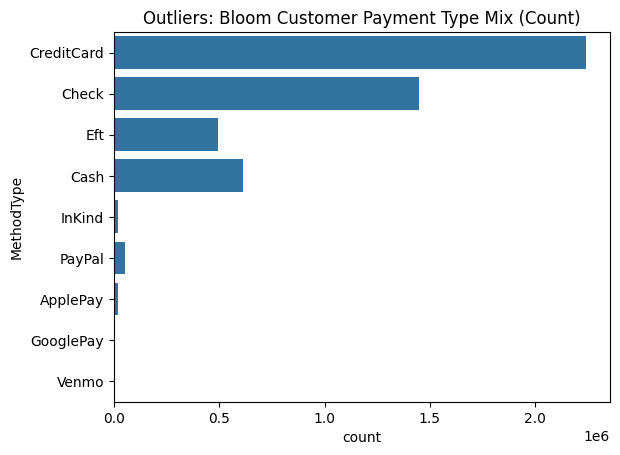

In [590]:
# TODO look into EFT again
ax = sns.barplot(data=ttCount,
                y='MethodType', x='count',
                orient='h')
ax.set_title("Outliers: Bloom Customer Payment Type Mix (Count)")

In [591]:
sql = """
SELECT
  t.MethodType
  , sum(t.amount) as amount
FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
join `product_ops.outliers_features_annual_transactions_bloom` t 
on 
  t.DatabaseName = o.BloomerangDatabaseName
  and t.Year = o.TaxYear
where t.Type in ('Donation','RecurringDonationPayment','PledgePayment','MembershipPayment')
group by 1
order by count(*) desc
"""
ttAmount = client.query(sql).to_dataframe()
ttAmount

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


MethodType        amount
0  CreditCard  3.674608e+08
1       Check  1.866843e+09
2         Eft  1.482596e+09
3        Cash  3.353392e+08
4      InKind  6.686812e+07
5      PayPal  7.248944e+06
6    ApplePay  2.721285e+06
7   GooglePay  3.441334e+05
8       Venmo  4.569660e+05

Text(0.5, 1.0, 'Outliers: Bloom Customer Payment Type Mix ($ Amount)')

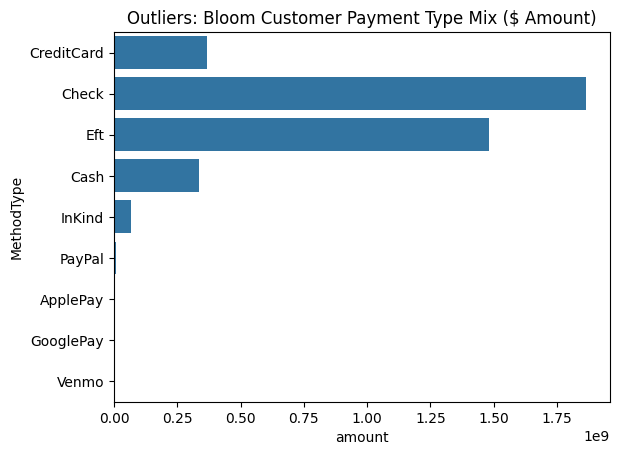

In [592]:
ax = sns.barplot(data=ttAmount,
                y='MethodType', x='amount',
                orient='h')
ax.set_title("Outliers: Bloom Customer Payment Type Mix ($ Amount)")

### Payment Type (QGiv Customers)

In [593]:
sql = """
SELECT
  t.CardType
  , sum(t.count) as count
FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
join `product_ops.outliers_features_annual_qgiv` t 
on 
  cast(t.CustomerID as string) = o.QGivCustomerId
  and t.Year = o.TaxYear
group by 1
order by count(*) desc
"""
ttCountQGiv = client.query(sql).to_dataframe()
ttCountQGiv

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


CardType   count
0        VS  939013
1        MC  333424
2        AM  145540
3        DC   69648
4        ck  109748
5      None  103013
6        PP   86600
7        FB    5211
8        BC      72
9        ca      62
10       mg       7

Text(0.5, 1.0, 'Outliers: QGiv Customer Payment Type Mix (Count)')

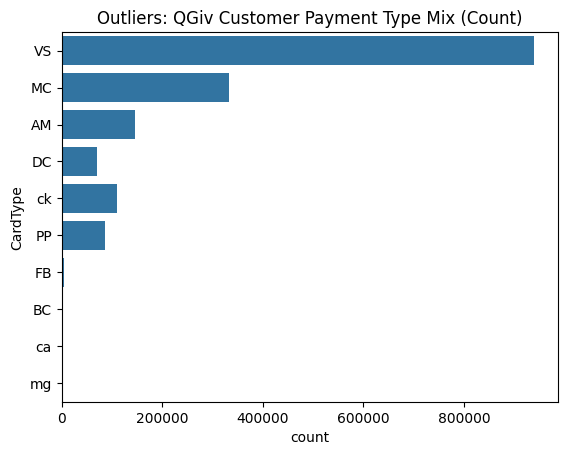

In [594]:
ax = sns.barplot(data=ttCountQGiv,
                y='CardType', x='count',
                orient='h')
ax.set_title("Outliers: QGiv Customer Payment Type Mix (Count)")

In [595]:
sql = """
SELECT
  t.CardType
  , sum(t.amount) as amount
FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
join `product_ops.outliers_features_annual_qgiv` t 
on 
  cast(t.CustomerID as string) = o.QGivCustomerId
  and t.Year = o.TaxYear
group by 1
order by sum(t.amount) desc
"""
ttAmountQGiv = client.query(sql).to_dataframe()
ttAmountQGiv

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


CardType        amount
0        VS  1.056522e+08
1        MC  3.714155e+07
2        AM  3.328431e+07
3        ck  1.435174e+07
4        PP  6.780429e+06
5        DC  5.468635e+06
6        FB  5.340813e+05
7        ca  1.000000e+04
8        BC  1.630000e+03
9      None  0.000000e+00
10       mg  0.000000e+00

Text(0.5, 1.0, 'Outliers: QGiv Customer Payment Type Mix ($ Amount)')

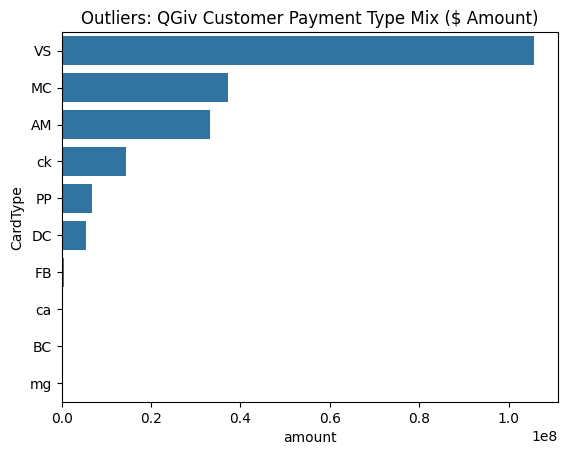

In [596]:
ax = sns.barplot(data=ttAmountQGiv,
                y='CardType', x='amount',
                orient='h')
ax.set_title("Outliers: QGiv Customer Payment Type Mix ($ Amount)")

## Number of users (Bloom Customers)
Note that this uses currently active (in 2025) customers, for the east of access to data, rather than active at the time of the outlier identfication.


In [579]:
sql = """
SELECT
  case 
    when u.numUsers between 0 and 2 then '00-02 users'
    when u.numUsers between 3 and 5 then '03-05 users'
    when u.numUsers between 6 and 8 then '06-08 users'
    when u.numUsers between 9 and 11 then '09-11 users'
    when u.numUsers >= 12 then '12+ users'
    end as Users
  , count(*) as count
FROM `bloomerang-data.product_ops.outliers_orgs_above_trendline_2` o
join `product_ops.outliers_features_static_bloom` u
on 
  u.DatabaseName = o.BloomerangDatabaseName
group by 1
"""
userCount = client.query(sql).to_dataframe()
userCount

/Users/AftonCoombs/Documents/outliers/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Users  count
0  03-05 users   1707
1    12+ users    644
2  09-11 users    753
3  00-02 users    434
4  06-08 users   1463

Text(0.5, 1.0, 'Outliers: Bloom Customer User Mix')

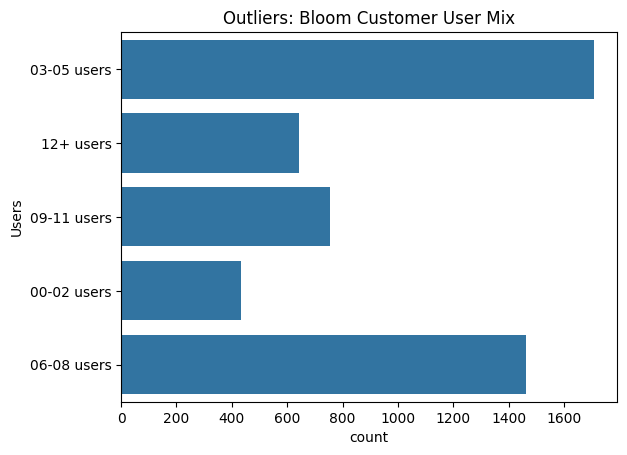

In [580]:
ax = sns.barplot(data=userCount,
                y='Users', x='count',
                orient='h')
ax.set_title("Outliers: Bloom Customer User Mix")

# Differentiate Outliers vs. Not
This section is an EDA of what variables differentiate strongly between outliers and not. The main approach is to look at which variables correlate strongly with binary outlier status. In some cases, we might look at a distance correlation instead, i.e. correlation between distance from the trendline and some variable of interest, rather than between binary is/isn't an outlier and the variable of interest.

Each of these variables is analyzed for correlation with our main variable of interest, outlier status, as well as with each other. The reason to analyze the relationship between these variables and outlier status is to undersatnd what differentiates ouliers from not. 

The reason to analyze the relationships between these variables themselves is to prevent possible issues with subsequent predictive modeling of outlier status if some of the variabls are colinear. This possible issue also dependso on the choice of model, though. 

We do not analyze the correlation between outlier status and either total revenue or fundraising revenue, because those relationships were addressed in the trendline section, and doing so would be pointless and circular.

## Join and prepare dataset
Note: This can be run independently of all previous code blocks with the exception of the library imports.

In [ ]:
# Use this flag to create a new query, or to just load for a locally saved file
runFeaturesQuery = False

# wip
sql = """ 
with annualTotals as (
  select 
    DatabaseName
    , Year
    , sum(Count) as TotalCount
    , sum(Amount) as TotalAmount
  from `bloomerang-data.product_ops.outliers_features_annual_transactions_bloom`
  where Revenue = 1
  group by DatabaseName, Year
)

, annualTypeTotals as (
  select 
    DatabaseName
    , Year
    , Type
    , sum(Count) as Count
    , sum(Amount) as Amount
  from `bloomerang-data.product_ops.outliers_features_annual_transactions_bloom`
  where Revenue = 1
  group by DatabaseName, Year, Type
)

, annualMethodTotals as (
  select 
    DatabaseName
    , Year
    , MethodType
    , sum(Count) as Count
    , sum(Amount) as Amount
  from `bloomerang-data.product_ops.outliers_features_annual_transactions_bloom`
  where Revenue = 1
  group by DatabaseName, Year, MethodType
)

, typeProps as (
  select
    b.DatabaseName
    , Type
    , b.Year
    , Amount / TotalAmount as PropAmount
    , Count/ TotalCount as PropCount
  from annualTotals a
  join annualTypeTotals b
  on a.DatabaseName = b.DatabaseName and a.Year = b.Year
  order by DatabaseName, Year, Type
)

, methodProps as (
  select
    b.DatabaseName
    , MethodType
    , b.Year
    , Amount / TotalAmount as PropAmount
    , Count/ TotalCount as PropCount
  from annualTotals a
  join annualMethodTotals b
  on a.DatabaseName = b.DatabaseName and a.Year = b.Year
  order by DatabaseName, Year, MethodType
)

, typePropsWide as (
  select
    DatabaseName
    , Year
    , max(coalesce(case when Type = 'Donation' then PropAmount end, 0)) as DonationPropAmount
    , max(coalesce(case when Type = 'MembershipPayment' then PropAmount end, 0)) as MembershipPropAmount
    , max(coalesce(case when Type = 'PledgePayment' then PropAmount end, 0)) as PledgePaymentPropAmount
    , max(coalesce(case when Type = 'RecurringDonationPayment' then PropAmount end, 0)) as RecurringDonationPaymentPropAmount
    , max(coalesce(case when Type = 'Donation' then PropCount end, 0)) as DonationPropCount
    , max(coalesce(case when Type = 'MembershipPayment' then PropCount end, 0)) as MembershipPropCount
    , max(coalesce(case when Type = 'PledgePayment' then PropCount end, 0)) as PledgePaymentPropCount
    , max(coalesce(case when Type = 'RecurringDonationPayment' then PropCount end, 0)) as RecurringDonationPaymentPropCount
  from typeProps
  group by DatabaseName, Year
)

, methodPropsWide as (
  select
    DatabaseName
    , Year
    -- amounts
    , max(coalesce(case when MethodType = 'Apple' then PropAmount end, 0)) as BloomPayApplePropAmount
    , max(coalesce(case when MethodType = 'Cash' then PropAmount end, 0)) as BloomPayCashPropAmount
    , max(coalesce(case when MethodType = 'Check' then PropAmount end, 0)) as BloomPayCheckPropAmount
    , max(coalesce(case when MethodType = 'CreditCard' then PropAmount end, 0)) as BloomPayCCPropAmount
    , max(coalesce(case when MethodType = 'Eft' then PropAmount end, 0)) as BloomPayEFTPropAmount
    , max(coalesce(case when MethodType = 'GooglePay' then PropAmount end, 0)) as BloomPayGooglePayPropAmount
    , max(coalesce(case when MethodType = 'InKind' then PropAmount end, 0)) as BloomPayInKindPropAmount
    , max(coalesce(case when MethodType = 'None' then PropAmount end, 0)) as BloomPayNonePropAmount
    , max(coalesce(case when MethodType = 'PayPal' then PropAmount end, 0)) as BloomPropPayPalAmount
    , max(coalesce(case when MethodType = 'Venmo' then PropAmount end, 0)) as BloomPropVenmoAmount
  -- counts
    , max(coalesce(case when MethodType = 'Apple' then PropCount end, 0)) as BloomPayApplePropCount
    , max(coalesce(case when MethodType = 'Cash' then PropCount end, 0)) as BloomPayCashPropCount
    , max(coalesce(case when MethodType = 'Check' then PropCount end, 0)) as BloomPayCheckPropCount
    , max(coalesce(case when MethodType = 'CreditCard' then PropCount end, 0)) as BloomPayCCPropCount
    , max(coalesce(case when MethodType = 'Eft' then PropCount end, 0)) as BloomPayEFTPropCount
    , max(coalesce(case when MethodType = 'GooglePay' then PropCount end, 0)) as BloomPayGooglePayPropCount
    , max(coalesce(case when MethodType = 'InKind' then PropCount end, 0)) as BloomPayInKindPropCount
    , max(coalesce(case when MethodType = 'None' then PropCount end, 0)) as BloomPayNonePropCount
    , max(coalesce(case when MethodType = 'PayPal' then PropCount end, 0)) as BloomPropPayPalCount
    , max(coalesce(case when MethodType = 'Venmo' then PropCount end, 0)) as BloomPropVenmoCount
  from methodProps
  group by DatabaseName, Year
)

, revPropsWide as (
  select *
  from typePropsWide
  full join methodPropsWide
  using (DatabaseName, Year)
  order by DatabaseName, Year
)

, annualTotalsQ as (
  select 
    CustomerID
    , Year
    , coalesce(sum(Count), 0) as TotalCount
    , coalesce(sum(Amount), 0) as TotalAmount
  from `product_ops.outliers_features_annual_qgiv`
  group by CustomerID, Year
)

, annualMethodTotalsQ as (
  select 
    CustomerID
    , Year
    , case 
      when CardType in ('AM', 'VS', 'DC', 'MC') then 'CreditCard'
      when CardType = 'ck' then 'E-Check'
      when CardType = 'ch' then 'Check'
      when CardType = 'no' then 'None'
      when CardType = 'ca' then 'Cash'
      when CardType = 'PP' then 'PayPal'
      when CardType = 'mg' then 'Matching'
      when CardType = 'BC' then 'BillToCarrier'
      when CardType = 'FB' then 'FaceBook'
      else 'Other'
      end as CardType2
    , coalesce(sum(Count), 0) as Count
    , coalesce(sum(Amount), 0) as Amount
  from `product_ops.outliers_features_annual_qgiv`
  group by CustomerID, Year, CardType2
)

, methodPropsQ as (
  select
    b.CustomerID
    , b.Year
    , CardType2 as CardType
    , safe_divide(Amount, TotalAmount) as PropAmount
    , safe_divide(Count, TotalCount) as PropCount
  from annualTotalsQ a
  join annualMethodTotalsQ b
  on a.CustomerId = b.CustomerId and a.Year = b.Year
  order by CustomerId, Year, CardType2
)

, methodPropsWideQ as (
  select
    CustomerId
    , Year
    -- amount
    , max(coalesce(case when CardType is null or CardType = 'None' then PropAmount end, 0)) as QGivPayNonePropAmount
    , max(coalesce(case when CardType = 'CreditCard' then PropAmount end, 0)) as QGivPayCCPropAmount
    , max(coalesce(case when CardType = 'Check' then PropAmount end, 0)) as QGivPayCheckPropAmount
    , max(coalesce(case when CardType = 'PayPal' then PropAmount end, 0)) as QGivPayPayPalPropAmount
    , max(coalesce(case when CardType = 'E-Check' then PropAmount end, 0)) as QGivPayECheckPropAmount
    , max(coalesce(case when CardType = 'Cash' then PropAmount end, 0)) as QGivPayCashPropAmount
    , max(coalesce(case when CardType = 'Matching' then PropAmount end, 0)) as QGivPayMatchingPropAmount
    , max(coalesce(case when CardType = 'BillToCarrier' then PropAmount end, 0)) as QGivPayBTCPropAmount
    , max(coalesce(case when CardType = 'Facebook' then PropAmount end, 0)) as QGivPayFBPropAmount
    , max(coalesce(case when CardType = 'Other' then PropAmount end, 0)) as QGivPayOtherPropAmount
    -- counts
    , max(coalesce(case when CardType is null or CardType = 'None' then PropCount end, 0)) as QGivPayNonePropCount
    , max(coalesce(case when CardType = 'CreditCard' then PropCount end, 0)) as QGivPayCCPropCount
    , max(coalesce(case when CardType = 'Check' then PropCount end, 0)) as QGivPayCheckPropCount
    , max(coalesce(case when CardType = 'PayPal' then PropCount end, 0)) as QGivPayPayPalPropCount
    , max(coalesce(case when CardType = 'E-Check' then PropCount end, 0)) as QGivPayECheckPropCount
    , max(coalesce(case when CardType = 'Cash' then PropCount end, 0)) as QGivPayCashPropCount
    , max(coalesce(case when CardType = 'Matching' then PropCount end, 0)) as QGivPayMatchingPropCount
    , max(coalesce(case when CardType = 'BillToCarrier' then PropCount end, 0)) as QGivPayBTCPropCount
    , max(coalesce(case when CardType = 'Facebook' then PropCount end, 0)) as QGivPayFBPropCount
    , max(coalesce(case when CardType = 'Other' then PropCount end, 0)) as QGivPayOtherPropCount
  from methodPropsQ
  group by CustomerId, Year
)

, sfFeatures as (
  select 
    id
    , case 
        when cause_iq_number_of_volunteers_c > number_of_volunteers_c then cause_iq_number_of_volunteers_c
        else (coalesce(number_of_volunteers_c, 0)) 
        end as NumVolunteers
    , coalesce(cause_iq_website_url_c, website) is not null as HasWebsite
    , case 
      when cast(zoom_info_employee_count_c as int64) > number_of_employees then cast(zoom_info_employee_count_c as int64)
      else number_of_employees
      end as NumEmployees
    -- These below can later be recoded for individual services instead of a flag
    , zoominfo_account_linkedin_profile_c is not null as HasLinkedIn
    , zoominfo_technology_crm_c is not null as HasCRMService
    , zoominfo_technology_email_c is not null as HasEmailService
    , zoominfo_technology_fundraising_c is not null as HasFundraisingService
    , zoominfo_technology_payment_processor_c is not null as HasPaymentProcessor
  FROM `bloomerang-data.salesforce.account`
)

, ordwayProducts as (
  select 
    c.name
    , ccf.value as BloomerangDatabaseName
    , p.name as OrdwayProductName
    , p.id as OrdwayProductID
  from ordway.invoice_line_item ili 
  join ordway.invoice i 
  on i.id = ili.invoice_id
  join ordway.customer c 
  on c.id  = i.customer_id 
  join ordway.customer_custom_field ccf 
  on ccf.customer_id = c.id and ccf.name = 'admin_db' 
  join ordway.product p 
  on p.id = ili.product_id
  where 
    ili._fivetran_deleted = false 
    and i._fivetran_deleted = false 
    and c._fivetran_deleted = false 
    and ccf._fivetran_deleted = false 
    and p._fivetran_deleted = false
    and ifnull(ccf.value, '') <> ''
    and p.Id in ('P-00197','P-00210','P-00008','P-00010','P-00011',
                'P-00134','P-00147','P-00146','P-00145','P-00016','P-00043',
                'P-00036','P-00020','P-00022','P-00023','P-00139','P-00028'
                'P-00040','P-00161','P-00039','P-00143','P-00166','P-00174',
                'P-00031','P-00030','P-00032','P-00219','P-00201','P-00179','P-00037'
                'P-00186','P-00038','P-00207','P-00042','P-00014','P-00013','P-00107',
                'P-00130','P-00204','P-00148','P-00216','P-00162')
  group by all
  order by ccf.value, p.name)

, ordwayProductsWide as (
  select 
    BloomerangDatabaseName
    , max(case when OrdwayProductName like '%Fundraising Platform%' then 1 else 0 end) as OrdwayFundraising
    , max(case when OrdwayProductName like '%Database%' then 1 else 0 end) as OrdwayDB
    , max(case when OrdwayProductName like '%DonorSearch%' then 1 else 0 end) as OrdwayDonorSearch
    , max(case when OrdwayProductName like '%Giving+%' then 1 else 0 end) as OrdwayGivingPlus
    , max(case when OrdwayProductName like '%Fundraising Standard%' then 1 else 0 end) as OrdwayFundraisingStandard
    , max(case when OrdwayProductName like '%Smart Start%' then 1 else 0 end) as OrdwaySmartStart
    , max(case when OrdwayProductName like '%Volunteer Management%' then 1 else 0 end) as OrdwayVolunteerManagement
    , max(case when OrdwayProductName like '%Batch Screen%' then 1 else 0 end) as OrdwayBatchScreen
    , max(case when OrdwayProductName like '%Text to Donate%' then 1 else 0 end) as OrdwayTextToDonate
    , max(case when OrdwayProductName like '%Consulting%' then 1 else 0 end) as OrdwayConsulting
    , max(case when OrdwayProductName like '%GiveButter%' then 1 else 0 end) as OrdwayGiveButter
    , max(case when OrdwayProductName like '%Giving Essentials%' then 1 else 0 end) as OrdwayGivingEssentials
    , max(case when OrdwayProductName like '%Text Fundraising%' then 1 else 0 end) as OrdwayTextFundraising
    , max(case when OrdwayProductName like '%Peer%' then 1 else 0 end) as OrdwayP2P
    , max(case when OrdwayProductName like '%Auctions%' then 1 else 0 end) as OrdwayAuctions
    , max(case when OrdwayProductName like '%Card Swiper%' then 1 else 0 end) as OrdwayCardSwiper
    , max(case when OrdwayProductName like '%Coaching%' then 1 else 0 end) as OrdwayCoaching
  from ordwayProducts
  group by BloomerangDatabaseName
)

, pendo as (
  select
    product as Product
    , Year
    , account_id as AccountID
    , sum(unique_visitor_count) as UniqueVisitorsCount
    , sum(total_events_count) as TotalEventsCount
  from `bloomerang-data.product_ops.outliers_features_annual_pendo`
  group by
    Product, Year, AccountID
)

, base as 
 (select
  -- IDs
    o.AccountID
    , o.QGivCustomerId
    , o.BloomerangDatabaseName
    , o.KindfulSubdomain
    -- outcome
    , o.Over2 as IsOutlier
    , o.NTEE
    , o.CauseIQMetroArea
    , o.TaxYear
    , o.BloomerangRevenue
    , o.QGivRevenue
    , o.KFTRevenue
    , o.BloomerangQGivRevenue
    , o.BloomerangTotalRevenue
    , o.SegmentName
    , o.SegmentName2
    , o.ActiveBloom
    , o.ActiveQGiv
    , o.ActiveKFT
    , o.ActiveBQ
    , o.ActiveBK
    , o.ActiveQK
    , o.ActiveBQK
    , o.ActiveAnyBQK
    , o.YearBucketBloom
    , o.YearBucketQGiv
    , o.ActiveCustomerType
    , case when b.LicenseLevel = 'Standard' then 1 else 0 end as HasStandardLicense
    , case when b.LicenseLevel = 'Free' then 1 else 0 end as HasFreeLicense
    , case when b.LicenseLevel = 'Grow' then 1 else 0 end as HasGrowLicense
    , case when b.LicenseLevel = 'TechSoup' then 1 else 0 end as HasTechSoupLicense
    , case when b.AccountingIntegration is not null then 1 else 0 end as HasAccountingIntegration
    , case when b.HasCustomRetention is not null and b.HasCustomRetention != 'False' then 1 else 0 end as HasCustomRetention
    , case when b.HasActivatedTrueGivers is not null and b.HasActivatedTrueGivers != 'False' then 1 else 0 end as HasActivatedTrueGivers
    , case when b.HasFundly is not null and b.HasFundly != 'False' then 1 else 0 end as HasFundly
    , case when b.HasAbila is not null and b.HasAbila != 'False' then 1 else 0 end as HasAbila
    , b.HasAplos
    , b.HasZenDesk
    , case when b.HasMailChimp is not null then 1 else 0 end as HasMailChimp
    , case when b.EmailIntegration is not null then 1 else 0 end as HasEmailIntegration
    , b.GivingLevelMidThreshold
    , b.GivingLevelMajorThreshold
    , case when b.hasEmailLicense > 0 then 1 else 0 end as hasEmailLicense
    , b.hasFileLicense as HasFileLicense
    , b.hasDonorSearchLicense as HasDonorSearchLicense
    , b.hasPhoneSupportLicense as HasPhoneSupportLicense
    , b.hasGSBatchEntryLicnse as HasGSBatchEntryLicense
    , b.hasKindfulLicense as HasKindfulLicense
    , b.hasMembershipLicense as HasMembershipLicense
    , b.hasJALicnse as HasJALicense
    , b.NumUsers
    , b.State as BloomState
    , case
      when s.BusinessState = 'District of Columbia' then s.BusinessState
      when n.StateAbbreviation is not null then n.StateAbbreviation
      else s.BusinessState
      end as QGivState
    , case
      when b.numUsers between 0 and 2 then '00-02 users'
      when b.numUsers between 3 and 5 then '03-05 users'
      when b.numUsers between 6 and 8 then '06-08 users'
      when b.numUsers between 9 and 11 then '09-11 users'
      when b.numUsers >= 12 then '12+ users'
      end as UsersBucket
    , brp.* except(DatabaseName, Year)
    , q.* except(CustomerId, Year)
    , sf.NumVolunteers
    , sf.HasWebsite
    , sf.NumEmployees
    , sf.HasLinkedIn
    , sf.HasCRMService
    , sf.HasEmailService
    , sf.HasFundraisingService
    , sf.HasPaymentProcessor
    , ord.* except(BloomerangDatabaseName)
    , ba.* except(string_field_20, Year, DatabaseName)
    , coalesce(pb.UniqueVisitorsCount, 0) as BloomPendoUniqueVisitorsCount
    , coalesce(pb.TotalEventsCount, 0) as BloomPendoTotalEventsCount
    , coalesce(pq.UniqueVisitorsCount, 0) as QGivPendoUniqueVisitorsCount
    , coalesce(pq.TotalEventsCount, 0) as QGivPendoTotalEventsCount
    , coalesce(pb.UniqueVisitorsCount, 0) + coalesce(pq.UniqueVisitorsCount, 0) as PendoUniqueVisitorsCount
    , coalesce(pb.TotalEventsCount, 0) + coalesce(pq.TotalEventsCount, 0) as PendoTotalEventsCount
  from `bloomerang-data.product_ops.outliers_orgs_all_trendline_2` o
  left join `product_ops.outliers_features_static_bloom` b
  on b.DatabaseName = o.BloomerangDatabaseName
  left join revPropsWide brp
  on brp.DatabaseName = o.BloomerangDatabaseName and brp.Year = o.TaxYear
  left join `bloomerang-data.sphere.org_data` s
  on o.QGivCustomerId = cast(s.CustomerID as string)
  left join `bloomerang-data.product_ops.outliers_state_names` n
  on s.BusinessState = n.StateName
  left join methodPropsWideQ q
  on cast(q.CustomerID as string) = o.QGivCustomerId and q.Year = o.TaxYear
  left join sfFeatures sf
  on o.AccountId = sf.id
  left join OrdwayProductsWide ord
  on o.BloomerangDatabaseName = ord.BloomerangDatabaseName
  left join `product_ops.outliers_features_annual_bloom` ba
  on o.BloomerangDatabaseName = ba.DatabaseName and o.TaxYear = ba.Year
  left join pendo pb
  on pb.product = 'B' and pb.AccountID = o.BloomerangDatabaseName and pb.Year = o.TaxYear
  left join pendo pq
  on pq.product = 'Q' and pq.AccountID = o.QGivCustomerId and pq.Year = o.TaxYear
)

select 
  b.* except(BloomState, QGivState)
  , coalesce(BloomState, QGivState) as CustomerState
  , safe_divide((b.BloomPayCheckPropAmount * b.BloomerangRevenue + b.QGivPayCheckPropAmount * b.QGivRevenue),
                (b.BloomerangRevenue + b.QGivRevenue)) as BQPayCheckPropAmount
  , safe_divide((b.BloomPayCashPropAmount * b.BloomerangRevenue + b.QGivPayCashPropAmount * b.QGivRevenue),
                (b.BloomerangRevenue + b.QGivRevenue)) as BQPayCashPropAmount
  , safe_divide((b.BloomPayCCPropAmount * b.BloomerangRevenue + b.QGivPayCCPropAmount * b.QGivRevenue),
                (b.BloomerangRevenue + b.QGivRevenue)) as BQPayCCPropAmount
  , bat.TotalCount as NumBloomerangTransactions
  , qat.TotalCount as NumQGivTransactions
  , safe_divide((b.BloomPayCheckPropCount * bat.TotalCount + b.QGivPayCheckPropCount * qat.TotalCount),
                (bat.TotalCount + qat.TotalCount)) as BQPayCheckPropCount
  , safe_divide((b.BloomPayCashPropCount *  bat.TotalCount  + b.QGivPayCashPropCount * qat.TotalCount),
                (bat.TotalCount + qat.TotalCount)) as BQPayCashPropCount
  , safe_divide((b.BloomPayCCPropCount *  bat.TotalCount + b.QGivPayCCPropCount * qat.TotalCount),
                (bat.TotalCount + qat.TotalCount)) as BQPayCCPropCount
from base b
left join annualTotals bat
on b.BloomerangDatabaseName = bat.DatabaseName and b.TaxYear = bat.Year
left join annualTotalsQ qat
on b.QGivCustomerId = cast(qat.CustomerId as string) and b.TaxYear = qat.Year
"""
if runFeaturesQuery:
  featureSet = client.query(sql).to_dataframe()
  featureSet.to_csv('features_dataset.csv')
else:
  featureSet = pd.read_csv('features_dataset.csv')

# Do some more work on state that's easier in pd
featureSet['PartialMarketState'] = featureSet['CauseIQMetroArea'].str.extract(r'(?=,)(.*)')
featureSet['MarketState'] = featureSet.PartialMarketState.str[2:4]
featureSet['State'] = featureSet.CustomerState.combine_first(featureSet.MarketState)
featureSet['State']  = featureSet['State'] .fillna('None')
featureSet = featureSet.drop('PartialMarketState', axis=1)


featureSet.head()

AccountID  QGivCustomerId BloomerangDatabaseName KindfulSubdomain  \
0  0011R0000305jX2QAI             NaN                    NaN              NaN   
1  00136000015aBJeAAM             NaN         unitycaregroup              NaN   
2  0011R000025sGmxQAE             NaN                    NaN              NaN   
3  0011R00002YiroEQAR             NaN                    NaN              NaN   
4  0013600001AdgFKAAZ             NaN                    NaN              NaN   

   IsOutlier                                               NTEE  \
0      False                         S41: Promotion of Business   
1      False                  P30: Childrens and Youth Services   
2      False                                P33: Child Day Care   
3      False  B21: Nursery School, Early School Admissions, ...   
4      False                               B29: Charter Schools   

                               CauseIQMetroArea  TaxYear  BloomerangRevenue  \
0                            Salt Lake City, UT     2023               0.00   
1            San Jose-Sunnyvale-Santa Clara, CA     2023         1071149.37   
2                               Panama City, FL     2023               0.00   
3  Washington-Arlington-Alexandria, DC-VA-MD-WV     2023               0.00   
4               Dallas-Fort Worth-Arlington, TX     2023               0.00   

   QGivRevenue  ...  BQPayCheckPropAmount  BQPayCashPropAmount  \
0          0.0  ...                   NaN                  NaN   
1          0.0  ...                   NaN                  NaN   
2          0.0  ...                   NaN                  NaN   
3          0.0  ...                   NaN                  NaN   
4          0.0  ...                   NaN                  NaN   

   BQPayCCPropAmount NumBloomerangTransactions NumQGivTransactions  \
0                NaN                       NaN                 NaN   
1                NaN                     132.0                 NaN   
2                NaN                       NaN                 NaN   
3                NaN                       NaN                 NaN   
4                NaN                       NaN                 NaN   

   BQPayCheckPropCount  BQPayCashPropCount  BQPayCCPropCount  MarketState  \
0                  NaN                 NaN               NaN           UT   
1                  NaN                 NaN               NaN           CA   
2                  NaN                 NaN               NaN           FL   
3                  NaN                 NaN               NaN           DC   
4                  NaN                 NaN               NaN           TX   

   State  
0     UT  
1     CA  
2     FL  
3     DC  
4     TX  

[5 rows x 166 columns]

In [1022]:
idCols = ['AccountID', 'QGivCustomerId', 'BloomerangDatabaseName', 'KindfulSubdomain', 
          'SegmentName', 'SegmentName2']
ords = ['NTEE', 'CauseIQMetroArea', 'YearBucketBloom', 'YearBucketQGiv', 
        'ActiveCustomerType', 'UsersBucket', 'CustomerState', 'MarketState', 'State'] # We will handle ordinals in a different approach
featuresSetForCorr = featureSet.drop(idCols, axis=1)
featuresSetForCorr = featuresSetForCorr.drop(ords, axis=1)
featuresSetForCorr.columns

Index(['IsOutlier', 'TaxYear', 'BloomerangRevenue', 'QGivRevenue',
       'KFTRevenue', 'BloomerangQGivRevenue', 'BloomerangTotalRevenue',
       'ActiveBloom', 'ActiveQGiv', 'ActiveKFT',
       ...
       'PendoUniqueVisitorCount', 'PendoTotalEventsCount',
       'BQPayCheckPropAmount', 'BQPayCashPropAmount', 'BQPayCCPropAmount',
       'NumBloomerangTransactions', 'NumQGivTransactions',
       'BQPayCheckPropCount', 'BQPayCashPropCount', 'BQPayCCPropCount'],
      dtype='object', length=151)

In [1023]:
featuresSetForCorr.select_dtypes(include=['object'])

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[491978 rows x 0 columns]

## Construct Correlation Matrix + X2
Notes:
- The dataset includes some variables which are certainly correlated with one another to the point of unusability (e.g. State and Metro Area). This is intentional, as we determine which one best correlates with outlier status. We can drop the less correlated ones later.
- This includes some variables which only apply to certain groups. For example, data drawn from the Bloomerang CRM only applies to Bloom customers, and so it is necessary to drop the non-customers and zoom in on only customers for that portion.

Results:
The variables which show strong promise (so far) are:
- Num users of Bloom DB
- Proportion of revenue from EFT
- Number of Bloomerang transactions
- Pendo activity (more visitors, more activity)
- US state
- Tenure with the product
- Active (with K, BQ in particular)

The variables which show weaker promsise, but which might still be useful in the context of the forthcoming model:
- Having various add-ons and subscriptions
- CC amount (negative correlation = fewer CC is better)
- QGiv number of transactions
- Number of constituents
- Average prop of donation (negative correlation, probably just duplicating number of transactions effect)

### Correlation

In [1024]:
# The number is too large to view all at once 
fsCorr = featuresSetForCorr.corr()
fsCorr
# test = featuresSetForCorr.dtypes.to_frame().reset_index()
# test.columns = ['index', 'value']
# test[test.value == 'object']

IsOutlier   TaxYear  BloomerangRevenue  \
IsOutlier                   1.000000 -0.025028           0.051768   
TaxYear                    -0.025028  1.000000           0.006430   
BloomerangRevenue           0.051768  0.006430           1.000000   
QGivRevenue                 0.021876  0.004114           0.027403   
KFTRevenue                  0.014971 -0.000134           0.000598   
...                              ...       ...                ...   
NumBloomerangTransactions   0.119406  0.005431           0.292690   
NumQGivTransactions         0.085423  0.003795           0.003791   
BQPayCheckPropCount         0.025374  0.074586           0.068147   
BQPayCashPropCount         -0.020572 -0.044647          -0.001385   
BQPayCCPropCount           -0.039039 -0.054365          -0.039549   

                           QGivRevenue  KFTRevenue  BloomerangQGivRevenue  \
IsOutlier                     0.021876    0.014971               0.053811   
TaxYear                       0.004114   -0.000134               0.006847   
BloomerangRevenue             0.027403    0.000598               0.993101   
QGivRevenue                   1.000000    0.033255               0.144429   
KFTRevenue                    0.033255    1.000000               0.004493   
...                                ...         ...                    ...   
NumBloomerangTransactions     0.087458    0.012740               0.294225   
NumQGivTransactions           0.856570    0.266869               0.252230   
BQPayCheckPropCount          -0.136972    0.048129               0.057671   
BQPayCashPropCount           -0.085753   -0.014358              -0.007258   
BQPayCCPropCount              0.206135   -0.007234              -0.024764   

                           BloomerangTotalRevenue  ActiveBloom  ActiveQGiv  \
IsOutlier                                0.045308     0.071614    0.033590   
TaxYear                                  0.004181     0.019047    0.015276   
BloomerangRevenue                        0.621898     0.318993    0.069130   
QGivRevenue                              0.116223     0.021423    0.226674   
KFTRevenue                               0.780029     0.005859    0.002690   
...                                           ...          ...         ...   
NumBloomerangTransactions                0.293734     0.017097    0.073806   
NumQGivTransactions                      0.300553    -0.014827    0.003062   
BQPayCheckPropCount                      0.060186     0.044581   -0.136897   
BQPayCashPropCount                      -0.008029     0.016320    0.018639   
BQPayCCPropCount                        -0.025109    -0.072878    0.064658   

                           ActiveKFT  ...  PendoUniqueVisitorCount  \
IsOutlier                   0.058401  ...                 0.072136   
TaxYear                     0.003855  ...                 0.024330   
BloomerangRevenue           0.000601  ...                 0.418108   
QGivRevenue                 0.010517  ...                 0.247775   
KFTRevenue                  0.145450  ...                 0.001664   
...                              ...  ...                      ...   
NumBloomerangTransactions  -0.000868  ...                 0.353867   
NumQGivTransactions         0.048338  ...                 0.323909   
BQPayCheckPropCount         0.001093  ...                 0.108964   
BQPayCashPropCount         -0.018552  ...                -0.093650   
BQPayCCPropCount            0.026343  ...                -0.024910   

                           PendoTotalEventsCount  BQPayCheckPropAmount  \
IsOutlier                               0.055564             -0.003279   
TaxYear                                 0.013801              0.102478   
BloomerangRevenue                       0.452170              0.034667   
QGivRevenue                             0.127941             -0.167772   
KFTRevenue                              0.001691             -0.025379   
...                                          ...   

In [1025]:
# First let's see which variables highly correlate with outlier status at total
# 0.1 to 0.3 = weak
# 0.3 to 0.5 = moderate
# 0.5 to 1 = strong

# At total the only ones with even a weak correlation are:
# more users
# higher EFT amount as a proportion of overall revenue
# having more Bloomerang transactions
# logging in to the application more often and with more users
fsCorr.IsOutlier[fsCorr.IsOutlier.abs() >= 0.1]

IsOutlier                       1.000000
NumUsers                        0.132124
BloomPayEFTPropAmount           0.124362
BloomPendoUniqueVisitorCount    0.181935
BloomPendoTotalEventsCount      0.153511
QGivPendoUniqueVisitorCount     0.130378
QGivPendoTotalEventsCount       0.105815
NumBloomerangTransactions       0.119406
Name: IsOutlier, dtype: float64

In [1026]:
# Slightly weaker requirement
fsCorr.IsOutlier[(fsCorr.IsOutlier.abs() >= 0.07) & (fsCorr.IsOutlier.abs() < 0.1)]

ActiveBloom                               0.071614
ActiveAnyBQK                              0.090099
HasStandardLicense                        0.077911
HasAccountingIntegration                  0.075582
HasActivatedTrueGivers                    0.070006
HasFundly                                 0.075666
HasAbila                                  0.075582
HasMailChimp                              0.075538
HasEmailIntegration                       0.075582
hasEmailLicense                           0.076131
BloomPayCCPropAmount                     -0.072888
QGivPayCCPropAmount                      -0.073727
QGivPayPayPalPropAmount                   0.084612
QGivPayPayPalPropCount                    0.084837
HasFundraisingService                     0.082647
NumConstituentsCum                        0.082246
NumConstituentsCurrentlyActiveCum         0.083905
NumConstituentsInHouseholdAndActiveCum    0.072444
AvgAmountPropPerDesignation              -0.077320
PendoUniqueVisitorCount        

In [1027]:
potentialVarsList = []
potentialVarsList = potentialVarsList + fsCorr.IsOutlier[fsCorr.IsOutlier.abs() >= 0.1].reset_index()['index'].to_list()
potentialVarsList

['IsOutlier',
 'NumUsers',
 'BloomPayEFTPropAmount',
 'BloomPendoUniqueVisitorCount',
 'BloomPendoTotalEventsCount',
 'QGivPendoUniqueVisitorCount',
 'QGivPendoTotalEventsCount',
 'NumBloomerangTransactions']

In [1028]:
# Data quality test to make sure data is updated with recently added columns
fsCorr.OrdwayConsulting

IsOutlier                    0.000578
TaxYear                      0.004224
BloomerangRevenue            0.023268
QGivRevenue                  0.019982
KFTRevenue                  -0.016334
                               ...   
NumBloomerangTransactions    0.006218
NumQGivTransactions          0.070706
BQPayCheckPropCount         -0.089340
BQPayCashPropCount           0.030422
BQPayCCPropCount             0.055341
Name: OrdwayConsulting, Length: 151, dtype: float64

In [1029]:
# Since so many variables are only applicable to active customers, now let's try again with only active customers
# This returns similar results

# 0.1 to 0.3 = weak
# 0.3 to 0.5 = moderate
# 0.5 to 1 = strong

# At total the only ones with even a weak correlation are:
# more users
# higher EFT amount as a proportion of overall revenue
# having more Bloomerang transactions
# Pendo logins (Bloom stronger than QGiv once we're limited to customers)
fsCorrCustomer = featuresSetForCorr[featuresSetForCorr.ActiveBQ].corr()
fsCorrCustomer.IsOutlier[fsCorr.IsOutlier.abs() >= 0.1]

IsOutlier                       1.000000
NumUsers                        0.114615
BloomPayEFTPropAmount           0.086282
BloomPendoUniqueVisitorCount    0.202560
BloomPendoTotalEventsCount      0.153355
QGivPendoUniqueVisitorCount     0.034720
QGivPendoTotalEventsCount       0.077111
NumBloomerangTransactions       0.149377
Name: IsOutlier, dtype: float64

In [1030]:
fsCorrCustomer.IsOutlier[(fsCorrCustomer.IsOutlier.abs() >= 0.07) & (fsCorrCustomer.IsOutlier.abs() < 0.1)]

HasMembershipLicense                           0.091262
RecurringDonationPaymentPropAmount             0.071609
DonationPropCount                             -0.086688
RecurringDonationPaymentPropCount              0.090692
BloomPayEFTPropAmount                          0.086282
QGivPayPayPalPropAmount                        0.090674
QGivPayCCPropCount                            -0.091447
QGivPayPayPalPropCount                         0.089056
QGivPayECheckPropCount                         0.093349
OrdwayTextToDonate                            -0.076205
PropConstituentsCreatedInHousehold             0.070744
PropConstituentsCreatedInHouseholdAndActive    0.070276
AvgAmountPropPerDesignation                   -0.077984
QGivPendoTotalEventsCount                      0.077111
Name: IsOutlier, dtype: float64

In [1031]:
fsCorrCustomerVars = [v for v in fsCorrCustomer.IsOutlier[fsCorrCustomer.IsOutlier.abs() >= 0.1].reset_index()['index'].to_list() if v not in potentialVarsList]
potentialVarsList = potentialVarsList + fsCorrCustomerVars
potentialVarsList

['IsOutlier',
 'NumUsers',
 'BloomPayEFTPropAmount',
 'BloomPendoUniqueVisitorCount',
 'BloomPendoTotalEventsCount',
 'QGivPendoUniqueVisitorCount',
 'QGivPendoTotalEventsCount',
 'NumBloomerangTransactions',
 'BloomerangRevenue',
 'QGivRevenue',
 'BloomerangQGivRevenue',
 'BloomerangTotalRevenue',
 'HasAplos',
 'QGivPayCCPropAmount',
 'QGivPayECheckPropAmount',
 'NumConstituentsCreated',
 'NumConstituentsCreatedCurrentlyActive',
 'NumConstituentsCreatedInHousehold',
 'NumConstituentsCreatedInHouseholdAndActive',
 'NumConstituentsCum',
 'NumConstituentsCurrentlyActiveCum',
 'NumConstituentsInHouseholdCum',
 'NumConstituentsInHouseholdAndActiveCum',
 'EmailsSent',
 'EmailRecipients',
 'BloomPendoUniqueVisitorCount_1',
 'PendoUniqueVisitorCount',
 'PendoTotalEventsCount']

In [1032]:
# Graph num users difference
def recalcOutlierProps(featureSet, var):
    counts = getCountsOverX(featureSet, 'IsOutlier', var)
    total = featureSet[var].value_counts().reset_index()
    total.columns = [var, 'totalCount']
    counts = counts[counts.IsOutlier]
    counts = pd.merge(total, counts, on=var, how='inner')
    counts['prop'] = counts['count'] / counts.totalCount
    return counts



Text(0.5, 1.0, 'Proportion of Outliers by Number of Users')

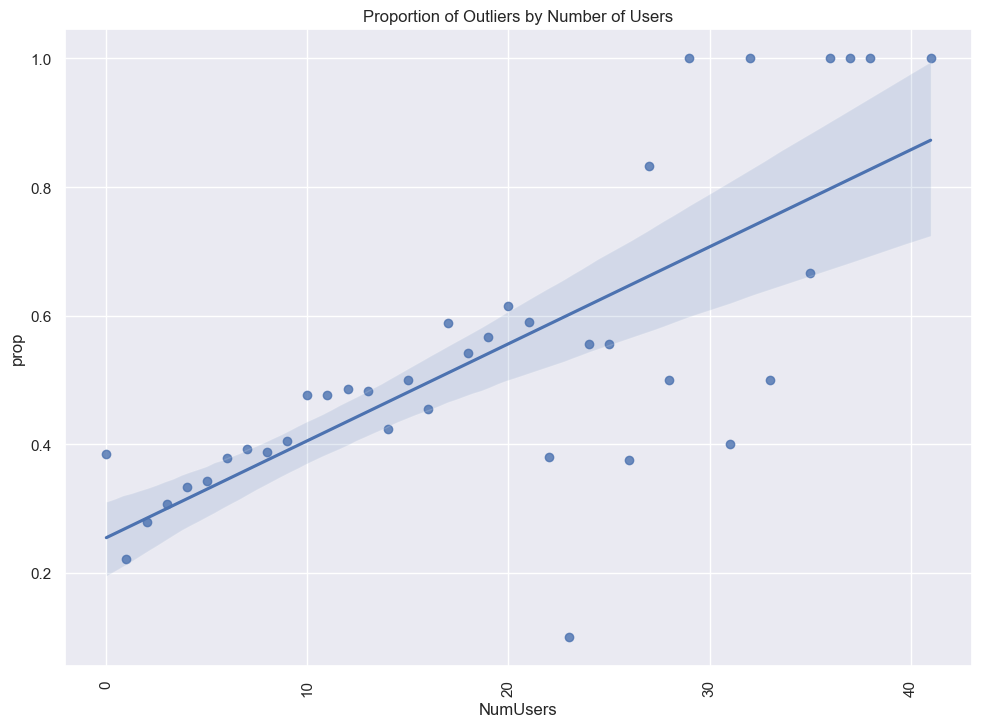

In [1033]:
numUsersCounts = recalcOutlierProps(featureSet[featureSet.ActiveBloom], 'NumUsers')
ax = sns.regplot(numUsersCounts, x='NumUsers', y='prop')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Proportion of Outliers by Number of Users')

Text(0.5, 1.0, 'Proportion of Outliers by Proportion of $ Via EFT')

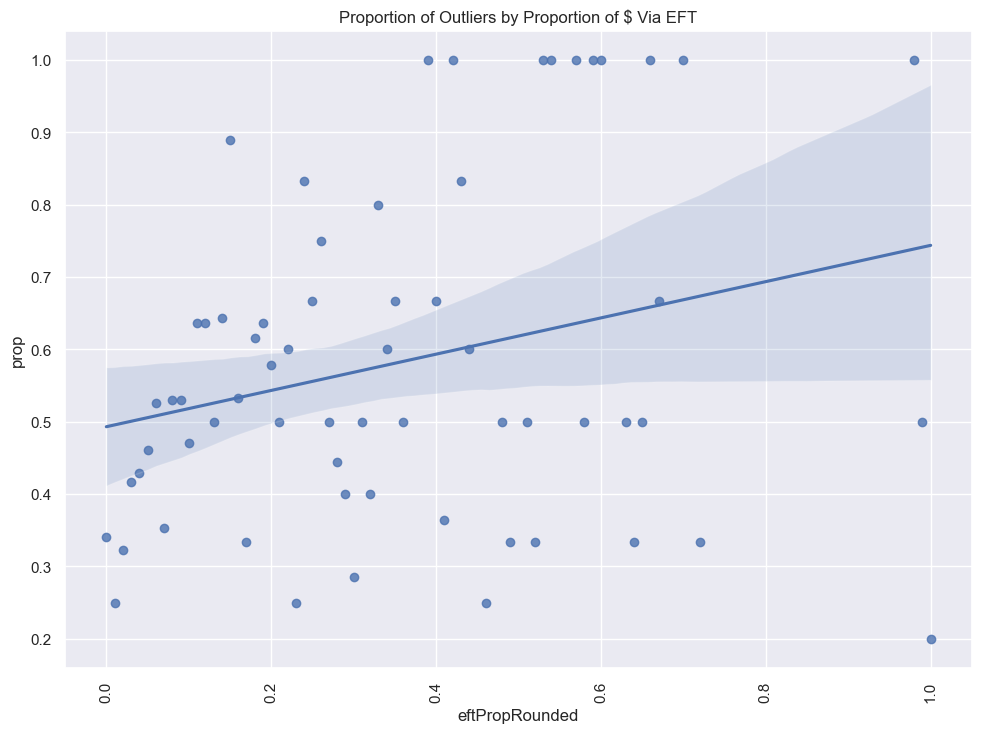

In [1034]:
featureSetRounded = featureSet
featureSetRounded['eftPropRounded'] = featureSetRounded.BloomPayEFTPropAmount.round(2)
eftProp = recalcOutlierProps(featureSetRounded[featureSetRounded.ActiveBQ], 'eftPropRounded')
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
ax = sns.regplot(data=eftProp, x='eftPropRounded', y='prop')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Proportion of Outliers by Proportion of $ Via EFT')

(0.0, 1.1)

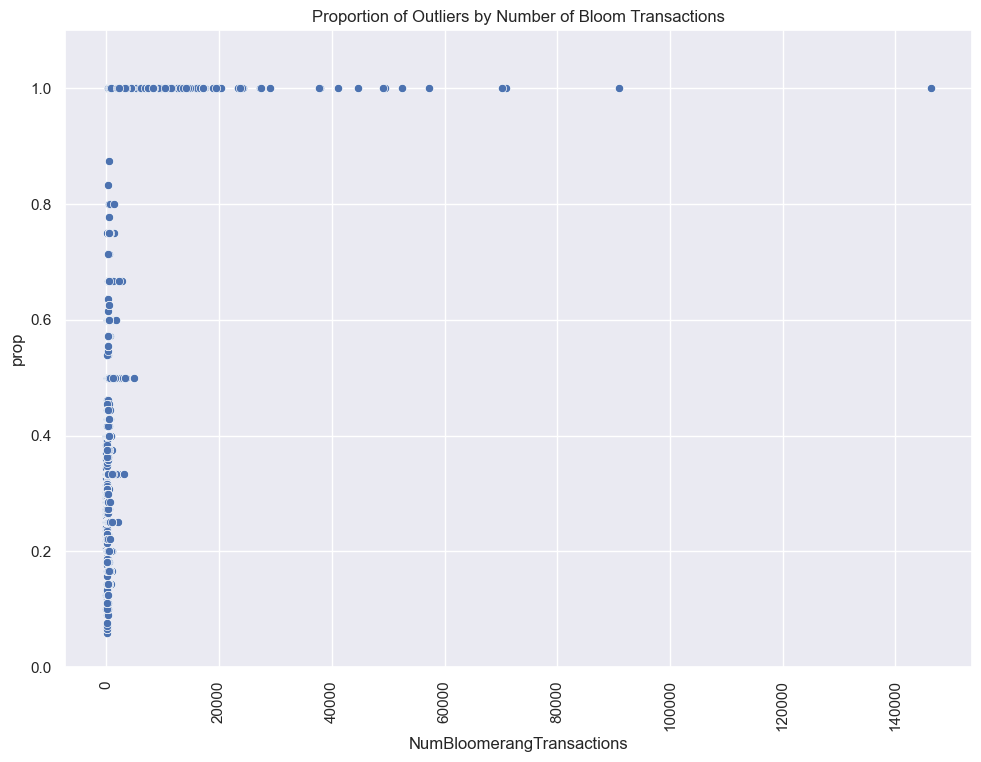

In [1035]:
bloomTransactionProps = recalcOutlierProps(featureSetRounded[featureSetRounded.ActiveBloom], 'NumBloomerangTransactions')
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(data=bloomTransactionProps, x='NumBloomerangTransactions', y='prop')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Proportion of Outliers by Number of Bloom Transactions')
ax.set_ylim(0.0, 1.1)

Text(0.5, 1.0, 'Proportion of Outliers by Unique User Activity on Bloom')

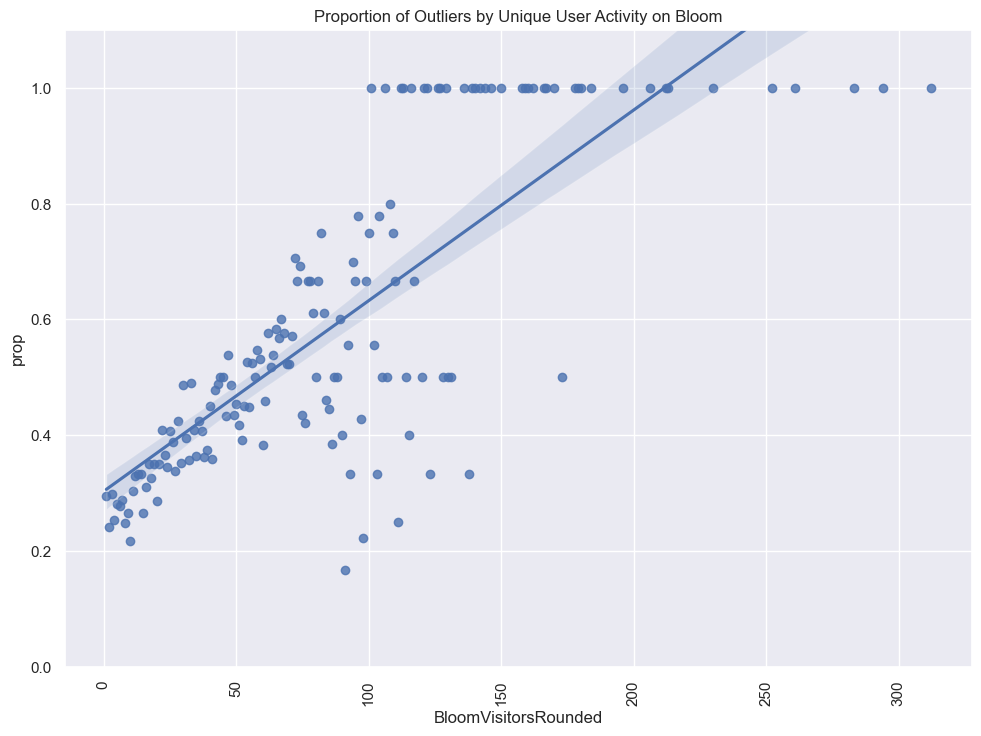

In [1036]:
featureSetRounded['BloomVisitorsRounded'] = featureSetRounded.BloomPendoUniqueVisitorCount.round(2)
bloomVisitorCount = recalcOutlierProps(featureSetRounded[featureSetRounded.ActiveBloom], 'BloomVisitorsRounded')
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
ax = sns.regplot(data=bloomVisitorCount, x='BloomVisitorsRounded', y='prop')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0.0, 1.1)
ax.set_title('Proportion of Outliers by Unique User Activity on Bloom')

Text(0.5, 1.0, 'Proportion of Outliers by Unique User Activity on QGiv')

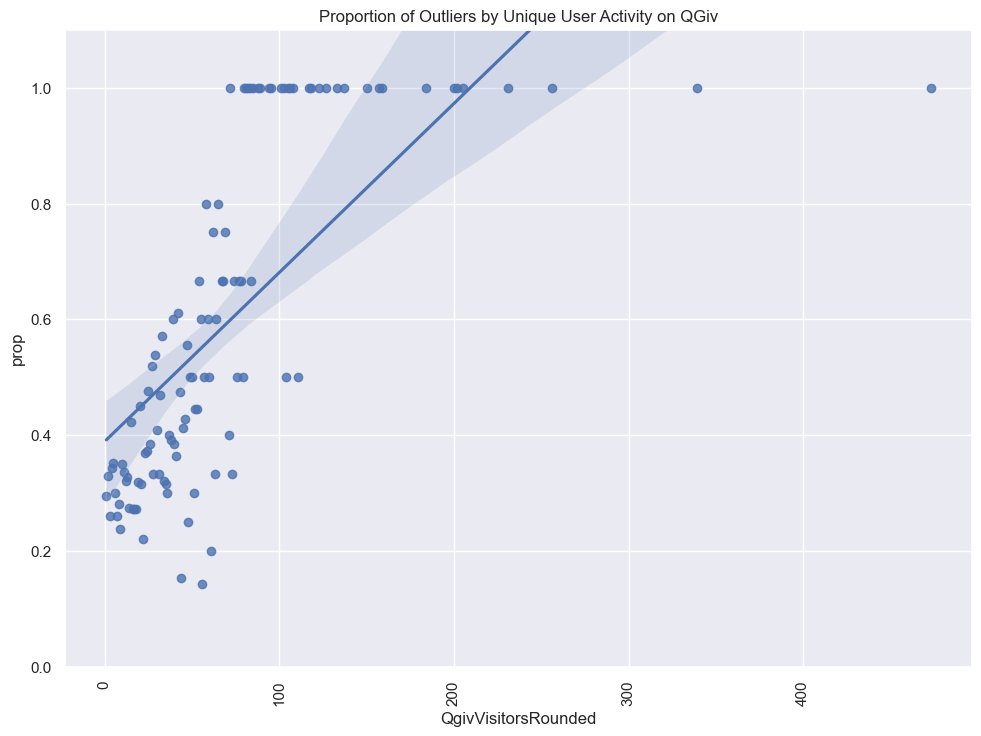

In [1037]:
featureSetRounded['QgivVisitorsRounded'] = featureSetRounded.QGivPendoUniqueVisitorCount.round(2)
qGivVisitorCount = recalcOutlierProps(featureSetRounded[featureSetRounded.ActiveQGiv], 'QgivVisitorsRounded')
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
ax = sns.regplot(data=qGivVisitorCount, x='QgivVisitorsRounded', y='prop')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0.0, 1.1)
ax.set_title('Proportion of Outliers by Unique User Activity on QGiv')

Text(0.5, 1.0, 'Proportion of Outliers by # User Events to Bloom')

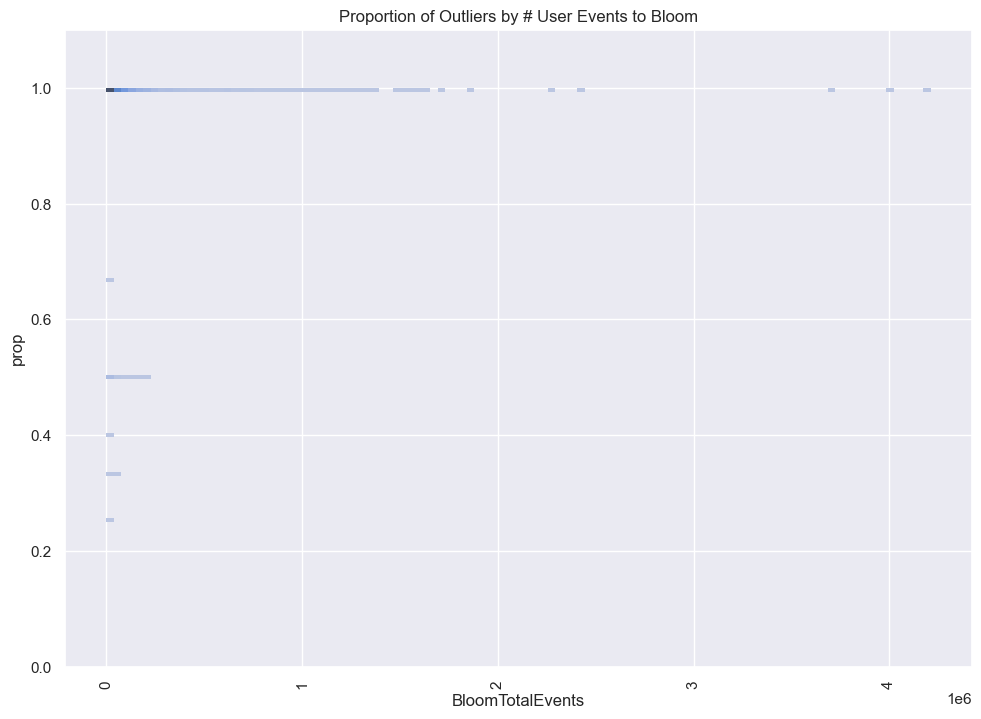

In [1038]:
featureSetRounded['BloomTotalEvents'] = featureSetRounded.BloomPendoTotalEventsCount.round(2)
bloomEventCount = recalcOutlierProps(featureSetRounded[featureSetRounded.ActiveBloom], 'BloomTotalEvents')
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
ax = sns.histplot(data=bloomEventCount, x='BloomTotalEvents', y='prop')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0.0, 1.1)
ax.set_title('Proportion of Outliers by # User Events to Bloom')

Text(0.5, 1.0, 'Proportion of Outliers by # User Events to QGiv')

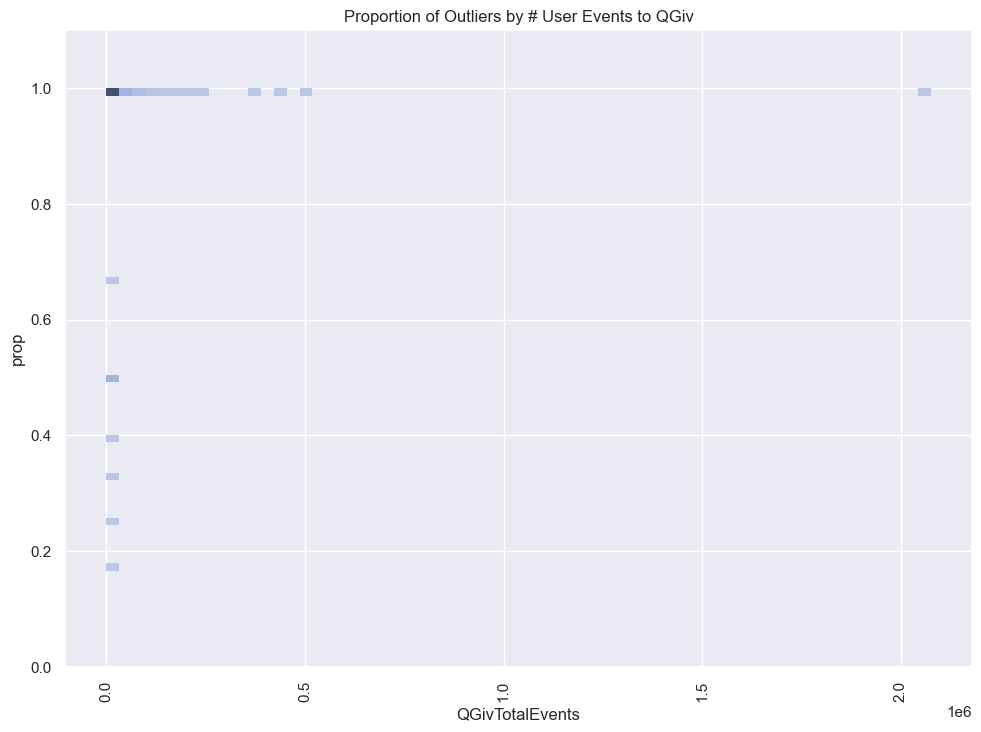

In [1039]:
featureSetRounded['QGivTotalEvents'] = featureSetRounded.QGivPendoTotalEventsCount.round(2)
qGivEventCount = recalcOutlierProps(featureSetRounded[featureSetRounded.ActiveQGiv], 'QGivTotalEvents')
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
ax = sns.histplot(data=qGivEventCount, x='QGivTotalEvents', y='prop')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(0.0, 1.1)
ax.set_title('Proportion of Outliers by # User Events to QGiv')

### X2 test for Metro Area

In [1040]:
# Pre-code dummy variables
featureSetEncoded = pd.get_dummies(featureSet, columns=['CauseIQMetroArea', 'State', 'YearBucketBloom', 'YearBucketQGiv', 'ActiveCustomerType', 'NumUsers'])
featureSetEncoded.head()

AccountID  QGivCustomerId BloomerangDatabaseName KindfulSubdomain  \
0  0011R0000305jX2QAI             NaN                    NaN              NaN   
1  00136000015aBJeAAM             NaN         unitycaregroup              NaN   
2  0011R000025sGmxQAE             NaN                    NaN              NaN   
3  0011R00002YiroEQAR             NaN                    NaN              NaN   
4  0013600001AdgFKAAZ             NaN                    NaN              NaN   

   IsOutlier                                               NTEE  TaxYear  \
0      False                         S41: Promotion of Business     2023   
1      False                  P30: Childrens and Youth Services     2023   
2      False                                P33: Child Day Care     2023   
3      False  B21: Nursery School, Early School Admissions, ...     2023   
4      False                               B29: Charter Schools     2023   

   BloomerangRevenue  QGivRevenue  KFTRevenue  ...  NumUsers_32.0  \
0               0.00          0.0         0.0  ...          False   
1         1071149.37          0.0         0.0  ...          False   
2               0.00          0.0         0.0  ...          False   
3               0.00          0.0         0.0  ...          False   
4               0.00          0.0         0.0  ...          False   

   NumUsers_33.0 NumUsers_35.0 NumUsers_36.0  NumUsers_37.0  NumUsers_38.0  \
0          False         False         False          False          False   
1          False         False         False          False          False   
2          False         False         False          False          False   
3          False         False         False          False          False   
4          False         False         False          False          False   

   NumUsers_41.0  NumUsers_51.0  NumUsers_52.0  NumUsers_53.0  
0          False          False          False          False  
1          False          False          False          False  
2          False          False          False          False  
3          False          False          False          False  
4          False          False          False          False  

[5 rows x 694 columns]

In [1041]:
# Establish population proportions by using the entire market
# and outlier proportions by using only outliers
def getProps(data, col):
    counts = data.groupby(col).IsOutlier.value_counts().reset_index()
    countsOutlier = counts[counts.IsOutlier]
    countsTotal = data[col].value_counts().reset_index()
    countsOutlier.columns = [col, 'IsOutlier', 'OutlierCount']
    countsTotal.columns = [col, 'TotalCount']
    props = pd.merge(countsTotal, countsOutlier, on=col, how='left')
    props.fillna(0, inplace=True)
    props['propTotal'] = props.TotalCount / props.TotalCount.sum()
    props['propOutlier'] = props.OutlierCount  / props.OutlierCount.sum()
    props['propDifference'] = props.propOutlier - props.propTotal
    props['ExpectedCounts'] = props.propTotal * props.OutlierCount.sum()
    return props

In [1042]:
areaProps = getProps(featureSet, 'CauseIQMetroArea')
stats.chisquare(areaProps.OutlierCount, areaProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(4427.32785032299), pvalue=np.float64(0.0))

In [1043]:
# Since there is statistical difference, what are the ones with the largest difference?
# New York-Newark-Jersey City, NY-NJ-PA, Washington-Arlington-Alexandria, DC-VA-MD-WV, Los Angeles-Long Beach-Anaheim, CA
areaProps.sort_values(by = 'propDifference', ascending=False)

CauseIQMetroArea  TotalCount IsOutlier  \
0          New York-Newark-Jersey City, NY-NJ-PA       34704      True   
2   Washington-Arlington-Alexandria, DC-VA-MD-WV       15889      True   
1             Los Angeles-Long Beach-Anaheim, CA       18758      True   
7                Dallas-Fort Worth-Arlington, TX        8967      True   
8           Atlanta-Sandy Springs-Alpharetta, GA        8508      True   
..                                           ...         ...       ...   
48                                 Rochester, NY        1822      True   
43                       Buffalo-Cheektowaga, NY        1926      True   
40         Hartford-East Hartford-Middletown, CT        2094      True   
4                 Boston-Cambridge-Newton, MA-NH       11740      True   
17                                Pittsburgh, PA        4691      True   

    OutlierCount  propTotal  propOutlier  propDifference  ExpectedCounts  
0         8404.0   0.080668     0.100788        0.020120     6726.367443  
2         4265.0   0.036933     0.051150        0.014216     3079.623452  
1         4460.0   0.043602     0.053488        0.009886     3635.696187  
7         2236.0   0.020844     0.026816        0.005973     1737.993801  
8         2095.0   0.019777     0.025125        0.005348     1649.029916  
..           ...        ...          ...             ...             ...  
48         209.0   0.004235     0.002507       -0.001729      353.142044  
43         225.0   0.004477     0.002698       -0.001779      373.299438  
40         257.0   0.004867     0.003082       -0.001785      405.861383  
4         2080.0   0.027289     0.024945       -0.002344     2275.459710  
17         622.0   0.010904     0.007460       -0.003445      909.214779  

[392 rows x 8 columns]

Text(0.5, 1.0, 'Difference Between Expected and Observed Metro Area Proportions in Outliers')

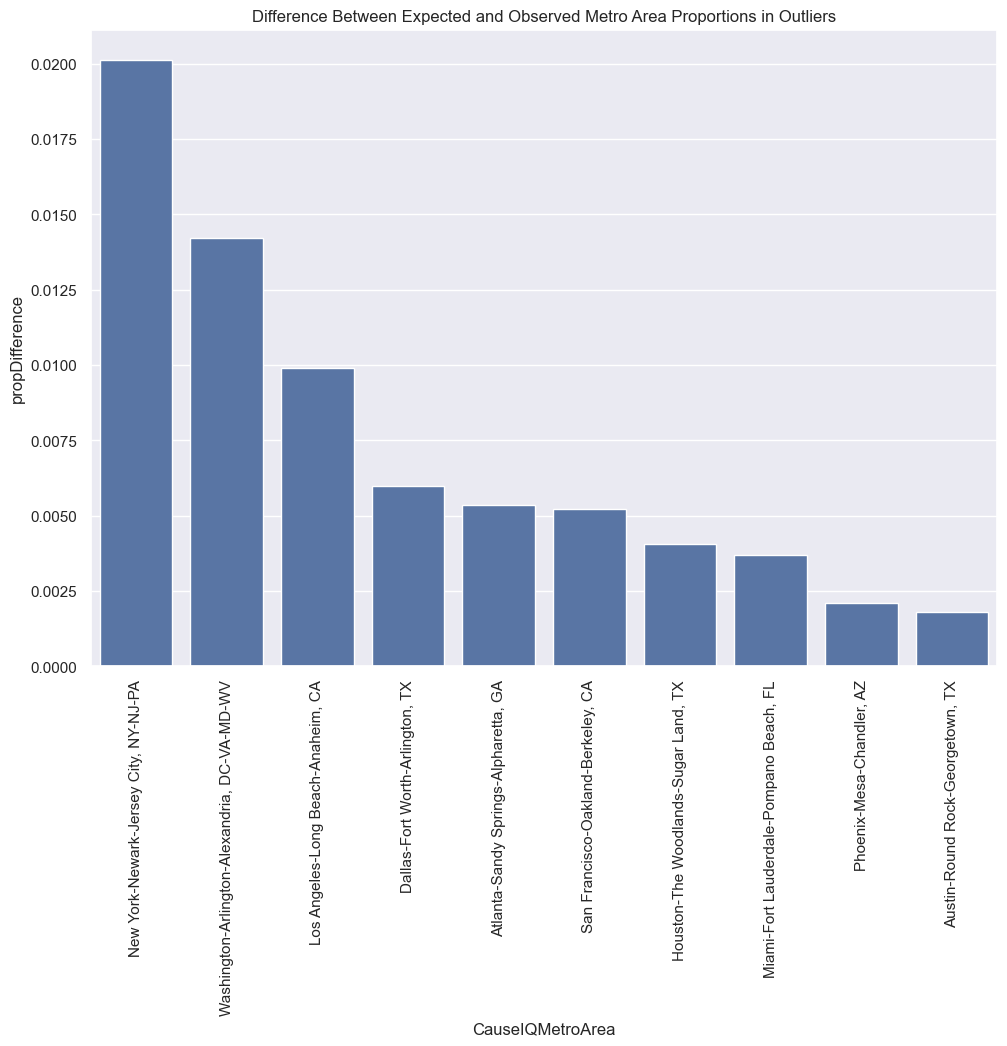

In [1044]:
#Metro Area
ax = sns.barplot(data=areaProps.sort_values(by = 'propDifference', ascending=False).iloc[0:10], x='CauseIQMetroArea', y='propDifference')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Difference Between Expected and Observed Metro Area Proportions in Outliers')

In [1045]:
## Add columns
potentialEncodedVarsList = []
areaCols = ['CauseIQMetroArea_' + c for c in areaProps.sort_values(by = 'propDifference', ascending=False).iloc[0:10].CauseIQMetroArea.to_list()]
potentialEncodedVarsList = potentialEncodedVarsList + areaCols

### X2 test for State

In [1046]:
stateProps = getProps(featureSet[featureSet.State != 'None'], 'State')
stats.chisquare(stateProps.OutlierCount, stateProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(2006.1922695050632), pvalue=np.float64(0.0))

In [1047]:
# Since there is statistical difference, what are the ones with the largest difference?
# NY, PA, MA, OH, IL, NC, MI, MN, MO, IN break the 1% line
# NY is a strong standout
# PA is a medium-strong standout
statePropResults = stateProps.sort_values(by = 'propDifference', ascending=False)
statePropResults.iloc[0:20]

State  TotalCount IsOutlier  OutlierCount  propTotal  \
7                     DC       15555      True        4148.0   0.036027   
0                     CA       55320      True       11861.0   0.128126   
2                     TX       28988      True        6538.0   0.067139   
1                     NY       45162      True        9565.0   0.104599   
9                     GA       11915      True        2690.0   0.027596   
3                     FL       24921      True        5143.0   0.057719   
15                    CO        8720      True        1845.0   0.020196   
20                    AZ        7037      True        1510.0   0.016298   
16                    TN        8448      True        1772.0   0.019566   
28                    OK        3722      True         836.0   0.008620   
30                    UT        2969      True         654.0   0.006876   
32                    NV        2720      True         589.0   0.006300   
25                    AL        4836      True         994.0   0.011201   
34                    AR        2333      True         480.0   0.005403   
49                    PR         623      True         136.0   0.001443   
45                    MT        1047      True         210.0   0.002425   
55                    BC           3      True           3.0   0.000007   
58                    TX           2      True           2.0   0.000005   
52  District of Columbia          10      True           3.0   0.000023   
72      British Columbia           1      True           1.0   0.000002   

    propOutlier  propDifference  ExpectedCounts  
7      0.049465        0.013438     3021.134769  
0      0.141441        0.013315    10744.402147  
2      0.077965        0.010826     5630.128877  
1      0.114062        0.009463     8771.487523  
9      0.032078        0.004482     2314.163984  
3      0.061330        0.003611     4840.224980  
15     0.022001        0.001805     1693.622320  
20     0.018007        0.001708     1366.745443  
16     0.021131        0.001565     1640.793734  
28     0.009969        0.001349      722.897050  
30     0.007799        0.000922      576.647324  
32     0.007024        0.000724      528.285861  
25     0.011853        0.000653      939.261186  
34     0.005724        0.000321      453.121660  
49     0.001622        0.000179      121.000769  
45     0.002504        0.000079      203.351212  
55     0.000036        0.000029        0.582668  
58     0.000024        0.000019        0.388445  
52     0.000036        0.000013        1.942227  
72     0.000012        0.000010        0.194223

Text(0.5, 1.0, 'Difference Between Expected and Observed State Proportions in Outliers')

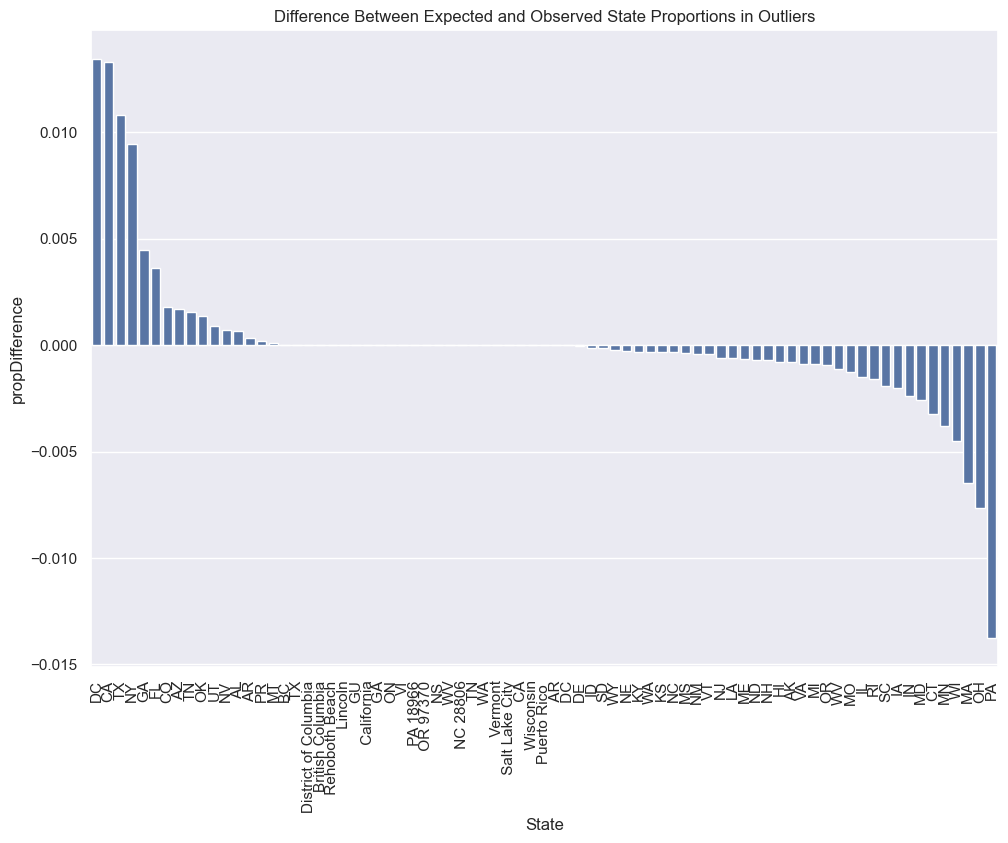

In [1048]:
# Add labels, rotate axes
ax = sns.barplot(data=statePropResults, x='State', y='propDifference')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Difference Between Expected and Observed State Proportions in Outliers')

Text(0.5, 1.0, 'Top Ten: Difference Between Expected and Observed State Proportions in Outliers')

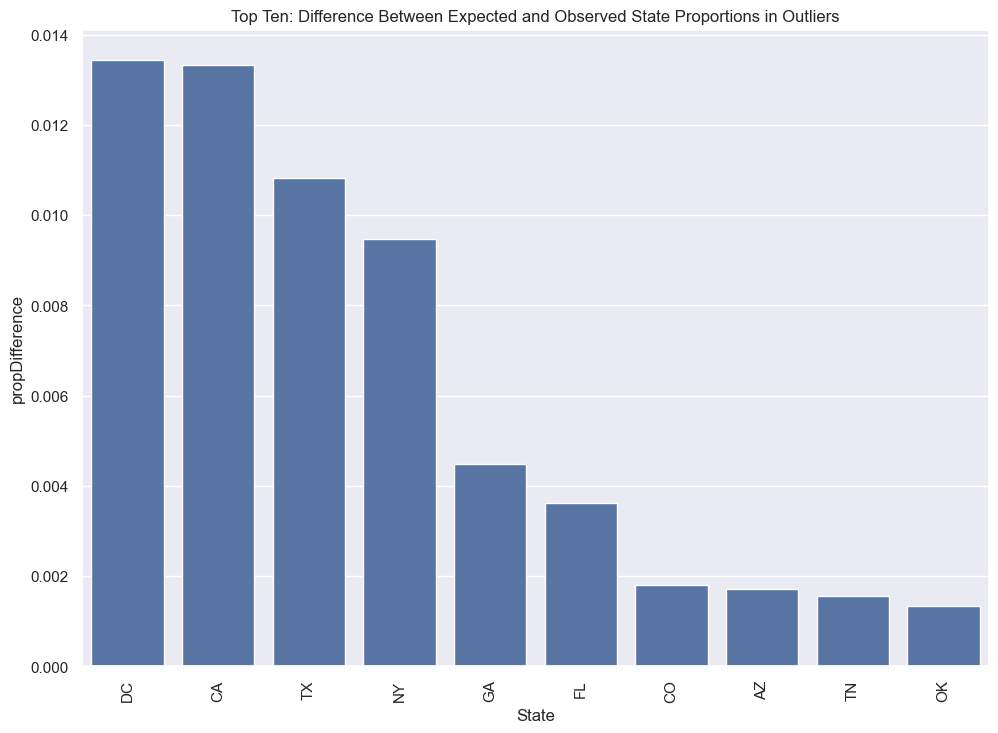

In [1049]:
# Top 10 states
ax = sns.barplot(data=statePropResults.iloc[0:10], x='State', y='propDifference')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Top Ten: Difference Between Expected and Observed State Proportions in Outliers')

In [1050]:
## Add columns
areaCols = ['State_' + c for c in stateProps.sort_values(by = 'propDifference', ascending=False).iloc[0:10].State.to_list()]
potentialEncodedVarsList = potentialEncodedVarsList + areaCols
potentialEncodedVarsList

['CauseIQMetroArea_New York-Newark-Jersey City, NY-NJ-PA',
 'CauseIQMetroArea_Washington-Arlington-Alexandria, DC-VA-MD-WV',
 'CauseIQMetroArea_Los Angeles-Long Beach-Anaheim, CA',
 'CauseIQMetroArea_Dallas-Fort Worth-Arlington, TX',
 'CauseIQMetroArea_Atlanta-Sandy Springs-Alpharetta, GA',
 'CauseIQMetroArea_San Francisco-Oakland-Berkeley, CA',
 'CauseIQMetroArea_Houston-The Woodlands-Sugar Land, TX',
 'CauseIQMetroArea_Miami-Fort Lauderdale-Pompano Beach, FL',
 'CauseIQMetroArea_Phoenix-Mesa-Chandler, AZ',
 'CauseIQMetroArea_Austin-Round Rock-Georgetown, TX',
 'State_DC',
 'State_CA',
 'State_TX',
 'State_NY',
 'State_GA',
 'State_FL',
 'State_CO',
 'State_AZ',
 'State_TN',
 'State_OK']

### X2 test for Tenure (Bloom and QGiv)

In [1051]:
bloomTenureProps = getProps(featureSet, 'YearBucketBloom')
stats.chisquare(bloomTenureProps.OutlierCount, bloomTenureProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(10.090408567526767), pvalue=np.float64(0.03893198979944203))

In [1052]:
# What this tells us is that the real differentiator is whether you have the product or not
# Since the tenure effect disappears when we zoom in on active customers
bloomTenureProps = getProps(featureSet[featureSet.ActiveBloom], 'YearBucketBloom')
stats.chisquare(bloomTenureProps.OutlierCount, bloomTenureProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(4.442873392052746), pvalue=np.float64(0.3493750621834073))

In [1053]:
# Larg differences at 6-15 years, so would suggest a flag for 6+ years vs. not
bloomTenureProps.sort_values(by = 'propDifference', ascending=False)

YearBucketBloom  TotalCount  IsOutlier  OutlierCount  propTotal  \
3       6-8 years        1842       True           743   0.190644   
2      9-11 years        2289       True           876   0.236907   
4     12-15 years          25       True            11   0.002587   
1       3-5 years        2530       True           962   0.261851   
0       0-2 years        2976       True          1089   0.308011   

   propOutlier  propDifference  ExpectedCounts  
3     0.201847        0.011204      701.759677  
2     0.237979        0.001071      872.056407  
4     0.002988        0.000401        9.524426  
1     0.261342       -0.000509      963.871869  
0     0.295844       -0.012167     1133.787622

Text(0.5, 1.0, 'Difference Between Expected and Observed Bloom Tenure Proportions in Outliers')

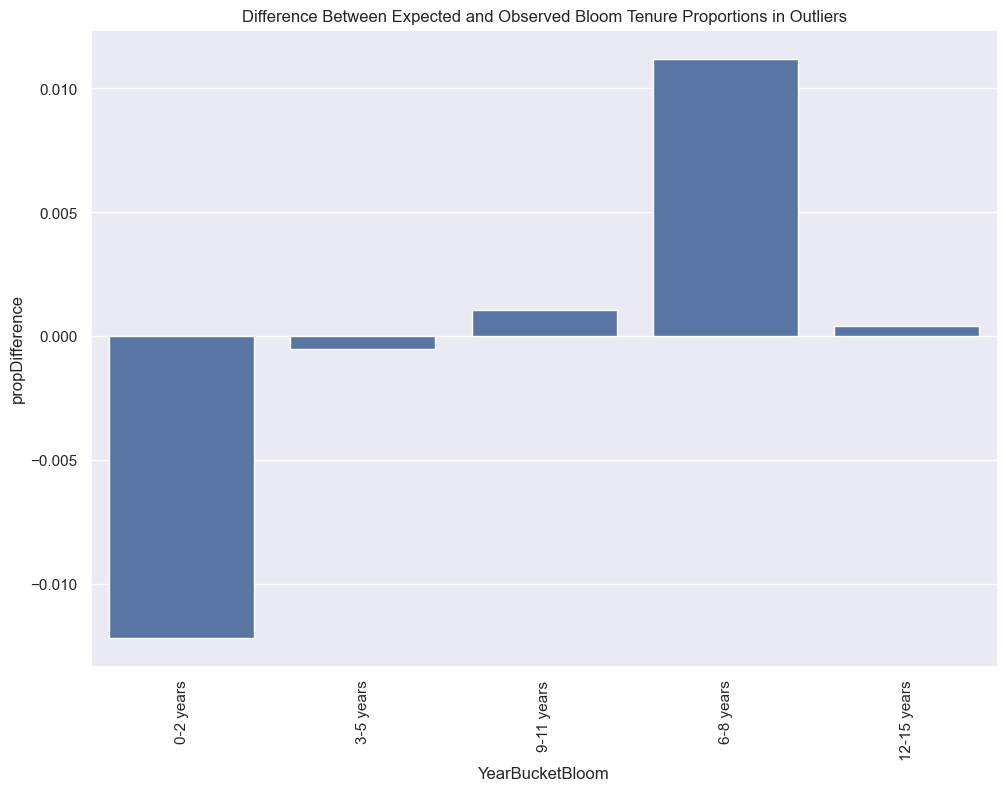

In [1054]:
# Add labels, rotate axes
ax = sns.barplot(data=bloomTenureProps, x='YearBucketBloom', y='propDifference')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Difference Between Expected and Observed Bloom Tenure Proportions in Outliers')

In [1055]:
# Code for 6+ years
featureSet['BloomTenure6Plus'] = featureSet.YearBucketBloom.isin(['6-8 years', '9-11 years', '12-15 years'])
potentialVarsList.append('BloomTenure6Plus')

In [1056]:
# No sig difference for qGiv tenure
qGivTenureProps = getProps(featureSet, 'YearBucketQGiv')
stats.chisquare(qGivTenureProps.OutlierCount, qGivTenureProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(2.850564246166604), pvalue=np.float64(0.5831363368390015))

In [1057]:
qGivTenureProps = getProps(featureSet[featureSet.ActiveQGiv], 'YearBucketQGiv')
stats.chisquare(qGivTenureProps.OutlierCount, qGivTenureProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(1.8472887103164097), pvalue=np.float64(0.7638201933046068))

### X2 test for Active Customer Type

In [1058]:
activeCustomerTypeProps = getProps(featureSet, 'ActiveCustomerType')
stats.chisquare(activeCustomerTypeProps.OutlierCount, activeCustomerTypeProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(171.8518343099653), pvalue=np.float64(1.8204316049111397e-34))

In [1059]:
activeCustomerTypeProps = getProps(featureSet[featureSet.ActiveAnyBQK], 'ActiveCustomerType')
stats.chisquare(activeCustomerTypeProps.OutlierCount, activeCustomerTypeProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(171.8518343099653), pvalue=np.float64(1.8204316049111397e-34))

In [1060]:
# Strongest difference is for having Kindful alone, then BQ. Others are miniscule, not worth worrying about.
activeCustomerTypeProps.sort_values(by = 'propDifference', ascending=False)

ActiveCustomerType  TotalCount  IsOutlier  OutlierCount  propTotal  \
2                  K        1826       True           973   0.129577   
3                 BQ         692       True           313   0.049106   
4                 BK         151       True            89   0.010715   
5                 QK          30       True            18   0.002129   
6                BQK           5       True             3   0.000355   
0                  B        8814       True          3276   0.625461   
1                  Q        2574       True           799   0.182657   

   propOutlier  propDifference  ExpectedCounts  
2     0.177847        0.048270      708.916123  
3     0.057211        0.008105      268.658246  
4     0.016268        0.005552       58.623403  
5     0.003290        0.001161       11.647034  
6     0.000548        0.000194        1.941172  
0     0.598794       -0.026668     3421.898524  
1     0.146043       -0.036614      999.315498

Text(0.5, 1.0, 'Difference Between Expected and Observed Customer Type Proportions in Outliers')

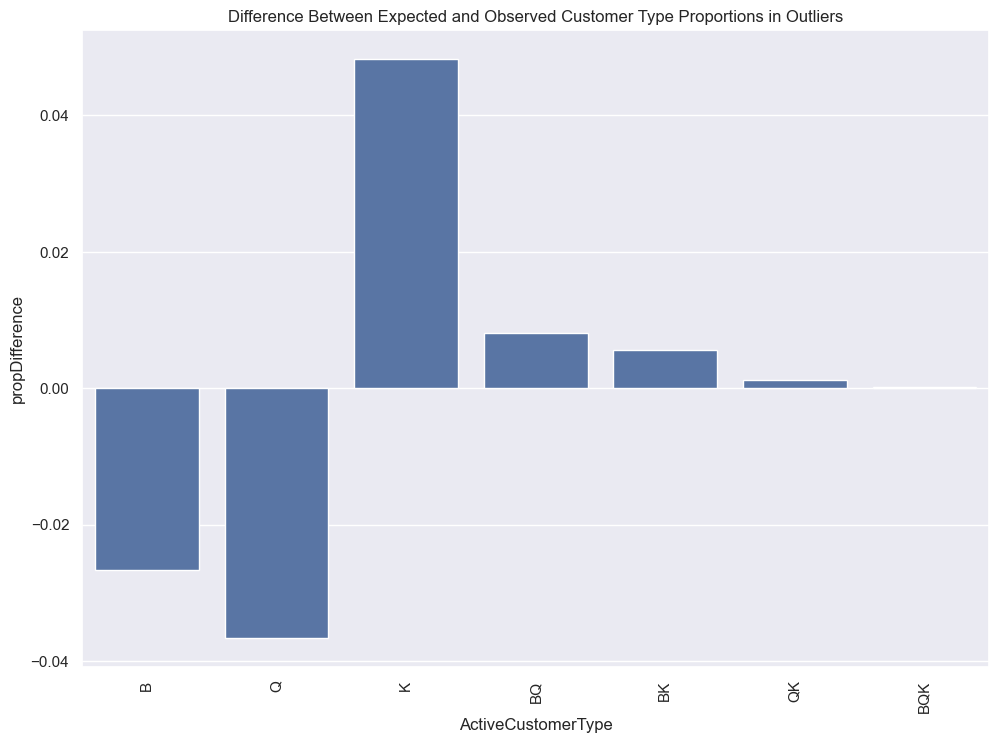

In [1061]:
ax = sns.barplot(data=activeCustomerTypeProps, x='ActiveCustomerType', y='propDifference')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Difference Between Expected and Observed Customer Type Proportions in Outliers')

In [1062]:
# Code for customer type
featureSet['ActiveCustomerTypeKOrQK'] = featureSet.ActiveCustomerType.isin(['K', 'QK'])
featureSet['ActiveCustomerTypeBPlusQOrK'] = featureSet.ActiveCustomerType.isin(['BQ', 'BK', 'BQK'])
potentialVarsList.append('ActiveCustomerTypeKOrQK')
potentialVarsList.append('ActiveCustomerTypeBPlusQOrK')

### X2 test for Number of Users (Bloom)

In [1063]:
numUsersProps = getProps(featureSet, 'UsersBucket')
stats.chisquare(numUsersProps.OutlierCount, numUsersProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(172.88408363754405), pvalue=np.float64(2.51430826930063e-36))

In [1064]:
numUsersProps = getProps(featureSet[featureSet.ActiveBloom], 'UsersBucket')
stats.chisquare(numUsersProps.OutlierCount, numUsersProps.ExpectedCounts)

Power_divergenceResult(statistic=np.float64(94.53023328779136), pvalue=np.float64(1.4343462923629536e-19))

In [1065]:
# Having 12+ users, then 9-11, then 6-8, makes a difference. Suggest using a flag for 6+ vs. not
numUsersProps.sort_values(by = 'propDifference', ascending=False)

UsersBucket  TotalCount  IsOutlier  OutlierCount  propTotal  propOutlier  \
3    12+ users        1124       True           557   0.116344     0.151359   
2  09-11 users        1456       True           648   0.150709     0.176087   
1  06-08 users        3055       True          1178   0.316220     0.320109   
4  00-02 users         614       True           172   0.063554     0.046739   
0  03-05 users        3412       True          1125   0.353173     0.305707   

   propDifference  ExpectedCounts  
3        0.035015      428.146155  
2        0.025378      554.609254  
1        0.003889     1163.689059  
4       -0.016815      233.880551  
0       -0.047466     1299.674982

Text(0.5, 1.0, 'Difference Between Expected and Observed Num User Proportions in Outliers')

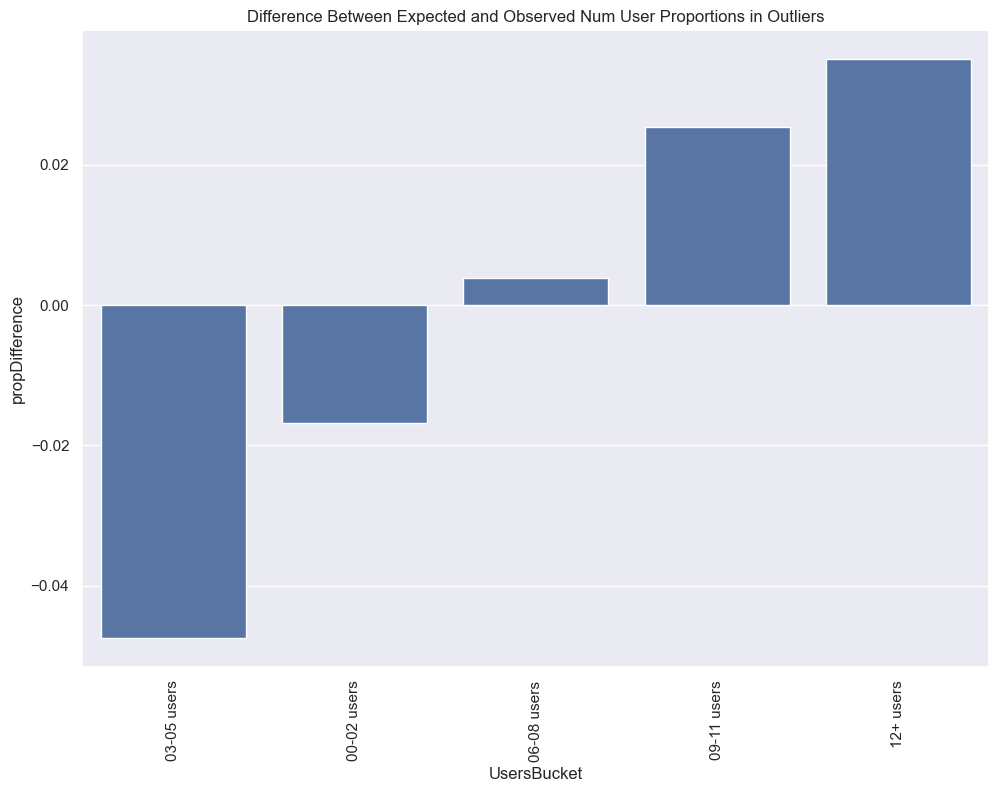

In [1066]:
ax = sns.barplot(data=numUsersProps.sort_values(by = 'propDifference', ascending=True), x='UsersBucket', y='propDifference')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Difference Between Expected and Observed Num User Proportions in Outliers')

In [1067]:
# Code for customer type
featureSet['NumUsersGreaterThan5'] = featureSet.NumUsers > 5
potentialVarsList.append('NumUsersGreaterThan5')

# Prediction

This section walks through building a predictive model of outlier status. The goal is to differentiate outliers from not, and the difference between this and the previous section is that now we look at the variables *in concert* rather than just one at a time.

This section depends on some variable manipulation don in the "Differentiate Outliers vs. Not" section. That section begins with a fresh query and does not depend on earlier sections. Therefore, you can run from that section through this section without running the entire notebook.

In [1068]:
# Remove the outlier flag itself and view variables that are to be included
potentialVarsList

['IsOutlier',
 'NumUsers',
 'BloomPayEFTPropAmount',
 'BloomPendoUniqueVisitorCount',
 'BloomPendoTotalEventsCount',
 'QGivPendoUniqueVisitorCount',
 'QGivPendoTotalEventsCount',
 'NumBloomerangTransactions',
 'BloomerangRevenue',
 'QGivRevenue',
 'BloomerangQGivRevenue',
 'BloomerangTotalRevenue',
 'HasAplos',
 'QGivPayCCPropAmount',
 'QGivPayECheckPropAmount',
 'NumConstituentsCreated',
 'NumConstituentsCreatedCurrentlyActive',
 'NumConstituentsCreatedInHousehold',
 'NumConstituentsCreatedInHouseholdAndActive',
 'NumConstituentsCum',
 'NumConstituentsCurrentlyActiveCum',
 'NumConstituentsInHouseholdCum',
 'NumConstituentsInHouseholdAndActiveCum',
 'EmailsSent',
 'EmailRecipients',
 'BloomPendoUniqueVisitorCount_1',
 'PendoUniqueVisitorCount',
 'PendoTotalEventsCount',
 'BloomTenure6Plus',
 'ActiveCustomerTypeKOrQK',
 'ActiveCustomerTypeBPlusQOrK',
 'NumUsersGreaterThan5']

In [1069]:
potentialEncodedVarsList

['CauseIQMetroArea_New York-Newark-Jersey City, NY-NJ-PA',
 'CauseIQMetroArea_Washington-Arlington-Alexandria, DC-VA-MD-WV',
 'CauseIQMetroArea_Los Angeles-Long Beach-Anaheim, CA',
 'CauseIQMetroArea_Dallas-Fort Worth-Arlington, TX',
 'CauseIQMetroArea_Atlanta-Sandy Springs-Alpharetta, GA',
 'CauseIQMetroArea_San Francisco-Oakland-Berkeley, CA',
 'CauseIQMetroArea_Houston-The Woodlands-Sugar Land, TX',
 'CauseIQMetroArea_Miami-Fort Lauderdale-Pompano Beach, FL',
 'CauseIQMetroArea_Phoenix-Mesa-Chandler, AZ',
 'CauseIQMetroArea_Austin-Round Rock-Georgetown, TX',
 'State_DC',
 'State_CA',
 'State_TX',
 'State_NY',
 'State_GA',
 'State_FL',
 'State_CO',
 'State_AZ',
 'State_TN',
 'State_OK']

In [1070]:
# Get regular variable columns
featureSetReduced = featureSet[potentialVarsList]
featureSetReduced.head()

IsOutlier  NumUsers  BloomPayEFTPropAmount  BloomPendoUniqueVisitorCount  \
0      False       NaN                    NaN                           NaN   
1      False       7.0                0.03837                          19.0   
2      False       NaN                    NaN                           NaN   
3      False       NaN                    NaN                           NaN   
4      False       NaN                    NaN                           NaN   

   BloomPendoTotalEventsCount  QGivPendoUniqueVisitorCount  \
0                         NaN                          NaN   
1                     19490.0                          NaN   
2                         NaN                          NaN   
3                         NaN                          NaN   
4                         NaN                          NaN   

   QGivPendoTotalEventsCount  NumBloomerangTransactions  BloomerangRevenue  \
0                        NaN                        NaN               0.00   
1                        NaN                      132.0         1071149.37   
2                        NaN                        NaN               0.00   
3                        NaN                        NaN               0.00   
4                        NaN                        NaN               0.00   

   QGivRevenue  ...  NumConstituentsInHouseholdAndActiveCum  EmailsSent  \
0          0.0  ...                                     NaN         NaN   
1          0.0  ...                                   186.0       612.0   
2          0.0  ...                                     NaN         NaN   
3          0.0  ...                                     NaN         NaN   
4          0.0  ...                                     NaN         NaN   

   EmailRecipients  BloomPendoUniqueVisitorCount_1  PendoUniqueVisitorCount  \
0              NaN                               0                        0   
1            534.0                              19                       19   
2              NaN                               0                        0   
3              NaN                               0                        0   
4              NaN                               0                        0   

   PendoTotalEventsCount  BloomTenure6Plus  ActiveCustomerTypeKOrQK  \
0                      0             False                    False   
1                  19490              True                    False   
2                      0             False                    False   
3                      0             False                    False   
4                      0             False                    False   

   ActiveCustomerTypeBPlusQOrK  NumUsersGreaterThan5  
0                        False                 False  
1                        False                  True  
2                        False                 False  
3                        False                 False  
4                        False                 False  

[5 rows x 32 columns]

In [1071]:
featureSetEncodedReduced = featureSetEncoded[potentialEncodedVarsList]
featureSetEncodedReduced

CauseIQMetroArea_New York-Newark-Jersey City, NY-NJ-PA  \
0                                                   False        
1                                                   False        
2                                                   False        
3                                                   False        
4                                                   False        
...                                                   ...        
491973                                              False        
491974                                              False        
491975                                              False        
491976                                              False        
491977                                              False        

        CauseIQMetroArea_Washington-Arlington-Alexandria, DC-VA-MD-WV  \
0                                                   False               
1                                                   False               
2                                                   False               
3                                                    True               
4                                                   False               
...                                                   ...               
491973                                              False               
491974                                              False               
491975                                              False               
491976                                              False               
491977                                              False               

        CauseIQMetroArea_Los Angeles-Long Beach-Anaheim, CA  \
0                                                   False     
1                                                   False     
2                                                   False     
3                                                   False     
4                                                   False     
...                                                   ...     
491973                                              False     
491974                                              False     
491975                                              False     
491976                                              False     
491977                                              False     

        CauseIQMetroArea_Dallas-Fort Worth-Arlington, TX  \
0                                                  False   
1                                                  False   
2                                                  False   
3                                                  False   
4                                                   True   
...                                                  ...   
491973                                             False   
491974                                             False   
491975                                             False   
491976                                             False   
491977                                             False   

        CauseIQMetroArea_Atlanta-Sandy Springs-Alpharetta, GA  \
0                                                   False       
1                                                   False       
2                                                   False       
3                                                   False       
4                                                   False       
...                                                   ...       
491973                                              False       
491974                                              False       
491975                                               True       
491976                                              False       
491977                                              False       

        CauseIQMetroArea_San Francisco-Oakland-Berkeley, CA  \
0               

In [1072]:
# Combine the regular and one-hot encoded datasets
featureSetReduced = pd.concat([featureSetReduced, featureSetEncodedReduced], axis=1)
featureSetReduced

IsOutlier  NumUsers  BloomPayEFTPropAmount  \
0           False       NaN                    NaN   
1           False       7.0                0.03837   
2           False       NaN                    NaN   
3           False       NaN                    NaN   
4           False       NaN                    NaN   
...           ...       ...                    ...   
491973      False       NaN                    NaN   
491974      False       NaN                    NaN   
491975       True       NaN                    NaN   
491976      False       NaN                    NaN   
491977       True       NaN                    NaN   

        BloomPendoUniqueVisitorCount  BloomPendoTotalEventsCount  \
0                                NaN                         NaN   
1                               19.0                     19490.0   
2                                NaN                         NaN   
3                                NaN                         NaN   
4                                NaN                         NaN   
...                              ...                         ...   
491973                           NaN                         NaN   
491974                           NaN                         NaN   
491975                           NaN                         NaN   
491976                           NaN                         NaN   
491977                           NaN                         NaN   

        QGivPendoUniqueVisitorCount  QGivPendoTotalEventsCount  \
0                               NaN                        NaN   
1                               NaN                        NaN   
2                               NaN                        NaN   
3                               NaN                        NaN   
4                               NaN                        NaN   
...                             ...                        ...   
491973                          NaN                        NaN   
491974                          NaN                        NaN   
491975                          NaN                        NaN   
491976                          NaN                        NaN   
491977                          NaN                        NaN   

        NumBloomerangTransactions  BloomerangRevenue  QGivRevenue  ...  \
0                             NaN               0.00          0.0  ...   
1                           132.0         1071149.37          0.0  ...   
2                             NaN               0.00          0.0  ...   
3                             NaN               0.00          0.0  ...   
4                             NaN               0.00          0.0  ...   
...                           ...                ...          ...  ...   
491973                        NaN               0.00          0.0  ...   
491974                        NaN               0.00          0.0  ...   
491975                        NaN               0.00          0.0  ...   
491976                        NaN               0.00          0.0  ...   
491977                        NaN               0.00          0.0  ...   

        State_DC  State_CA  State_TX  State_NY  State_GA  State_FL  State_CO  \
0          False     False     False     False     False     False     False   
1          False      True     False     False     False     False     False   
2          False     False     False     False     False      True     False   
3           True     False     False     False     False     False     False   
4          False     False      True     False     False     False     False   
...          ...       ...       ...       ...       ...       ...       ...   
491973     False     False      True     False     False     False     False   
491974     False     False     False     False     False     False     False   
491975     False     False     False     False      True     False     False   
491976     False     False     False     False     False    

In [1075]:
featureSetReduced

IsOutlier  NumUsers  BloomPayEFTPropAmount  \
0           False       NaN                    NaN   
1           False       7.0                0.03837   
2           False       NaN                    NaN   
3           False       NaN                    NaN   
4           False       NaN                    NaN   
...           ...       ...                    ...   
491973      False       NaN                    NaN   
491974      False       NaN                    NaN   
491975       True       NaN                    NaN   
491976      False       NaN                    NaN   
491977       True       NaN                    NaN   

        BloomPendoUniqueVisitorCount  BloomPendoTotalEventsCount  \
0                                NaN                         NaN   
1                               19.0                     19490.0   
2                                NaN                         NaN   
3                                NaN                         NaN   
4                                NaN                         NaN   
...                              ...                         ...   
491973                           NaN                         NaN   
491974                           NaN                         NaN   
491975                           NaN                         NaN   
491976                           NaN                         NaN   
491977                           NaN                         NaN   

        QGivPendoUniqueVisitorCount  QGivPendoTotalEventsCount  \
0                               NaN                        NaN   
1                               NaN                        NaN   
2                               NaN                        NaN   
3                               NaN                        NaN   
4                               NaN                        NaN   
...                             ...                        ...   
491973                          NaN                        NaN   
491974                          NaN                        NaN   
491975                          NaN                        NaN   
491976                          NaN                        NaN   
491977                          NaN                        NaN   

        NumBloomerangTransactions  BloomerangRevenue  QGivRevenue  ...  \
0                             NaN               0.00          0.0  ...   
1                           132.0         1071149.37          0.0  ...   
2                             NaN               0.00          0.0  ...   
3                             NaN               0.00          0.0  ...   
4                             NaN               0.00          0.0  ...   
...                           ...                ...          ...  ...   
491973                        NaN               0.00          0.0  ...   
491974                        NaN               0.00          0.0  ...   
491975                        NaN               0.00          0.0  ...   
491976                        NaN               0.00          0.0  ...   
491977                        NaN               0.00          0.0  ...   

        State_DC  State_CA  State_TX  State_NY  State_GA  State_FL  State_CO  \
0          False     False     False     False     False     False     False   
1          False      True     False     False     False     False     False   
2          False     False     False     False     False      True     False   
3           True     False     False     False     False     False     False   
4          False     False      True     False     False     False     False   
...          ...       ...       ...       ...       ...       ...       ...   
491973     False     False      True     False     False     False     False   
491974     False     False     False     False     False     False     False   
491975     False     False     False     False      True     False     False   
491976     False     False     False     False     False    

In [1099]:
featureSetReduced['IsOutlierName'] = featureSetReduced.IsOutlier.astype('string')
featureSetReduced.fillna(0, inplace=True)
featureSetReduced

IsOutlier  NumUsers  BloomPayEFTPropAmount  \
0           False       0.0                0.00000   
1           False       7.0                0.03837   
2           False       0.0                0.00000   
3           False       0.0                0.00000   
4           False       0.0                0.00000   
...           ...       ...                    ...   
491973      False       0.0                0.00000   
491974      False       0.0                0.00000   
491975       True       0.0                0.00000   
491976      False       0.0                0.00000   
491977       True       0.0                0.00000   

        BloomPendoUniqueVisitorCount  BloomPendoTotalEventsCount  \
0                                0.0                         0.0   
1                               19.0                     19490.0   
2                                0.0                         0.0   
3                                0.0                         0.0   
4                                0.0                         0.0   
...                              ...                         ...   
491973                           0.0                         0.0   
491974                           0.0                         0.0   
491975                           0.0                         0.0   
491976                           0.0                         0.0   
491977                           0.0                         0.0   

        QGivPendoUniqueVisitorCount  QGivPendoTotalEventsCount  \
0                               0.0                        0.0   
1                               0.0                        0.0   
2                               0.0                        0.0   
3                               0.0                        0.0   
4                               0.0                        0.0   
...                             ...                        ...   
491973                          0.0                        0.0   
491974                          0.0                        0.0   
491975                          0.0                        0.0   
491976                          0.0                        0.0   
491977                          0.0                        0.0   

        NumBloomerangTransactions  BloomerangRevenue  QGivRevenue  ...  \
0                             0.0               0.00          0.0  ...   
1                           132.0         1071149.37          0.0  ...   
2                             0.0               0.00          0.0  ...   
3                             0.0               0.00          0.0  ...   
4                             0.0               0.00          0.0  ...   
...                           ...                ...          ...  ...   
491973                        0.0               0.00          0.0  ...   
491974                        0.0               0.00          0.0  ...   
491975                        0.0               0.00          0.0  ...   
491976                        0.0               0.00          0.0  ...   
491977                        0.0               0.00          0.0  ...   

        State_CA  State_TX  State_NY  State_GA  State_FL  State_CO  State_AZ  \
0          False     False     False     False     False     False     False   
1           True     False     False     False     False     False     False   
2          False     False     False     False      True     False     False   
3          False     False     False     False     False     False     False   
4          False      True     False     False     False     False     False   
...          ...       ...       ...       ...       ...       ...       ...   
491973     False      True     False     False     False     False     False   
491974     False     False     False     False     False     False     False   
491975     False     False     False      True     False     False     False   
491976     False     False     False     False     False    

In [1105]:
X = featureSetReduced[['IsOutlier']]
y = featureSetReduced[['State_CA', 'State_NY', 'HasAplos', 'NumUsers']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
dt = DecisionTreeClassifier(max_depth=20, random_state=10)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, random_state=10)

[Text(0.5, 0.75, 'State_CA <= 0.5\ngini = 0.106\nsamples = 344384\nvalue = [[305771.0, 38613.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0]\n[312658.0, 31726.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0]\n[344310.0, 74.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n 0.0]\n[334605.0, 21.0, 1206.0, 1124.0, 1297.0, 1220.0, 1130.0\n 944.0, 701.0, 559.0, 413.0, 268.0, 233.0, 171.0, 107.0\n 80.0, 75.0, 44.0, 30.0, 27.0, 33.0, 18.0, 14.0, 9.0\n 5.0, 7.0, 5.0, 4.0, 7.0, 6.0, 1.0, 5.0, 3.0, 2.0\n 2.0, 3.0, 2.0, 1.0, 1.0, 1.0]]'),
 Text(0.25, 0.25, 'gini = 0.

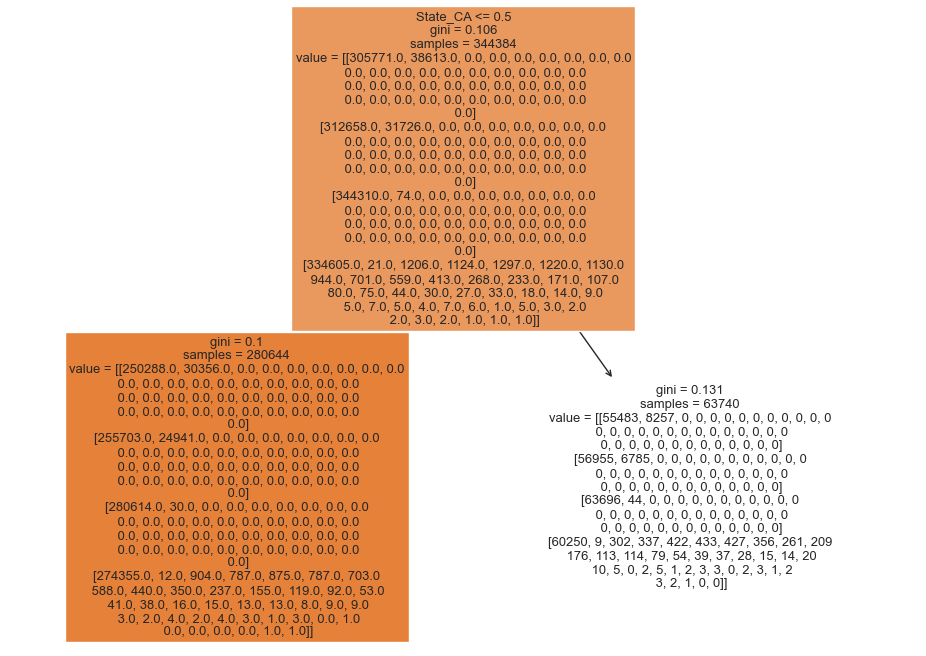

In [1112]:
tree.plot_tree(dt, feature_names = ['State_CA', 'State_NY', 'HasAplos', 'NumUsers'], class_names = [1, 0], filled=True)

# Dictionary

In [ ]:
terms = {
    'total revenue': 'The amount of revenue raised from any taxable source, including but not limited to donations, memberships, events, grants, royalties, rental payments, and transfers from related orgs.',
    'fundraising revenue': 'The amount of revenue raised from donations, memberships, events, and similar payments. This excludes grants, rentals, royalties, and transfers from related orgs. Fundraising revenue is our business opportunity income.',
    'tax year': 'The year of tax reporting in the CauseIQ data. This is not necessarily = previous year.',
    'active customer': 'A customer who had transactions in a given product at a year <= the tax reporting year and >= the tax reporting year. In other words, the tax year falls within transactions.',
    'churned customer': 'A customer who had transactions in a give product at one point, but whose tax reporting year occurs after their most recent transaction.',
    'non-customer market': 'Orgs who have never had a relationship with our products, neither active nor churned nor any other type of relationship. For Bloomerang, this means these non-customers have no database name, for QGiv they have no ID, and for Kindful they have no subdomain.',
    'ntee': 'The category of org, under tax reporting'}

In [ ]:
termsTable = pd.DataFrame.from_dict(terms, orient='index').reset_index()
termsTable.columns = ['term', 'definition']

termsTable.sort_values('term', inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
termsTable

term                                         definition
3      active customer  A customer who had transactions in a given pro...
4     churned customer  A customer who had transactions in a give prod...
1  fundraising revenue  The amount of revenue raised from donations, m...
5  non-customer market  Orgs who have never had a relationship with ou...
6                 ntee           The category of org, under tax reporting
2             tax year  The year of tax reporting in the CauseIQ data....
0        total revenue  The amount of revenue raised from any taxable ...

In [ ]:
# Example retrieval
terms['active customer']

'A customer who had transactions in a given product at a year <= the tax reporting year and >= the tax reporting year. In other words, the tax year falls within transactions.'